In [1]:
# Standard libraries
import os
import sys
import absl
import copy
import glob
import logging
from contextlib import contextmanager

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.saving import register_keras_serializable

In [2]:
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Tensorflow:", tf.__version__)

Numpy: 1.26.4
Pandas: 2.3.1
Tensorflow: 2.15.0


# Settings

In [3]:
## Before training
STORE_PREPROCESSED_TEST_DATA = True # Only used for testing model deployment
MATLAB_COMPATIBLE_MODEL = True # Generate models fully compatible with MATLAB (e.g., for import and quantization using dlquantizer)
## During training
TRAIN = True # If False, skip training and load the pre-trained model instead
LOAD_PRETRAINED_MODEL = False # TRAIN must be True; if True, a already trained model will be loaded
SAVE_MODEL = True # TRAIN must be True; if True, the model will be saved during training
SAVE_MODEL_SUPPRESS_MESSAGES = False # SAVE_MODEL must be True; IF True, ignores all messages related to saving the model
## After/No training
LOAD_MODEL_TYPE = ".h5" # Select either '.keras' or '.h5' as the model file format, this only matters if TRAIN is set to False
CONVERT_MODEL = True # If set to True, converts the .h5 model to SavedModel and TFLite formats and saves them
QUANTIZE_MODEL = True # CONVERT_MODEL must be True; if True, model will be quantized during convertion
USE_QUANTIZED_MODELS = False  # If set to True, calculate prediction of previous generated (!) quantized models
GENERATE_C_ARRAY = False # CONVERT_MODEL and QUANTIZE_MODEL or USE_QUANTIZED_MODELS must be True; if True, quantized model will be converted to an C arry

# Dataset 

In [4]:
FREQUENCY = "20Hz" # Select frequency of input data: 10Hz or 20Hz

# Settings for column names (depending on the frequency used)
if FREQUENCY == "10Hz":
    columns_obj = {
        "current": "current_10Hz",
        "current_d": "XcpAnaStrMotorD_10Hz",
        "current_q": "XcpAnaStrMotorQ_10Hz",
        "current_q_delta_start": "XcpAnaStrMotorQ_10Hz_delta_start",
        "current_q_start": "XcpAnaStrMotorQ_10Hz_start",
        "downtime": "downtime",
        "duty_cycle": "duty_cycle_10Hz",
        "index_delta_start": "index_delta_start",
        "power_d": "power_d_10Hz",
        "power_q": "power_q_10Hz",
        "power_q_delta_start": "power_q_10Hz_delta_start",
        "power_q_start": "power_q_10Hz_start",
        "runtime": "runtime",
        "speed": "XcpAnaDrzMotorIst_10Hz",
        "speed_delta": "XcpAnaDrzMotorIst_10Hz_delta",
        "temp_area": "EinAnaTmpUmgebung_10Hz",
        "temp_machine": "EinAnaTmpMotorWickl_10Hz",
        "temp_machine_start": "EinAnaTmpMotorWicklU2_10Hz_start",
        "temp_pcb": "XcpAnaTmpElektronik_10Hz",
        "temp_pcb_delta": "XcpAnaTmpElektronik_10Hz_delta",
        "temp_pcb_delta_start": "XcpAnaTmpElektronik_10Hz_delta_start",
        "temp_pcb_start": "XcpAnaTmpElektronik_10Hz_start", 
        "voltage": "voltage_10Hz",
        "voltage_d": "XcpAnaSpgMotorD_10Hz",
        "voltage_q": "XcpAnaSpgMotorQ_10Hz",
        "voltage_q_delta_start": "XcpAnaSpgMotorQ_10Hz_delta_start",
        "voltage_q_start": "XcpAnaSpgMotorQ_10Hz_start"
    }
elif FREQUENCY == "20Hz":
    columns_obj = {
        "current": "current_20Hz",
        "current_d": "XcpAnaStrMotorD_20Hz",
        "current_q": "XcpAnaStrMotorQ_20Hz",
        "current_q_delta_start": "XcpAnaStrMotorQ_20Hz_delta_start",
        "current_q_start": "XcpAnaStrMotorQ_20Hz_start",
        "downtime": "downtime",
        "duty_cycle": "duty_cycle_20Hz",
        "index_delta_start": "index_delta_start",
        "power": "power_20Hz",
        "power_d": "power_d_20Hz",
        "power_q": "power_q_20Hz",
        "power_q_delta_start": "power_q_20Hz_delta_start",
        "power_q_start": "power_q_20Hz_start",
        "runtime": "runtime",
        "speed": "XcpAnaDrzMotorIst_20Hz",
        "speed_delta": "XcpAnaDrzMotorIst_20Hz_delta",
        "temp_machine": "EinAnaTmpMotorWicklU2_20Hz",
        "temp_machine_start": "EinAnaTmpMotorWicklU2_20Hz_start",
        "temp_area": "EinAnaTmpUmgebung_20Hz",
        "temp_pcb": "XcpAnaTmpElektronik_20Hz",
        "temp_pcb_delta": "XcpAnaTmpElektronik_20Hz_delta",
        "temp_pcb_delta_start": "XcpAnaTmpElektronik_20Hz_delta_start", 
        "temp_pcb_start": "XcpAnaTmpElektronik_20Hz_start", 
        "voltage": "voltage_20Hz",
        "voltage_d": "XcpAnaSpgMotorD_20Hz",
        "voltage_q": "XcpAnaSpgMotorQ_20Hz",
        "voltage_q_delta_start": "XcpAnaSpgMotorQ_20Hz_delta_start",
        "voltage_q_start": "XcpAnaSpgMotorQ_20Hz_start"
    }

In [5]:
active_model = "Model_111" # To select a specific version, update the corresponding variable in the model
# Model_113 für Johannes Lang und Matlab quantisiertes Modell
# Model_111 das letzte mit allen Daten, nicht-quantisiertes Modell.

# Model Definition

In [6]:
# It is possible to provide an individual NR_Samples value for each version (e.g., Model_018_FCNN)
# If "START_TEMP_ACTIVE" is set to True, adapt the prediction logic for .tflite models (This is currently not implemented, as the predicted temperature is not used as feedback)
models_config = {
    "Model_012": {
        "model": "FCNN", 
        "version": 1,  # Only one version is currently available
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0, 
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [columns_obj["speed"], columns_obj["current"], columns_obj["voltage"], columns_obj["temp_pcb"], 
                          columns_obj["temp_pcb_delta_start"], columns_obj["temp_machine_start"], columns_obj["index_delta_start"]]
    }, 

    "Model_014": {
        "model": "FCNN", 
        "version": 1,  # Only one version is currently available
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": True,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": True,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [columns_obj["speed"], columns_obj["current"], columns_obj["voltage"], columns_obj["temp_pcb"], 
                          columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_machine_start"]]
    },

    "Model_016_CNN": {
        "model": "CNN", 
        "version": 1,  # Only one version is currently available
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"],
                          columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                          columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start'], columns_obj["temp_machine_start"]]
    }, 

    "Model_016_FCNN": {
        "model": "FCNN", 
        "version": 1,  # Only one version is currently available
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False, 
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False, 
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"],
                          columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                          columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start'], columns_obj["temp_machine_start"]]
    }, 

    "Model_018_FCNN": {
        "model": "FCNN", 
        "version": 3, # Select either 1, 2, 3 or 4 (Model 3 was created solely for deployment testing)
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30, 30, 20, 30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"],
                          columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                          columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start'], columns_obj["temp_machine_start"]]
    },

    "Model_018_LSTM": {
        "model": "LSTM", 
        "version": 1,  # Only one version is currently available
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,  
            "EARLY_STOPPING": False,   
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False 
        },
        "sel_col_input": [columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"],
                          columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                          columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start'], columns_obj["temp_machine_start"]]
    },

    "Model_020": {
        "model": "FCNN",
        "version": 1,  # Only one version is currently available 
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": True,        
            "DELTA_START": True,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False 
        },
        "sel_col_input": [columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"],
                          columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                          columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start'], columns_obj["temp_machine_start"]]
    },

    "Model_110": {
        "model": "FCNN", 
        "version": 2, # Select either 1, 2 or 3 (Model 2 was created solely for deployment testing)
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": False,        
            "DELTA_START": False,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30, 20, 30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False 
        },
        "sel_col_input": [ columns_obj["temp_pcb"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"], columns_obj["current_q"], 
                           columns_obj["voltage_q"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start']]
    },

    "Model_111": {
        "model": "FCNN", 
        "version": 4, # Select either 1, 2, 3, 4
        "params": {
            "ADAPT_BATCH_AND_EPOCH": True, # version 4 doesn't use adapted batch size and number of epochs --> see next code block
            "ADAPAT_LEARNING_RATE": True, # version 4 doesn't use adapted learning rate --> see next code block
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,  
            "CUSTOM_LOSS_FUNCTION": False, # version: 3 uses a custom loss function --> see next code block
            "CUSTOM_PARAMETERS": True, # version 4 doesn't use any custom parameters --> see next code block
            "CUT_OFF": False,
            "DELTA": False,        
            "DELTA_START": False, 
            "DROPOUT": 0,  
            "EARLY_STOPPING": False, 
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30, 30, 30, 30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [ columns_obj["temp_pcb"], columns_obj["temp_pcb_delta"], columns_obj["temp_pcb_start"],
                           columns_obj["current_d"], columns_obj["current_q"], columns_obj["voltage_d"], columns_obj["voltage_q"], 
                           columns_obj["speed"], columns_obj["runtime"], columns_obj['downtime'], columns_obj['index_delta_start']]
    }, 

    "Model_112": {
        "model": "FCNN", 
        "version": 1,
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False, 
            "ADAPAT_LEARNING_RATE": False, 
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,  
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False, 
            "CUT_OFF": False,
            "DELTA": False,        
            "DELTA_START": False, 
            "DROPOUT": 0,  
            "EARLY_STOPPING": False, 
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [5],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [ columns_obj["temp_pcb"], columns_obj["temp_pcb_start"], columns_obj["current"], 
                           columns_obj["power"], columns_obj["speed"], columns_obj["runtime"], columns_obj['index_delta_start']]
    }, 

    "Model_113": {
        "model": "FCNN", 
        "version": 1,
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False, 
            "ADAPAT_LEARNING_RATE": False, 
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,  
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False, 
            "CUT_OFF": False,
            "DELTA": False,        
            "DELTA_START": False, 
            "DROPOUT": 0,  
            "EARLY_STOPPING": False, 
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [4],
            "OFFSET": 5, # Example: OFFSET == 5 --> 5 * 0.05 = 0.25s offset between datapoints (20Hz data)
            "RESHAPE": True,        
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": True,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": [ columns_obj["temp_pcb"], columns_obj["temp_pcb_start"], columns_obj["current"], 
                           columns_obj["power"], columns_obj["speed"], columns_obj["runtime"], columns_obj['index_delta_start']]
    }, 

    # This model is hidden and only used for testing purposes
    "Model_999": {
        "model": "FCNN", 
        "version": 3, # Select either 1, 2, 3
        "params": {
            "ADAPT_BATCH_AND_EPOCH": False,
            "ADAPAT_LEARNING_RATE": False,
            "ADD_TEMP_INPUT": False, 
            "AVERAGE_Y": False,
            "CUSTOM_LOSS_FUNCTION": False,
            "CUSTOM_PARAMETERS": False,
            "CUT_OFF": False,
            "DELTA": False,        
            "DELTA_START": False,  
            "DROPOUT": 0,   
            "EARLY_STOPPING": False,  
            "L2_REGULARIZERS": 0,
            "NR_SAMPLES": [30, 30, 30, 30],
            "OFFSET": 0,
            "RESHAPE": True,         
            "SCALE_X": True,     
            "SHOW_ABSOLUTE_TEMP": True,   
            "SMOOTHING": False,   
            "START_TEMP_ACTIVATE": False
        },
        "sel_col_input": []
    }
}

### Adjust model definition

In [7]:
if(active_model == "Model_111" and models_config[active_model]["version"] == 3):
    models_config[active_model]["params"]["CUSTOM_LOSS_FUNCTION"] = True
elif(active_model == "Model_111" and models_config[active_model]["version"] == 4):
    models_config[active_model]["params"]["ADAPT_BATCH_AND_EPOCH"] = False
    models_config[active_model]["params"]["ADAPAT_LEARNING_RATE"] = False
    models_config[active_model]["params"]["USE_CUSTOM_PARAMETERS"] = False

# Load model from hidden folder 'sandbox'
if(active_model == "Model_999"):
    LOAD_MODEL_SANDBOX = True  
else:
    LOAD_MODEL_SANDBOX = False

### USE THIS FOR FAST PROTOTYPING

In [8]:
# Prototypes of Model_999
if(LOAD_MODEL_SANDBOX == True):
    if(models_config[active_model]["version"] == 1):
        models_config[active_model]["sel_col_input"] = [            
                columns_obj["temp_pcb"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"], columns_obj["speed"], 
                columns_obj["voltage_q"], columns_obj["current_q"],columns_obj["duty_cycle"], columns_obj['index_delta_start']
            ]
    elif(models_config[active_model]["version"] == 2):
        models_config[active_model]["sel_col_input"] = [            
                columns_obj["temp_pcb"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"], columns_obj["current_q"], 
                columns_obj["voltage_q"], columns_obj["duty_cycle"], columns_obj['speed'], columns_obj['index_delta_start']
            ]
    elif(models_config[active_model]["version"] == 3):
        models_config[active_model]["sel_col_input"] = [            
                columns_obj["temp_pcb"], columns_obj["temp_pcb_delta_start"], columns_obj["temp_pcb_start"], columns_obj["current_q"], 
                columns_obj["voltage_q"], columns_obj["runtime"], columns_obj['downtime'], columns_obj["speed"], columns_obj['index_delta_start']
            ]

# Parameters

In [9]:
# Define model 
MODELCHOICE = models_config[active_model]["model"] # Choose model-structure: CNN, LSTM or FCNN 
MODELVERSION = models_config[active_model]["version"] 
# Define parameters for preprocessing of data and training of model 
# USE_CUSTOM_PARAMETERS must be True; if True, custom values for batch sizes and epochs will be used 
ADAPT_BATCH_AND_EPOCH = models_config[active_model]["params"]["ADAPT_BATCH_AND_EPOCH"]
# USE_CUSTOM_PARAMETERS must be True; if True, learning rate will be adapted during training
ADAPAT_LEARNING_RATE = models_config[active_model]["params"]["ADAPAT_LEARNING_RATE"] 
# If True: Append the previous predicted temperature to the current input vector
ADD_TEMP_INPUT = models_config[active_model]["params"]["ADD_TEMP_INPUT"]  
# If True: Apply Gaussian average to label; If False: No averaging 
AVERAGE_Y = models_config[active_model]["params"]["AVERAGE_Y"] 
# Internally used, do not change this!
AVERAGE_Y_DONE = False 
# If True, data will be truncated from the dataset using REMOVE_FRONT and REMOVE_END
CUT_OFF = models_config[active_model]["params"]["CUT_OFF"] 
# If True: label is Delta-Temperature; If False: label is absolute Temperature
DELTA = models_config[active_model]["params"]["DELTA"] 
# Internally used, do not change this!
DELTA_DONE = False 
# (DELTA has to be True!) If True: Calculate the temperature difference relative to the initial temperature of the frame 
DELTA_START = models_config[active_model]["params"]["DELTA_START"] 
# Number of past measurements used as input for the current prediction
if(type(models_config[active_model]["params"]["NR_SAMPLES"] ) == type(list())):
    NR_SAMPLES = models_config[active_model]["params"]["NR_SAMPLES"][MODELVERSION - 1]
else:
    NR_SAMPLES = models_config[active_model]["params"]["NR_SAMPLES"] 
# Gap size between valid datapoints
OFFSET = models_config[active_model]["params"]["OFFSET"]
# If True: Data is reshaped by taking past measurements into account 
RESHAPE = models_config[active_model]["params"]["RESHAPE"] 
# Internally used, do not change this!
RESHAPE_DONE = False 
# If True: Scale Input data between 0 and 1; If False: No scaling of Input data
SCALE_X = models_config[active_model]["params"]["SCALE_X"] 
# If True: Smooth input and output data by using a rolling window and exponential filter 
SMOOTHING = models_config[active_model]["params"]["SMOOTHING"]
# If True: Start temperature is only added once to current input vector
START_TEMP_ACTIVATE = models_config[active_model]["params"]["START_TEMP_ACTIVATE"] 
# Train must be True; if True, a custom loss function will be used during training
USE_CUSTOM_LOSS_FUNCTION = models_config[active_model]["params"]["CUSTOM_LOSS_FUNCTION"] 
# TRAIN must be True; if True, custom learning parameters might be used  
USE_CUSTOM_PARAMETERS = models_config[active_model]["params"]["CUSTOM_PARAMETERS"] 
# USE_CUSTOM_PARAMETERS must be True; if True, early stopping will be used during training
USE_EARLY_STOPPING = models_config[active_model]["params"]["EARLY_STOPPING"] 
# Define output mode
SHOW_ABSOLUTE_TEMP = models_config[active_model]["params"]["SHOW_ABSOLUTE_TEMP"]

# Configuration based on parameters
if DELTA == True:
    if(DELTA_START):
        # If True: Scale label between 0 and 1 (for Delta-Temperature not necessary - just useful for absolute Temperature)
        SCALE_Y = True     
    else: 
        SCALE_Y = False    
else:
    SCALE_Y = True 

# Define Input - Data and Label

In [10]:
# Define input for model 
sel_col_input = models_config[active_model]["sel_col_input"]
# In this case: EinAnaTmpMotorWickl_10Hz is an input value 
if ADD_TEMP_INPUT == True:          
    sel_col_input.append(columns_obj["temp_machine"])

# Define label for model 
sel_col_label = columns_obj["temp_machine"]

# Load Dataset

Number of files (Training):  1756
Number of files (Test):  361
####### --- TRAINDATA --- ########
Counter:  0
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_4.csv


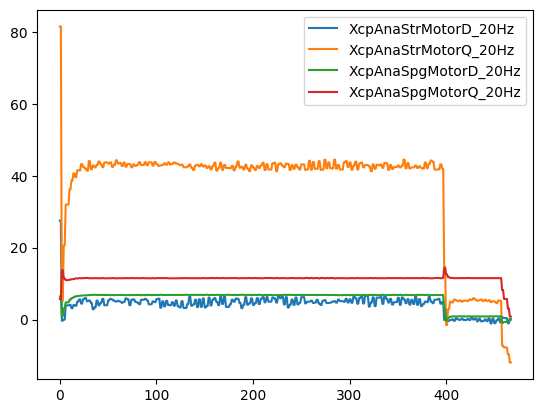

Shape x:  (468, 11)
Shape y:  (468,)
Counter:  1
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_62.csv


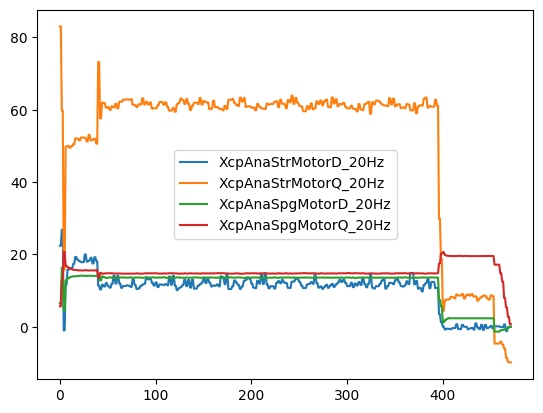

Shape x:  (472, 11)
Shape y:  (472,)
Counter:  2
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_63.csv


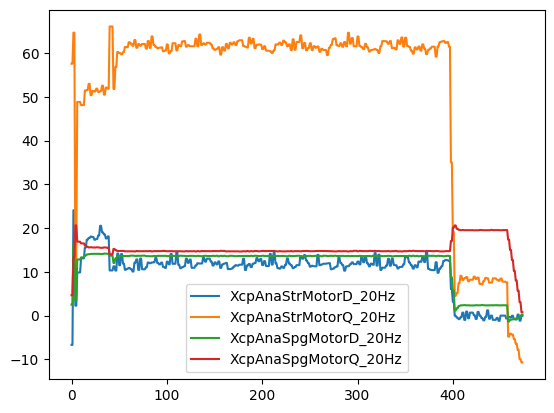

Shape x:  (474, 11)
Shape y:  (474,)
Counter:  3
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_5.csv


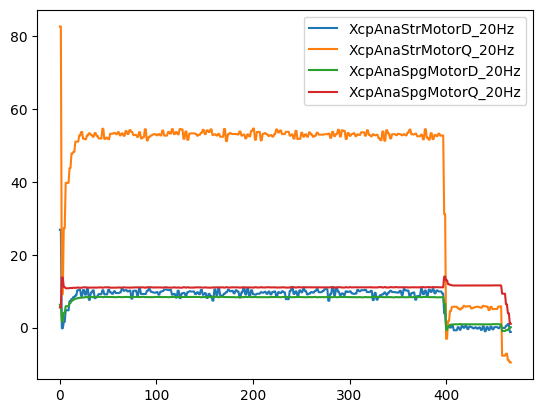

Shape x:  (468, 11)
Shape y:  (468,)
Counter:  4
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_7.csv
Shape x:  (466, 11)
Shape y:  (466,)
Counter:  5
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_61.csv
Shape x:  (472, 11)
Shape y:  (472,)
Counter:  6
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_49.csv
Shape x:  (468, 11)
Shape y:  (468,)
Counter:  7
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_48.csv
Shape x:  (470, 11)
Shape y:  (470,)
Counter:  8
Path ../data/train/real-world/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20Hz_intensity/LA01BT1052_13_Kennfeld_30sec_Last_Drz_reduziert_20H

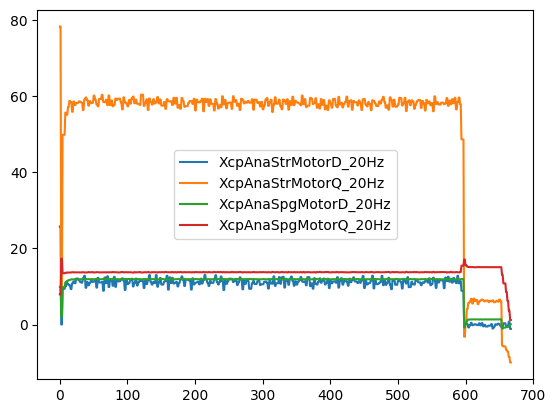

Shape x:  (668, 11)
Shape y:  (668,)
Counter:  1
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_53.csv


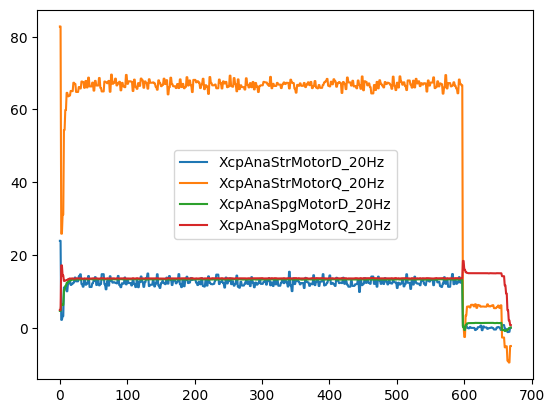

Shape x:  (670, 11)
Shape y:  (670,)
Counter:  2
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_84.csv


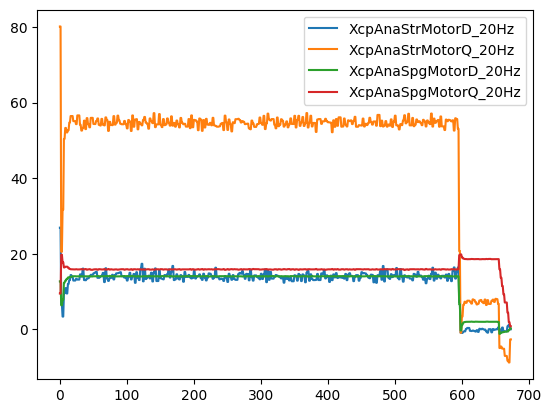

Shape x:  (674, 11)
Shape y:  (674,)
Counter:  3
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_90.csv


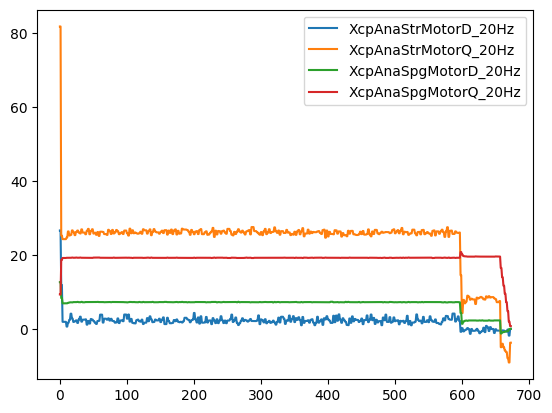

Shape x:  (674, 11)
Shape y:  (674,)
Counter:  4
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_91.csv
Shape x:  (672, 11)
Shape y:  (672,)
Counter:  5
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_85.csv
Shape x:  (676, 11)
Shape y:  (676,)
Counter:  6
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_52.csv
Shape x:  (670, 11)
Shape y:  (670,)
Counter:  7
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_46.csv
Shape x:  (672, 11)
Shape y:  (672,)
Counter:  8
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_50.csv
Shape x:  (668, 11)
Shape y:  (668,)
Counter:  9
Path ../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_44.csv
Shape x:  (672, 11)
Shape y:  (672

In [11]:
# Define data format
ext = "csv"
# Define machine ID
machine_id = ""
# Define train and test directory
target_train = glob.glob(os.path.join("../data/train/", "**", "*.csv"), recursive=True)
target_test = glob.glob(os.path.join("../data/test", "**", "*.csv"), recursive=True)
list_path_train_original = [f for f in target_train if (f.endswith(ext) and machine_id in f)]
list_path_test_original = [f for f in target_test if (f.endswith(ext) and machine_id in f)]

list_path_train = []
list_path_test = []

if(CUT_OFF == False):
    list_path_train = list_path_train_original
    list_path_test = list_path_test_original

print("Number of files (Training): ", len(list_path_train_original))
print("Number of files (Test): ", len(list_path_test_original))

list_data_x_train = []
list_data_x_test = []
list_data_y_train = []
list_data_y_train_dist = []
list_data_y_test = []
list_data_y_test_dist = []
# Only relevant if columns_obj["temp_machine_start"] in sel_col_input and START_TEMP_ACTIVATE == True
start_temp = False
list_start_temp_train = []
list_start_temp_test = []

WINDOW_SIZE = OFFSET
REMOVE_FRONT = 20
REMOVE_END = 100

select = -1
ACTIVATE_SELECT = False

for i in range(2):
    list_path = list_path_train if i == 0 else list_path_test
    list_data_x = list_data_x_train if i == 0 else list_data_x_test
    list_data_y = list_data_y_train if i == 0 else list_data_y_test
    list_path_original = list_path_train_original if i == 0 else list_path_test_original
    # Start/Restart counter
    counter = 0
    if(i == 0):
        print("####### --- TRAINDATA --- ########")
    elif(i == 1):
        print("####### --- TESTDATA --- ########")

    for path in list_path_original:
        # Print counter and path 
        print("Counter: ", counter)
        counter += 1
        print("Path", path)
        # Read in csv file 
        df = pd.read_csv(path, sep = "\t")

        if("test" in path and ACTIVATE_SELECT == True):
            if(all((df[columns_obj["temp_machine"]] < 60))):
                select += 1
                if((select % 4) != 0):
                    continue
        if("statistical" in path):
            if(not any((df[columns_obj["temp_machine"]] > 70))):
                continue

        if(any(df[columns_obj["current_q"]] < -20)):
            print(path)
    

        if(CUT_OFF == True):
            # Remove first REMOVE_FRONT samples
            # Remove last REMOVE_END samples 
            if(len(df) > REMOVE_FRONT + REMOVE_END):
                df = df[REMOVE_FRONT:]
                df = df[:-REMOVE_END]
                df.reset_index(drop=True, inplace=True)
                list_path.append(path)
            else:
                continue

        ### Prepare inputs:
        ## Time 
        # Calculate index_delta_start
        if(columns_obj["index_delta_start"] in sel_col_input):
            if(active_model == "Model_012" or active_model == "Model_014"):
                df[columns_obj["index_delta_start"]] = (df["index"] - df["index"].iloc[0]) * 0.05
            else: 
                df[columns_obj["index_delta_start"]] = df["index"] - df["index"].iloc[0]
        # Caculate dutycycle 
        if(columns_obj["duty_cycle"] in sel_col_input):
            df[columns_obj["duty_cycle"]] = (df[columns_obj["runtime"]] - df[columns_obj["downtime"]])/15000

        ## Machine Temperature
        # Calculate inital temperature of machine 
        if((columns_obj["temp_machine_start"] in sel_col_input or start_temp == True) and START_TEMP_ACTIVATE == True):
            if(start_temp == False):
                start_temp = True
                sel_col_input.remove(columns_obj["temp_machine_start"])
            list_start_temp_train.append(df[columns_obj["temp_machine"]].iloc[0])
        elif(columns_obj["temp_machine_start"] in sel_col_input): 
            df[columns_obj["temp_machine_start"]] = df[columns_obj["temp_machine"]].iloc[0]

        ## Speed (RPM)
        # Calculate absolute value of speed
        if(columns_obj["speed"] in sel_col_input):
            df[columns_obj["speed"]] = abs(df[columns_obj["speed"]])   
        # Calculate speed delta
        if(columns_obj["speed_delta"] in sel_col_input):
            if(columns_obj["speed"] not in sel_col_input):
                df[columns_obj["speed"]] = abs(df[columns_obj["speed"]])
            df[columns_obj["speed_delta"]] = df[columns_obj["speed"]] - df[columns_obj["speed"]].shift(1)
            df.loc[0, columns_obj["speed_delta"]] = 0
        
        ## PCB
        # Calculate pcb delta temperature
        if(columns_obj["temp_pcb_delta"] in sel_col_input):
            if(active_model == "Model_016_CNN"):
                # Model training of Modell_016_CNN was completed before the code was restructured ->  therefore, the old version must be used
                print("Old version is used!")
                df[columns_obj["temp_pcb_delta"]] = df[columns_obj["temp_pcb"]].shift(1) - df[columns_obj["temp_pcb"]]
            else: 
                df[columns_obj["temp_pcb_delta"]] = df[columns_obj["temp_pcb"]] - df[columns_obj["temp_pcb"]].shift(1)
            df.loc[0, columns_obj["temp_pcb_delta"]] = 0
        # Calculate pcb delta temperature to initial value
        if(columns_obj["temp_pcb_delta_start"] in sel_col_input):
            df[columns_obj["temp_pcb_delta_start"]] = df[columns_obj["temp_pcb"]] - df[columns_obj["temp_pcb"]].iloc[0]
        # Calculate initial temperature of pcb
        if(columns_obj["temp_pcb_start"] in sel_col_input):
            df[columns_obj["temp_pcb_start"]] = df[columns_obj["temp_pcb"]].iloc[0]

        ## Current
        # Calculate current, using d and q component
        if(columns_obj["current"] in sel_col_input):
            df[columns_obj["current"]] = np.sqrt(np.power(df[columns_obj["current_d"]], 2) + np.power(df[columns_obj["current_q"]], 2))
        # Calculate delta in q-current relative to its initial value
        if(columns_obj["current_q_delta_start"] in sel_col_input):
            df[columns_obj["current_q_delta_start"]] = df[columns_obj["current_q"]] - df[columns_obj["current_q"]].iloc[0]
        # Calculate initial q-current
        if(columns_obj["current_q_start"] in sel_col_input):
            df[columns_obj["current_q_start"]] = df[columns_obj["current_q"]].iloc[0]
        
        ## Voltage
        # Calculate voltage, using d and q component
        if(columns_obj["voltage"] in sel_col_input):
            df[columns_obj["voltage"]] = np.sqrt(np.power(df[columns_obj["voltage_d"]], 2) + np.power(df[columns_obj["voltage_q"]], 2))
        # Calculate delta in q-voltage relative to its initial value
        if(columns_obj["voltage_q_delta_start"] in sel_col_input):
            df[columns_obj["voltage_q_delta_start"]] = df[columns_obj["voltage_q"]] - df[columns_obj["voltage_q"]].iloc[0]
        # Calculate initial q-voltage
        if(columns_obj["voltage_q_start"] in sel_col_input):
            df[columns_obj["voltage_q_start"]] = df[columns_obj["voltage_q"]].iloc[0]

        ## Power 
        # Calculate power
        if(columns_obj["power"] in sel_col_input):
            if(columns_obj["voltage"] not in sel_col_input):
                df[columns_obj["voltage"]] = np.sqrt(np.power(df[columns_obj["voltage_d"]], 2) + np.power(df[columns_obj["voltage_q"]], 2))
            if(columns_obj["current"] not in sel_col_input):
                df[columns_obj["current"]] = np.sqrt(np.power(df[columns_obj["current_d"]], 2) + np.power(df[columns_obj["current_q"]], 2))
            df[columns_obj["power"]] = df[columns_obj["current"]] * df[columns_obj["voltage"]]
        # Calculate power_d
        if(columns_obj["power_d"] in sel_col_input):
            df[columns_obj["power_d"]] = df[columns_obj["current_d"]] * df[columns_obj["voltage_d"]]
        # Calculate power_q
        if(columns_obj["power_q"] in sel_col_input):
            df[columns_obj["power_q"]] = df[columns_obj["current_q"]] * df[columns_obj["voltage_q"]]
        # Calculate q-power delta to initial value
        if(columns_obj["power_q_delta_start"] in sel_col_input):
            if(columns_obj["power_q"] not in sel_col_input):
                df[columns_obj["power_q"]] = df[columns_obj["current_q"]] * df[columns_obj["voltage_q"]]
            df[columns_obj["power_q_delta_start"]] = df[columns_obj["power_q"]] - df[columns_obj["power_q"]].iloc[0]
        # Calculate initial q-power
        if(columns_obj["power_q_start"] in sel_col_input):
            if(columns_obj["power_q"] not in sel_col_input):
                df[columns_obj["power_q"]] = df[columns_obj["current_q"]] * df[columns_obj["voltage_q"]]
            df[columns_obj["power_q_start"]] = df[columns_obj["power_q"]].iloc[0]

        if SMOOTHING:
            smoothing_applied = False
            for col in ["power", "speed", "current"]:
                if columns_obj[col] in sel_col_input:
                    df[columns_obj[col]] = df[columns_obj[col]].rolling(window=WINDOW_SIZE).mean()   
                    smoothing_applied = True    
            if(smoothing_applied == True):
                df = df.iloc[WINDOW_SIZE-1:]

        if counter < 5:
            plt.figure()
            plt.plot(df[columns_obj["current_d"]], label = columns_obj["current_d"])
            plt.plot(df[columns_obj["current_q"]], label = columns_obj["current_q"])
            plt.plot(df[columns_obj["voltage_d"]], label = columns_obj["voltage_d"])
            plt.plot(df[columns_obj["voltage_q"]], label = columns_obj["voltage_q"])
            plt.legend()
            plt.show()
        
        # Transform data
        data_x = np.array(df[sel_col_input].values)
        data_y = np.array(df[sel_col_label].values)
        # Print dimensions
        print("Shape x: ", data_x.shape)
        print("Shape y: ", data_y.shape)
        
        # Append data to list
        list_data_x.append(data_x)
        list_data_y.append(data_y)
        if(i == 0):
            list_data_y_train_dist.extend(data_y)
        else:
            list_data_y_test_dist.extend(data_y)

if(start_temp == True):
    list_start_temp_train = np.array(list_start_temp_train)
    list_start_temp_test = np.array(list_start_temp_test)

### Temperature Distribution

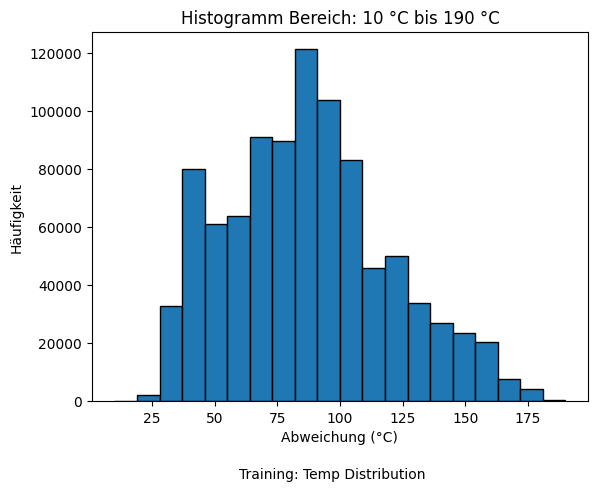

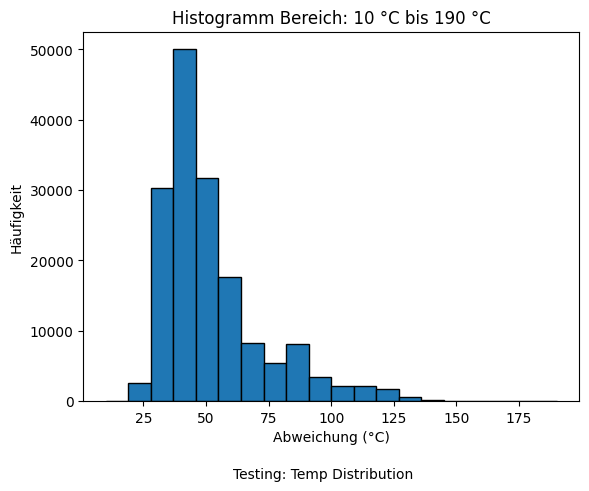

In [12]:
plt.figure()
plt.hist(list_data_y_train_dist, bins=20, range=(10, 190), edgecolor='black')
plt.xlabel('Abweichung (°C)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm Bereich: 10 °C bis 190 °C')
plt.figtext(0.5, -0.05, 'Training: Temp Distribution', ha='center', fontsize=10)
plt.show()
plt.figure()
plt.hist(list_data_y_test_dist, bins=20, range=(10, 190), edgecolor='black')
plt.xlabel('Abweichung (°C)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm Bereich: 10 °C bis 190 °C')
plt.figtext(0.5, -0.05, 'Testing: Temp Distribution', ha='center', fontsize=10)
plt.show()

# get Delta Temperature as Label or stay with absolute Temperature

In [13]:
if(DELTA == True and DELTA_DONE == False):
    DELTA_DONE = True
    # Deep copy of training and test data
    list_data_y_train_no_delta = copy.deepcopy(list_data_y_train)
    list_data_y_test_no_delta = copy.deepcopy(list_data_y_test)
    for i in range(2):
        list_path = list_path_train if i == 0 else list_path_test
        list_data_y = list_data_y_train if i == 0 else list_data_y_test
        list_data_y_no_delta = list_data_y_train_no_delta if i == 0 else list_data_y_test_no_delta
        # .shape for a 1-D array: tupel
            # .shape[0]: number of rows
            # .shape[1]: None
        for kk in range(len(list_data_y)):
            data_y = list_data_y[kk]
            delta_y = np.zeros(data_y.shape[0])
            if(DELTA_START):
                for nn in range(0, data_y.shape[0], 1):
                    delta_y[nn] = data_y[nn] - data_y[0]
            else: 
                # range(start, stop, step) --> stop is not (!) included
                for nn in range(data_y.shape[0]-1, 0, -1):
                    delta_y[nn] = data_y[nn] - data_y[nn-1]
            list_data_y[kk] = delta_y
        if(i == 0):
            print("####### --- TRAINDATA --- ########")
        elif(i == 1):
            print("####### --- TESTDATA --- ########")
        for kk in range(4):
            print(list_path[kk])
            plt.figure()
            plt.subplot(2,1,1)
            plt.plot(list_data_y[kk])
            plt.subplot(2,1,2)
            plt.plot(list_data_y_no_delta[kk])
            plt.show()    
else: 
    print("Delta temperature deactivated!")
    

Delta temperature deactivated!


# Gauss-Average the Label (Delta-Temperature or Absolute Temperature) if wanted

In [14]:
if(AVERAGE_Y == True and AVERAGE_Y_DONE == False):
    AVERAGE_Y_DONE = True
    # Deep copy of training and test data
    list_data_y_train_no_avg = copy.deepcopy(list_data_y_train)
    list_data_y_test_no_avg = copy.deepcopy(list_data_y_test)
    # Number of previous temperature values used to compute the Gauss-Aaverage of the current label
    n_average = 9
    for i in range(2):
        list_data_y = list_data_y_train if i == 0 else list_data_y_test
        list_data_y_no_avg = list_data_y_train_no_avg if i == 0 else list_data_y_test_no_avg
        for kk in range(len(list_data_y)):
            data_y = list_data_y[kk]
            # range(start, stop, step) --> stop is not (!) included and default of step is 1 (!) 
            for nn in range(n_average, data_y.shape[0]):
                '''
                data_y[nn] = 0.4 * data_y[nn] + 0.3 * data_y[nn-1]  + 0.2 * data_y[nn-2] + 0.1 * data_y[nn-3]
                '''
                # Set n_average = 9 
                data_y[nn] = 0.25 * data_y[nn] + 0.19 * data_y[nn-1]  + 0.14 * data_y[nn-2] + 0.11 * data_y[nn-3] \
                             + 0.09 * data_y[nn-4]+ 0.07 * data_y[nn-5]+ 0.06 * data_y[nn-6] + 0.04 * data_y[nn-7]+ 0.03 * data_y[nn-8]\
                             + 0.02 * data_y[nn-9]
            list_data_y[kk] = data_y

        if(i == 0):
            print("####### --- TRAINDATA --- ########")
        elif(i == 1):
            print("####### --- TESTDATA --- ########")
        for kk in range(4):
            print(list_path_train[kk])
            plt.figure()
            plt.plot(list_data_y_no_avg[kk], label = "no average")
            plt.plot(list_data_y[kk], label = "gauss average")
            plt.legend()
            plt.show()
else: 
    print("Gauss-Average deactivated!")
    

Gauss-Average deactivated!


# Shape of Input and Labels before Reshape

In [15]:
# Input: (number of examples of each frame, number of input columns of each example)
# Label: (number of temperature values of each frame)
if(start_temp == True):
    print("Length Start Temp (Train): ", len(list_start_temp_train))
    print("Length Start Temp (Test): ", len(list_start_temp_test))

for i in range(2):
    if(i == 0):        
        print("####### --- TRAININGDATA --- ########")
    elif(i == 1):
        print("####### --- TESTDATA --- ########")
    list_data_x = list_data_x_train if i == 0 else list_data_x_test
    list_data_y = list_data_y_train if i == 0 else list_data_y_test
    for kk in range(len(list_data_x)):
        print(list_data_x[kk].shape)
        print(list_data_y[kk].shape)

####### --- TRAININGDATA --- ########
(468, 11)
(468,)
(472, 11)
(472,)
(474, 11)
(474,)
(468, 11)
(468,)
(466, 11)
(466,)
(472, 11)
(472,)
(468, 11)
(468,)
(470, 11)
(470,)
(474, 11)
(474,)
(468, 11)
(468,)
(466, 11)
(466,)
(476, 11)
(476,)
(474, 11)
(474,)
(476, 11)
(476,)
(472, 11)
(472,)
(466, 11)
(466,)
(466, 11)
(466,)
(474, 11)
(474,)
(476, 11)
(476,)
(548, 11)
(548,)
(464, 11)
(464,)
(98, 11)
(98,)
(94, 11)
(94,)
(464, 11)
(464,)
(468, 11)
(468,)
(466, 11)
(466,)
(466, 11)
(466,)
(466, 11)
(466,)
(470, 11)
(470,)
(466, 11)
(466,)
(464, 11)
(464,)
(472, 11)
(472,)
(468, 11)
(468,)
(472, 11)
(472,)
(468, 11)
(468,)
(464, 11)
(464,)
(470, 11)
(470,)
(236, 11)
(236,)
(224, 11)
(224,)
(470, 11)
(470,)
(470, 11)
(470,)
(96, 11)
(96,)
(98, 11)
(98,)
(470, 11)
(470,)
(468, 11)
(468,)
(98, 11)
(98,)
(470, 11)
(470,)
(470, 11)
(470,)
(224, 11)
(224,)
(464, 11)
(464,)
(474, 11)
(474,)
(474, 11)
(474,)
(472, 11)
(472,)
(466, 11)
(466,)
(468, 11)
(468,)
(470, 11)
(470,)
(472, 11)
(472,)
(47

# Reshape data to take previous time-steps (NR_SAMPLES) into account
# scale data if wanted

In [16]:
if RESHAPE == True and RESHAPE_DONE == False: 
    RESHAPE_DONE = True
    list_data_y_test_no_reshape = copy.deepcopy(list_data_y_test)
    # np.concat: Join a sequence of arrays along an existing axis (here axis = 0 --> data structures are joined by rows)
    # np.concat: https://numpy.org/doc/stable/reference/generated/numpy.concat.html
    print(np.concatenate(list_data_x_train).shape)
    print(np.concatenate(list_data_y_train).shape)
    # max and min-values for scaling the data - it's easier for the ML model to learn the behaviour with scaled data
    max_x = np.max(np.concatenate(list_data_x_train), axis=0) # axis=0 not necessary --> 0 is default 
    min_x = np.min(np.concatenate(list_data_x_train), axis=0)
    max_y = np.max(np.concatenate(list_data_y_train))
    min_y = np.min(np.concatenate(list_data_y_train))
    print("MIN_X_LIST:\n", min_x)
    print("MAX_X_LIST:\n", max_x)
    print("MIN_Y: ", min_y, " --- ", "MAX_Y: ", max_y)

    if(STORE_PREPROCESSED_TEST_DATA == True):
        os.makedirs("../data/data_preprocessed/", exist_ok=True)
        with open("../data/data_preprocessed/scaling_factors.txt", "w") as file:
            file.write(f"MIN_X: \n{min_x}\n")
            file.write(f"MAX_X: \n{max_x}\n")
            file.write(f"MIN_Y: \n{min_y}\n")
            file.write(f"MAX_Y: \n{max_y}\n")

    if(start_temp == True):
        start_temp_max = np.max(list_start_temp_train)
        start_temp_min = np.min(list_start_temp_train)

    # standard stepsize
    nth = 1
    if(OFFSET == 0):
        boundary = NR_SAMPLES
        if(active_model == "Model_020"):
            slicing_end = NR_SAMPLES
        else:
            slicing_end = NR_SAMPLES + 1
        select_label = boundary
    else:
        boundary = NR_SAMPLES * OFFSET
        # relevant samples: previous NR_SAMPLES (frequency = OFFSET) + current example
        slicing_end = NR_SAMPLES * OFFSET + 1
        # label position
        select_label = boundary
        # stepsize
        nth = OFFSET

    def reshape_data(data_x, data_y):
        list_data_x = list()
        list_data_y = list()
        for kk in range(0, data_x.shape[0] - boundary):
            list_data_x.append(data_x[kk:kk+slicing_end:nth, :])
            list_data_y.append(data_y[kk+select_label])
        
        return np.array(list_data_x), np.array(list_data_y)

    def scale_data_x(data_x, max_x, min_x):
        for uu in range(data_x.shape[-1]):
            data_x[:,:,uu] = (data_x[:,:,uu] - min_x[uu])/(max_x[uu] - min_x[uu])
        return data_x
    
    def scale_data_y(data_y, max_y, min_y):
        data_y = (data_y - min_y)/(max_y - min_y)
        return data_y
    
    def scale_start_temp(data, max, min):
        data = (data - min)/(max - min)
        return data

    for i in range(2): 
        list_path = list_path_train if i == 0 else list_path_test
        list_data_x = list_data_x_train if i == 0 else list_data_x_test
        list_data_y = list_data_y_train if i == 0 else list_data_y_test
        list_start_temp = list_start_temp_train if i == 0 else list_start_temp_test
        if(DELTA == True):
            list_data_y_no_delta = list_data_y_train_no_delta if i == 0 else list_data_y_test_no_delta

        for kk in range(len(list_data_x)-1, -1, -1):
            # boundary defined on top of cell
            if list_data_x[kk].shape[0] > boundary:
                new_data_x, new_data_y = reshape_data(list_data_x[kk], list_data_y[kk])
                if SCALE_X:
                    new_data_x = scale_data_x(new_data_x, max_x, min_x)
                if SCALE_Y == True: 
                    new_data_y = scale_data_y(new_data_y, max_y, min_y)
                list_data_x[kk] = new_data_x
                list_data_y[kk] = new_data_y
            else:
                # if frame is too short for new data-format remove this frame
                # list.pop(position) --> kk == position
                list_data_x.pop(kk)
                list_data_y.pop(kk)
                if(DELTA == True and SHOW_ABSOLUTE_TEMP == True):
                    list_data_y_no_delta.pop(kk)
                list_path.pop(kk)
                if(start_temp == True):
                    list_start_temp = np.delete(list_start_temp, kk, axis=0)

    if(start_temp == True):
        list_start_temp_train = scale_start_temp(list_start_temp_train, start_temp_max, start_temp_min)
        list_start_temp_test = scale_start_temp(list_start_temp_test, start_temp_max, start_temp_min)
else: 
    print("Reshape deactivated!")

(939776, 11)
(939776,)
MIN_X_LIST:
 [ 13.26 -23.5   19.89 -56.72 -92.54  -1.53  -4.51   0.85   0.     0.
   0.  ]
MAX_X_LIST:
 [5.597000e+01 2.200000e+00 4.959000e+01 9.124000e+01 1.090900e+02
 1.844000e+01 2.109000e+01 1.355395e+04 1.500000e+04 1.500000e+04
 6.305000e+03]
MIN_Y:  19.6  ---  MAX_Y:  184.88


In [17]:
for i in range(2): 
    list_data_x = list_data_x_train if i == 0 else list_data_x_test
    list_data_y = list_data_y_train if i == 0 else list_data_y_test
    name = "Train" if i == 0 else "Test"
    
    print(f"\n{name} Dataset:")
    for kk in range(len(list_data_x)):
        print(kk)
        print(list_data_x[kk].shape)
        print(list_data_y[kk].shape)


Train Dataset:
0
(438, 31, 11)
(438,)
1
(442, 31, 11)
(442,)
2
(444, 31, 11)
(444,)
3
(438, 31, 11)
(438,)
4
(436, 31, 11)
(436,)
5
(442, 31, 11)
(442,)
6
(438, 31, 11)
(438,)
7
(440, 31, 11)
(440,)
8
(444, 31, 11)
(444,)
9
(438, 31, 11)
(438,)
10
(436, 31, 11)
(436,)
11
(446, 31, 11)
(446,)
12
(444, 31, 11)
(444,)
13
(446, 31, 11)
(446,)
14
(442, 31, 11)
(442,)
15
(436, 31, 11)
(436,)
16
(436, 31, 11)
(436,)
17
(444, 31, 11)
(444,)
18
(446, 31, 11)
(446,)
19
(518, 31, 11)
(518,)
20
(434, 31, 11)
(434,)
21
(68, 31, 11)
(68,)
22
(64, 31, 11)
(64,)
23
(434, 31, 11)
(434,)
24
(438, 31, 11)
(438,)
25
(436, 31, 11)
(436,)
26
(436, 31, 11)
(436,)
27
(436, 31, 11)
(436,)
28
(440, 31, 11)
(440,)
29
(436, 31, 11)
(436,)
30
(434, 31, 11)
(434,)
31
(442, 31, 11)
(442,)
32
(438, 31, 11)
(438,)
33
(442, 31, 11)
(442,)
34
(438, 31, 11)
(438,)
35
(434, 31, 11)
(434,)
36
(440, 31, 11)
(440,)
37
(206, 31, 11)
(206,)
38
(194, 31, 11)
(194,)
39
(440, 31, 11)
(440,)
40
(440, 31, 11)
(440,)
41
(66, 31, 11

# bring data in the desired shape for AI

In [18]:
# np.concatenate converts the list of arrays/tensors to one huge array/tensor - this shape is necessary for the AI-model 
X_train = np.concatenate(list_data_x_train, axis = 0)
Y_train = np.concatenate(list_data_y_train, axis = 0)
X_test = np.concatenate(list_data_x_test, axis = 0)
Y_test = np.concatenate(list_data_y_test, axis = 0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
ratio = round(X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]),2)
print("Ratio: Train:", ratio, "% --- Test: ", round(1 - ratio,2), "%")

(903052, 31, 11)
(903052,)
(153670, 31, 11)
(153670,)
Ratio: Train: 0.85 % --- Test:  0.15 %


In [19]:
if(STORE_PREPROCESSED_TEST_DATA == True):
    # Store a copy of X_train, X_test, Y_train and Y_test
    X_train_preprocessed = copy.deepcopy(X_train)
    X_test_preprocessed = copy.deepcopy(X_test)
    Y_train_preprocessed = copy.deepcopy(Y_train)
    Y_test_preprocessed = copy.deepcopy(Y_test)
    # Reshape X_train_preprocessed and X_test_preprocessed
    X_train_preprocessed = X_train_preprocessed.reshape(X_train_preprocessed.shape[0], -1)
    X_test_preprocessed = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], -1)

    print(X_train.shape)
    print(X_train_preprocessed.shape)
    print(X_test.shape)
    print(X_test_preprocessed.shape)
    print(Y_train.shape)
    print(Y_train_preprocessed.shape)
    print(Y_test.shape)
    print(Y_test_preprocessed.shape)

    # Convert numpy arrays to dataframes
    data_x_train = pd.DataFrame(X_train_preprocessed)
    data_x_test = pd.DataFrame(X_test_preprocessed)
    data_y_train = pd.DataFrame(Y_train_preprocessed)
    data_y_test = pd.DataFrame(Y_test_preprocessed)
    # Store dataframes in folder data/reshaped 
    if(RESHAPE == False):
        os.makedirs("../data/data_preprocessed/", exist_ok=True)
    data_x_train.to_csv('../data/data_preprocessed/X_train_preprocessed.csv', sep=',', index=False, header=False)
    data_x_test.to_csv('../data/data_preprocessed/X_test_preprocessed.csv', sep=',', index=False, header=False)
    data_y_train.to_csv('../data/data_preprocessed/Y_train_preprocessed.csv', sep=',', index=False, header=False)
    data_y_test.to_csv('../data/data_preprocessed/Y_test_preprocessed.csv', sep=',', index=False, header=False)
else: 
    print("Store preprocessed test data deactivated!")

(903052, 31, 11)
(903052, 341)
(153670, 31, 11)
(153670, 341)
(903052,)
(903052,)
(153670,)
(153670,)


### Temperature Distribution

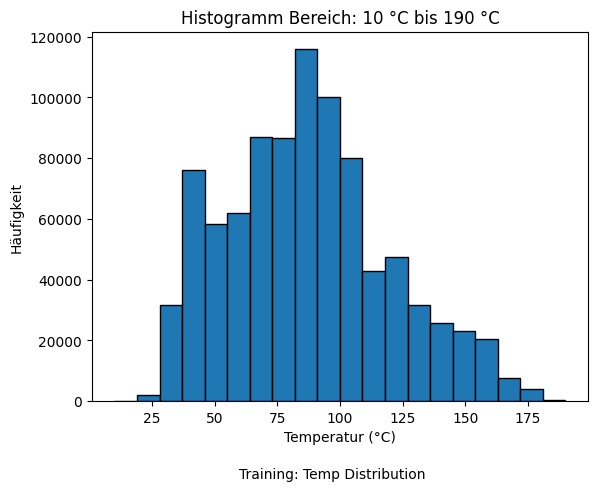

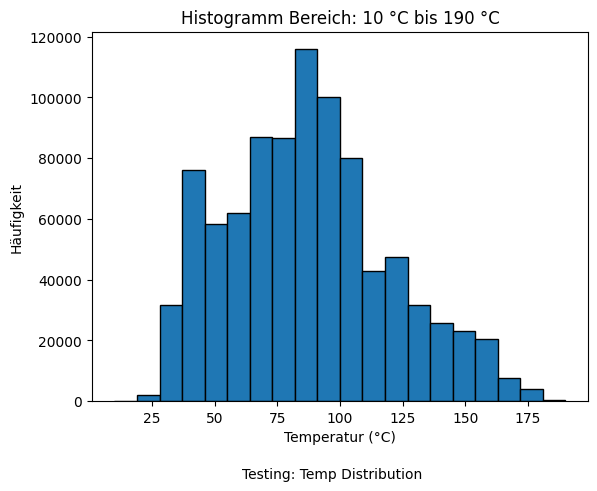

In [20]:
Y_train_dist = copy.deepcopy(Y_train)
Y_train_dist = Y_train_dist*(max_y - min_y) + min_y

Y_test_dist = copy.deepcopy(Y_test)
Y_test_dist = Y_test_dist*(max_y - min_y) + min_y

plt.figure()
if(DELTA_START == True):
    plt.hist(Y_train_dist, bins=20, range=(-50, 150), edgecolor='black')
else:
    plt.hist(Y_train_dist, bins=20, range=(10, 190), edgecolor='black')
plt.xlabel('Temperatur (°C)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm Bereich: 10 °C bis 190 °C')
plt.figtext(0.5, -0.05, 'Training: Temp Distribution', ha='center', fontsize=10)
plt.show()
plt.figure()
if(DELTA_START == True):
    plt.hist(Y_train_dist, bins=20, range=(-50, 150), edgecolor='black')
else:
    plt.hist(Y_train_dist, bins=20, range=(10, 190), edgecolor='black')
plt.xlabel('Temperatur (°C)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm Bereich: 10 °C bis 190 °C')
plt.figtext(0.5, -0.05, 'Testing: Temp Distribution', ha='center', fontsize=10)
plt.show()

In [21]:
# Run this code only if the model has been tested for MATLAB conversion!
if(MATLAB_COMPATIBLE_MODEL):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    Y_train = Y_train.reshape(Y_train.shape[0], -1)
    Y_test = Y_test.reshape(Y_test.shape[0], -1)

    print(X_train.shape, ",", type(X_train))
    print(X_test.shape, ",", type(X_test))
    print(Y_train.shape, ",", type(Y_train))
    print(Y_test.shape, ",", type(Y_test))
else:
    print("Reshape is deactivated!")

(903052, 341) , <class 'numpy.ndarray'>
(153670, 341) , <class 'numpy.ndarray'>
(903052, 1) , <class 'numpy.ndarray'>
(153670, 1) , <class 'numpy.ndarray'>


# Define model structures

In [22]:
activate = "relu"
def conv2d(x, filter_nr, filter_sz, pad="same", stride = 1, dilation=1, batchnorm = True, activ = True):
    x = tf.keras.layers.Conv2D(filters=filter_nr, \
                               kernel_size=(filter_sz), activation=None, \
                               strides = stride, padding=pad, dilation_rate=dilation)(x)
    if batchnorm == True:
        x = tf.keras.layers.BatchNormalization(axis=-1,scale=True)(x)
    if activ == True:
        x = tf.keras.layers.Activation(activate)(x)
    return x

DROPOUT = models_config[active_model]["params"]["DROPOUT"] # Potential start value: 0.3
L2_REGULARIZERS = models_config[active_model]["params"]["L2_REGULARIZERS"] # Potential start value: 1e-5

if MODELCHOICE == "FCNN":
    ### Predefined model structures ###
    # Legacy function — not tested for MATLAB conversion!
    def get_model_no_reshape(*args):
        inputDim = args[0]
        inputs = tf.keras.Input(shape=inputDim, name='features')
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    def get_model_reshape(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=inputDim, name='features')
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
            x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(128)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    ### Individual model structures ### 
    def get_model_reshape_overfitting_strat(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=inputDim, name='features')
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
            x = tf.keras.layers.Flatten()(inputs)  
        x = tf.keras.layers.Dense(128, kernel_regularizer=l2(L2_REGULARIZERS))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(DROPOUT)(x)
        x = tf.keras.layers.Dense(128, kernel_regularizer=l2(L2_REGULARIZERS))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(DROPOUT)(x)
        x = tf.keras.layers.Dense(64, kernel_regularizer=l2(L2_REGULARIZERS))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(DROPOUT)(x)
        x = tf.keras.layers.Dense(32, kernel_regularizer=l2(L2_REGULARIZERS))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(DROPOUT)(x)
        x = tf.keras.layers.Dense(16, kernel_regularizer=l2(L2_REGULARIZERS))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(DROPOUT)(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    def get_model_reshape_reduced_size(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=inputDim, name='features')
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
            x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(64)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    def get_model_reshape_reduced_size_model_deployment(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=inputDim, name='features')
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
            x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(32)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(8)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    # Legacy function — not tested for MATLAB conversion!
    def get_model_start_temp(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            block_input = tf.keras.Input(shape=(inputDim,))
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            block_input = tf.keras.Input(shape=(inputDim1, inputDim2))
        temp_input = tf.keras.Input(shape=(1,),name="Start_Temp")
        x = tf.keras.layers.Flatten()(block_input)
        x = tf.keras.layers.concatenate([x, temp_input])
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=[block_input,temp_input], outputs=outputs)
        return model

# Code not tested for MATLAB conversion!   
if MODELCHOICE == "CNN":
    def get_model(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=(inputDim))
            x = tf.keras.layers.Reshape((NR_SAMPLES + 1, len(models_config[active_model]["sel_col_input"]), 1), name="ReshapeConv")(inputs)
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
            x = tf.keras.layers.Reshape((inputs.shape[1], inputs.shape[2], 1), name="ReshapeConv")(inputs)
        x = conv2d(x, 16, (1,1), "same", 1)
        x = conv2d(x, 16, (3,1), "same", 1)
        x = tf.keras.layers.MaxPooling2D((2,1))(x)
        x = conv2d(x, 32, (3,1), "same", 1)
        x = conv2d(x, 64, (3,1), "same", 1)
        x = tf.keras.layers.MaxPooling2D((2,1))(x)
        x = conv2d(x, 64, (3,1), "same", 1)
        x = conv2d(x, 128, (3,1), "same", 1)
        x = tf.keras.layers.MaxPooling2D((2,1))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

# Code not tested for MATLAB conversion! 
if MODELCHOICE == "LSTM":
    def get_model(*args):
        if(MATLAB_COMPATIBLE_MODEL):
            inputDim = args[0]
            inputs = tf.keras.Input(shape=(inputDim,))
        else:
            inputDim1 = args[0]
            inputDim2 = args[1]
            inputs = tf.keras.Input(shape=(inputDim1, inputDim2))
        # x = inputs
        # x = tf.keras.layers.Reshape((inputs.shape[1], inputs.shape[2], 1), name="ReshapeConv")(inputs)
        x = tf.keras.layers.LSTM(28, return_sequences=True)(inputs)
        x = tf.keras.layers.LSTM(56, return_sequences=True)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(32)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dense(16)(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

### Custom loss function

In [23]:
# https://saturncloud.io/blog/creating-custom-loss-functions-in-kerastensorflow/
ALPHA = 2

@register_keras_serializable()
def loss(y_true, y_pred):
    error = y_pred - y_true
    abs_error = tf.abs(error)
    weighted_error = tf.square(error)
    condition_alpha = abs_error > 0.03
    weighted_error = tf.where(condition_alpha, tf.square(ALPHA * error), weighted_error)
    return tf.reduce_mean(weighted_error)
    

### Read in model structure

In [24]:
if(MATLAB_COMPATIBLE_MODEL):
    input_dimensions = [X_train.shape[1]]
else:
    input_dimensions = [X_train.shape[1], X_train.shape[2]]

USE_REDUCED_SIZE = False
USE_REDUCED_SIZE_MODEL_DEPLOYMENT = False

if((active_model == "Model_018_FCNN" and MODELVERSION == 3) 
    or (active_model == "Model_110" and MODELVERSION== 2)
    or (active_model == "Model_112" and MODELVERSION == 1)
    or (active_model == "Model_113" and MODELVERSION == 1)):
    USE_REDUCED_SIZE = True
elif(active_model == "Model_113" and MODELVERSION == 2):
    USE_REDUCED_SIZE_MODEL_DEPLOYMENT = True

In [25]:
if(MODELCHOICE == "FCNN"):
    if RESHAPE == True:
        if(start_temp == True):
            model = get_model_start_temp(*input_dimensions)
        else:  
            if(USE_REDUCED_SIZE == True):
                model = get_model_reshape_reduced_size(*input_dimensions)
            elif(USE_REDUCED_SIZE_MODEL_DEPLOYMENT == True):
                model = get_model_reshape_reduced_size_model_deployment(*input_dimensions)
            elif(DROPOUT != 0 or L2_REGULARIZERS != 0): 
                model = get_model_reshape_overfitting_strat(*input_dimensions)
            else:
                model = get_model_reshape(*input_dimensions)
    else:  
        model = get_model_no_reshape(*input_dimensions)
else: 
    model = get_model(*input_dimensions)

if(USE_CUSTOM_LOSS_FUNCTION):
    print('Use custom loss function!')
    loss = loss
else:
    print("Use predefined loss funtion!")
    loss = "MSE"    
learning_rate = 0.005 
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)

model.summary()

Use predefined loss funtion!
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 341)]             0         
                                                                 
 dense (Dense)               (None, 128)               43776     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)               

In [26]:
if(start_temp == True):
    for i in range(2):
        list_data_x = list_data_x_train if i == 0 else list_data_x_test
        list_start_temp = list_start_temp_train if i == 0 else list_start_temp_test
        expanded_temps = []
        for element, temp in zip(list_data_x, list_start_temp):
            number_rows = element.shape[0]
            expanded_temps.extend([temp] * number_rows)
        list_start_temp = np.array(expanded_temps).reshape(-1, 1)
else:
    print("start_temp: ", start_temp)

start_temp:  False


### Definition of global variables used for training

In [27]:
MODEL_NAME = active_model[:9] + "_" + MODELCHOICE
MODELFOLDER = MODEL_NAME

if(LOAD_MODEL_SANDBOX == True):
    MODELFOLDER = "sandbox/" + MODELFOLDER + "_run_" + str(MODELVERSION)
elif(MODELVERSION > 1):
    MODELFOLDER += "_v" + str(MODELVERSION)

# MODEL_TF = "/Users/cvsteam/SpangProject/dev-archive/Temp_Estimation/Workspace/src/Jupyter/models/" + MODELFOLDER + "/"
MODEL_TF = "models/" + MODELFOLDER + "/"

MODEL_SAVED_MODEL = MODEL_TF + MODEL_NAME + "_tf_sm"
MODEL_TF_H5 = MODEL_TF + MODEL_NAME + ".h5"
MODEL_TF_KERAS = MODEL_TF + MODEL_NAME + ".keras"


if(SAVE_MODEL == True):
    # Ignore all messages related to saving the model
    if(SAVE_MODEL_SUPPRESS_MESSAGES == True):
        @contextmanager
        def redirect_stdout():
            os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
            logging.getLogger('tensorflow').setLevel(logging.ERROR)
            absl.logging.set_verbosity(absl.logging.ERROR)
            with open(os.devnull, "w") as devnull:
                old_stdout = sys.stdout
                sys.stdout = devnull
                try:  
                    yield
                finally:
                    sys.stdout = old_stdout
                    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
                    logging.getLogger('tensorflow').setLevel(logging.INFO)
                    absl.logging.set_verbosity(absl.logging.INFO)
    # No redirection and no system changes 
    else: 
        @contextmanager
        def redirect_stdout():
            with open(os.devnull, "w") as devnull:
                try:  
                    yield
                finally:
                    pass

# Start Training Process

### Define class weights

In [28]:
# Define standard configuration 
batch_size_list = [64, 128, 256, 512]
epochs_list = [30, 30, 30, 50]
learning_rates = [learning_rate] * len(batch_size_list)
callback = []
# Experimenting with more advanced techniques to (potentially) improve performance
if(USE_CUSTOM_PARAMETERS == True):
    if(ADAPT_BATCH_AND_EPOCH == True):
        batch_size_list = [16, 32, 64, 128, 256, 512]
        epochs_list = [10, 30, 40, 50, 60, 100]
    # Must match the length of batch_size_list
    if(ADAPAT_LEARNING_RATE == True):
        learning_rates = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008]
    if(USE_EARLY_STOPPING == True):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True) # try: 12, 15

loss_plot = []
val_loss_plot = []

if(LOAD_PRETRAINED_MODEL == True):
    model = tf.keras.models.load_model(MODEL_TF_KERAS) 

if TRAIN == True:
    for batch_size, epochs, lr  in zip(batch_size_list, epochs_list, learning_rates):
        print("Batchsize: ", batch_size)
        print("Epochs: ", epochs)
        if(start_temp == True):
            history = model.fit({"Input_Block": X_train, "Start_Temp": list_start_temp_train},
                            Y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=({"Input_Block": X_test, "Start_Temp": list_start_temp_test},Y_test),
                            verbose=1,
                            callbacks=[callback])
        else: 
            if(USE_CUSTOM_PARAMETERS == True and ADAPAT_LEARNING_RATE == True):
                # Dynamically adapt learning rate
                print("New learning rate: ", lr)
                model.optimizer.learning_rate.assign(lr)
            else:
                print("Learning rate: ", lr)
            history = model.fit(X_train,
                            Y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            # Avoid using test data for validation:
                            # validation_data=(X_test,Y_test),
                            validation_split=0.20, 
                            verbose=1,
                            callbacks=[callback])
        loss_plot.append(history.history['loss'])
        val_loss_plot.append(history.history['val_loss'])
        if SAVE_MODEL == True:
            with redirect_stdout():
                # https://www.tensorflow.org/tutorials/keras/save_and_load --> .keras file is the recommended format for Keras!
                # https://keras.io/api/models/model_saving_apis/export/
                model.save(MODEL_TF_H5)
                model.save(MODEL_TF_KERAS)
                # ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. 
                #             Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc.
                # --> When using: model.save(MODEL_SAVED_MODEL)
                model.save(MODEL_SAVED_MODEL)
                # model.export(MODEL_SAVED_MODEL, format="tf_saved_model", keras=True)
else:
    if(LOAD_MODEL_TYPE == ".h5"):
        print(f"No Training, load model {MODEL_TF_H5} instead!")
        model = tf.keras.models.load_model(MODEL_TF_H5)
    elif(LOAD_MODEL_TYPE == ".keras"):
        print(f"No Training, load model {MODEL_TF_KERAS} instead!")
        model = tf.keras.models.load_model(MODEL_TF_KERAS)
    else:
        print("Select valid model type!")

Batchsize:  64
Epochs:  30
Learning rate:  0.005
Epoch 1/30
11289/11289 [==============================] - 912s 81ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 2/30
11289/11289 [==============================] - 12s 1ms/step - loss: 6.2843e-04 - val_loss: 0.0037
Epoch 3/30
11289/11289 [==============================] - 12s 1ms/step - loss: 4.0604e-04 - val_loss: 0.0039
Epoch 4/30
11289/11289 [==============================] - 12s 1ms/step - loss: 3.2513e-04 - val_loss: 0.0042
Epoch 5/30
11289/11289 [==============================] - 12s 1ms/step - loss: 2.8337e-04 - val_loss: 0.0035
Epoch 6/30
11289/11289 [==============================] - 11s 997us/step - loss: 2.4918e-04 - val_loss: 0.0045
Epoch 7/30
11289/11289 [==============================] - 11s 996us/step - loss: 2.2659e-04 - val_loss: 0.0046
Epoch 8/30
11289/11289 [==============================] - 11s 992us/step - loss: 2.1709e-04 - val_loss: 0.0041
Epoch 9/30
11289/11289 [==============================] - 11s 995us/step - 

/Users/cvs_macbook4/VS_Projects/Proj_Bitbucket/EdgeAI/Jupyter/tf_venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


Batchsize:  128
Epochs:  30
Learning rate:  0.005
Epoch 1/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.8671e-05 - val_loss: 0.0026
Epoch 2/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.3709e-05 - val_loss: 0.0025
Epoch 3/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.3798e-05 - val_loss: 0.0032
Epoch 4/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.3506e-05 - val_loss: 0.0029
Epoch 5/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.2624e-05 - val_loss: 0.0033
Epoch 6/30
5645/5645 [==============================] - 7s 1ms/step - loss: 6.3439e-05 - val_loss: 0.0042
Epoch 7/30
5645/5645 [==============================] - 7s 1ms/step - loss: 6.3389e-05 - val_loss: 0.0033
Epoch 8/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.1082e-05 - val_loss: 0.0029
Epoch 9/30
5645/5645 [==============================] - 8s 1ms/step - loss: 6.0438e-05 - val_loss: 0.0

/Users/cvs_macbook4/VS_Projects/Proj_Bitbucket/EdgeAI/Jupyter/tf_venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


Batchsize:  256
Epochs:  30
Learning rate:  0.005
Epoch 1/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.6708e-05 - val_loss: 0.0032
Epoch 2/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.9213e-05 - val_loss: 0.0026
Epoch 3/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.4782e-05 - val_loss: 0.0027
Epoch 4/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.2861e-05 - val_loss: 0.0025
Epoch 5/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.2788e-05 - val_loss: 0.0042
Epoch 6/30
2823/2823 [==============================] - 5s 2ms/step - loss: 4.8021e-05 - val_loss: 0.0033
Epoch 7/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.6135e-05 - val_loss: 0.0034
Epoch 8/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.6779e-05 - val_loss: 0.0028
Epoch 9/30
2823/2823 [==============================] - 5s 2ms/step - loss: 3.2405e-05 - val_loss: 0.0

/Users/cvs_macbook4/VS_Projects/Proj_Bitbucket/EdgeAI/Jupyter/tf_venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


Batchsize:  512
Epochs:  50
Learning rate:  0.005
Epoch 1/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.2642e-05 - val_loss: 0.0025
Epoch 2/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.3426e-05 - val_loss: 0.0031
Epoch 3/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.8060e-05 - val_loss: 0.0023
Epoch 4/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.9217e-05 - val_loss: 0.0031
Epoch 5/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.7220e-05 - val_loss: 0.0051
Epoch 6/50
1412/1412 [==============================] - 4s 3ms/step - loss: 4.5003e-05 - val_loss: 0.0027
Epoch 7/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.2556e-05 - val_loss: 0.0027
Epoch 8/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.9133e-05 - val_loss: 0.0035
Epoch 9/50
1412/1412 [==============================] - 4s 3ms/step - loss: 2.5273e-05 - val_loss: 0.0

/Users/cvs_macbook4/VS_Projects/Proj_Bitbucket/EdgeAI/Jupyter/tf_venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


INFO:tensorflow:Assets written to: models/Model_111_FCNN_v4/Model_111_FCNN_tf_sm/assets


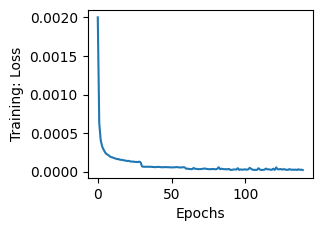

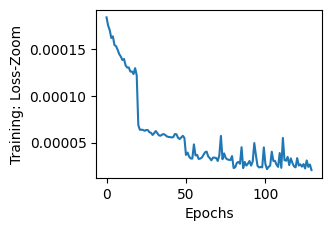

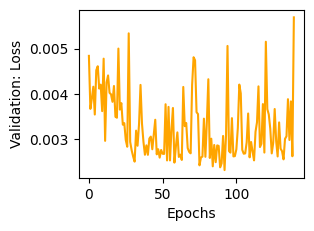

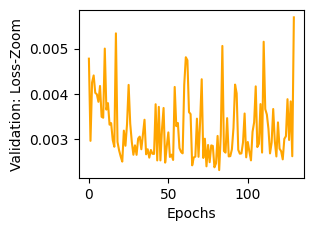

In [29]:
if(TRAIN == True):
    loss_plot = np.concatenate(loss_plot)
    val_loss_plot = np.concatenate(val_loss_plot)
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Training: Loss')
    plt.figure()
    plt.subplot(2,2,2)
    plt.plot(loss_plot[10:])
    plt.xlabel('Epochs')
    plt.ylabel('Training: Loss-Zoom')
    plt.figure()
    plt.subplot(2,2,3)
    plt.plot(val_loss_plot, color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Validation: Loss')
    plt.figure()
    plt.subplot(2,2,4)
    plt.plot(val_loss_plot[10:], color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Validation: Loss-Zoom')
    plt.show()
else:
    print("Training deactivated!")

# Convert model to tfLite model 

In [30]:
# Optimization strategies:
# https://ai.google.dev/edge/litert/models/model_optimization?hl=de
# Tensorflow API: 
# https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter


models = [MODEL_TF_KERAS]
MODEL_TF_LITE = MODEL_TF + MODEL_NAME + ".tflite"
MODEL_TF_LITE_QUANTIZATION = MODEL_TF + MODEL_NAME + "_QUANT.tflite"
# Restricting the model to integers (8-bit) only might be too limiting
strategies = ["Dynamic_range_quantization", "Float16_quantization", "Integer_with_float_fallback", "Integer_only", "Integer_only:16-bit_activations_with_8-bits_weights"]
strat = "Dynamic_range_quantization"

def representative_dataset():
  # Changing dataset_size might be helpful
  dataset_size = 300000
  for data in X_test[:dataset_size]:
    # Expand dimension to include batch size
    yield [np.expand_dims(data, axis=0).astype(np.float32)]

if(CONVERT_MODEL):
    # Convert .keras model to tfLite model 
    model = tf.keras.models.load_model(MODEL_TF_KERAS)
    converter = tf.lite.TFLiteConverter.from_keras_model(model) 
    tflite_model = converter.convert() 
    with open(MODEL_TF_LITE, 'wb') as file:
        file.write(tflite_model)

    models.append(MODEL_TF_LITE)
    size_tf = os.path.getsize(MODEL_TF_KERAS)
    size_tflite = os.path.getsize(MODEL_TF_LITE)
    # Convert .keras model to tfLite model and use quantization
    if(QUANTIZE_MODEL == True):
        # Convert .keras model to tfLite model 
        model = tf.keras.models.load_model(MODEL_TF_KERAS)
        converter = tf.lite.TFLiteConverter.from_keras_model(model) 
        # Dynamic range quantization (if strat == strategies[0])
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # Float16 quantization
        if(strat == strategies[1]):
            converter.target_spec.supported_types = [tf.float16]
        # Integer with float fallback
        elif(strat == strategies[2]):
            converter.representative_dataset = representative_dataset
        # Integer_only
        elif(strat == strategies[3]):
            converter.representative_dataset = representative_dataset
            converter.representative_dataset
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8
        # Integer only: 16-bit activations with 8-bits weights
        elif(strat == strategies[4]):
            converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]

        tflite_quant_model = converter.convert()
        with open(MODEL_TF_LITE_QUANTIZATION, 'wb') as file:
            file.write(tflite_quant_model)
        models.append(MODEL_TF_LITE_QUANTIZATION)
        size_quant_tflite = os.path.getsize(MODEL_TF_LITE_QUANTIZATION)
else: 
    print("Model conversion deactivated!")
    if(USE_QUANTIZED_MODELS):
        if(os.path.exists(MODEL_TF_LITE) and os.path.exists(MODEL_TF_LITE_QUANTIZATION)):
            models.append(MODEL_TF_LITE)
            models.append(MODEL_TF_LITE_QUANTIZATION)
        else:
            print("Models must be generated first!")
    else:
        print("Prediction with previously generated quantized models deactivated")

INFO:tensorflow:Assets written to: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmp5r7kqvur/assets


INFO:tensorflow:Assets written to: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmp5r7kqvur/assets
2025-09-17 18:32:15.920014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-17 18:32:15.920026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-09-17 18:32:15.922157: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmp5r7kqvur
2025-09-17 18:32:15.923951: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-09-17 18:32:15.923956: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmp5r7kqvur
2025-09-17 18:32:15.929048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-09-17 18:32:15.930989: I tensorflow/cc/saved_model/load

INFO:tensorflow:Assets written to: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmpkarebsit/assets


INFO:tensorflow:Assets written to: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmpkarebsit/assets
2025-09-17 18:32:17.174653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-17 18:32:17.174664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-09-17 18:32:17.174772: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmpkarebsit
2025-09-17 18:32:17.176554: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-09-17 18:32:17.176559: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/3w/1wph7gw902zgkzp0cv3s8vq80000gn/T/tmpkarebsit
2025-09-17 18:32:17.181625: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-09-17 18:32:17.243809: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

In [31]:
if(CONVERT_MODEL == True):
    if(QUANTIZE_MODEL == True):         
        print(f"Tensorflow = {size_tf} bytes, Tflite = {size_tflite} bytes, Tflite_Quantization = {size_quant_tflite} bytes")
    else:
        print(f"Tensorflow = {size_tf} bytes, Tflite = {size_tflite} bytes")
else:
    print("Model conversion deactivated!")

print(models)

Tensorflow = 945050 bytes, Tflite = 288340 bytes, Tflite_Quantization = 77712 bytes
['models/Model_111_FCNN_v4/Model_111_FCNN.keras', 'models/Model_111_FCNN_v4/Model_111_FCNN.tflite', 'models/Model_111_FCNN_v4/Model_111_FCNN_QUANT.tflite']


# Predict Temperatures of Test-Dataset

In [32]:
# Inference of tf_lite model: https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter
prediction_list_test = list()

# Testing of quantized models is currently not supported
if(start_temp == True):
    pos_end = 0
    pos_start = 0
    prediction_list_test.append(list())
    for kk in range(len(list_data_x_test)):
        if(start_temp == True):
            pos_end = len(list_data_x_test[kk])
            prediction_list_test[-1].append(model.predict({"Input_Block": list_data_x_test[kk], "Start_Temp": list_start_temp_test[pos_start:pos_start + pos_end]}))
            pos_start = pos_end
else: 
    for i, model_path in enumerate(models):
        print('Model: ', model_path)
        prediction_list_test.append(list())
        if(i == 0):
            model = tf.keras.models.load_model(model_path)
        else: 
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            print(input_details)
            if(strat == strategies[3] and i == 2):
                input_scale, input_zero_point = input_details[0]["quantization"]
                print("Input scale:", input_scale)
                print("Input zero point:", input_zero_point)
            output_details = interpreter.get_output_details()
        for kk in range(len(list_data_x_test)):
            if(i == 0):
                if(MATLAB_COMPATIBLE_MODEL == True):
                    prediction_list_test[-1].append(model.predict(list_data_x_test[kk].reshape(list_data_x_test[kk].shape[0], -1)))
                else:   
                    prediction_list_test[-1].append(model.predict(list_data_x_test[kk]))
            else: 
                predictions = []
                for element in list_data_x_test[kk]:
                    if(strat == strategies[3] and i == 2):
                        element = element/input_scale + input_zero_point
                    if(MATLAB_COMPATIBLE_MODEL == True):
                        interpreter.set_tensor(input_details[0]['index'], np.reshape(element, (1, input_details[0]['shape'][1])).astype(input_details[0]['dtype']))
                    else:
                        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(element, axis=0).astype(input_details[0]['dtype']))
                    interpreter.invoke()
                    predictions.append(interpreter.get_tensor(output_details[0]['index']).flatten())
                prediction_list_test[-1].append(np.array(predictions))

Model:  models/Model_111_FCNN_v4/Model_111_FCNN.keras
11/11 [==============================] - 0s 395us/step
Model:  models/Model_111_FCNN_v4/Model_111_FCNN.tflite
[{'name': 'serving_default_features:0', 'index': 0, 'shape': array([  1, 341], dtype=int32), 'shape_signature': array([ -1, 341], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Model:  models/Model_111_FCNN_v4/Model_111_FCNN_QUANT.tflite
[{'name': 'serving_default_features:0', 'index': 0, 'shape': array([  1, 341], dtype=int32), 'shape_signature': array([ -1, 341], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [33]:
ANALYZE=False
if(ANALYZE and CONVERT_MODEL and QUANTIZE_MODEL):
    for frame in range(len(list_data_x_test)):
        plt.figure(figsize=(4, 3))
        plt.plot(prediction_list_test[0][frame], color='red', linewidth=4)
        plt.plot(prediction_list_test[1][frame], color='blue')
        plt.plot(prediction_list_test[2][frame], color='green')
        plt.show
else:
    print("Inactive!")

Inactive!


# Plot Results
# Rebuild from Delta-Temperature to absolute Temperature if necessary
# Rescale Scaled Temperature if necessary


361
------------------------------------
Number:  0
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_47.csv


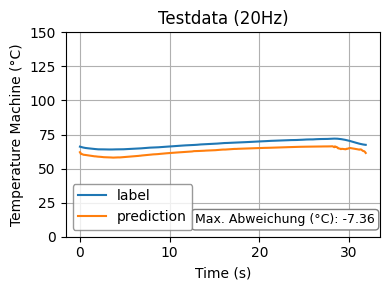

------------------------------------
------------------------------------
Number:  1
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_53.csv


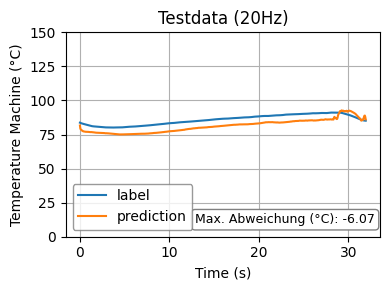

------------------------------------
------------------------------------
Number:  2
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_84.csv


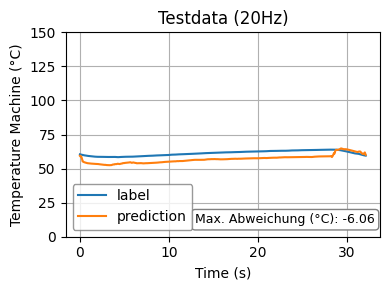

------------------------------------
------------------------------------
Number:  3
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_90.csv


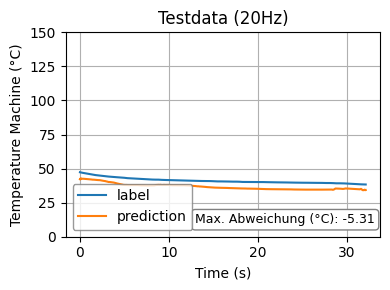

------------------------------------
------------------------------------
Number:  4
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_91.csv


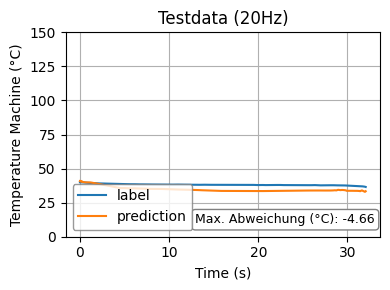

------------------------------------
------------------------------------
Number:  5
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_85.csv


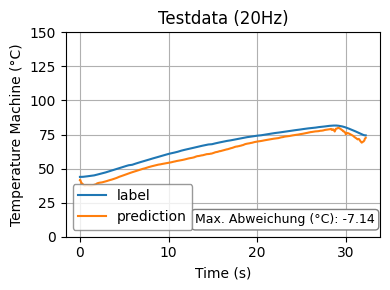

------------------------------------
------------------------------------
Number:  6
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_52.csv


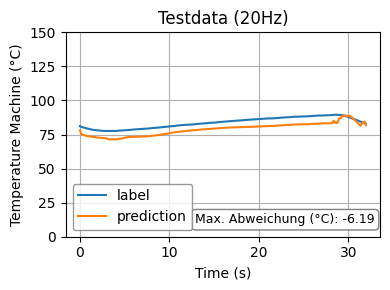

------------------------------------
------------------------------------
Number:  7
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_46.csv


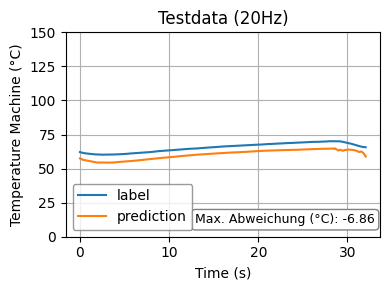

------------------------------------
------------------------------------
Number:  8
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_50.csv


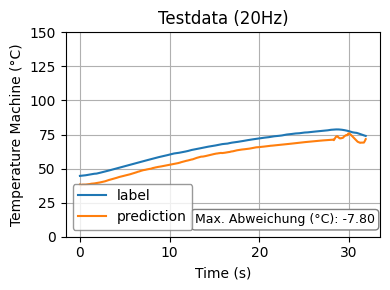

------------------------------------
------------------------------------
Number:  9
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_44.csv


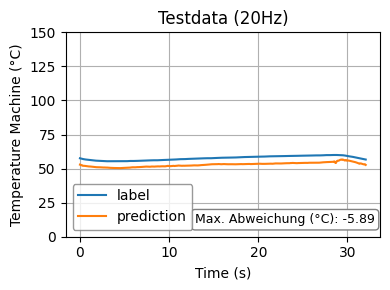

------------------------------------
------------------------------------
Number:  10
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_78.csv


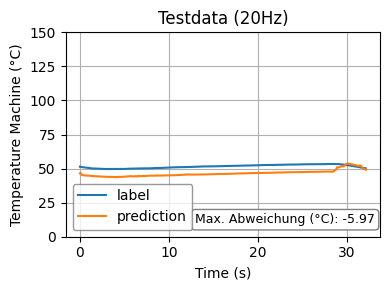

------------------------------------
------------------------------------
Number:  11
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_93.csv


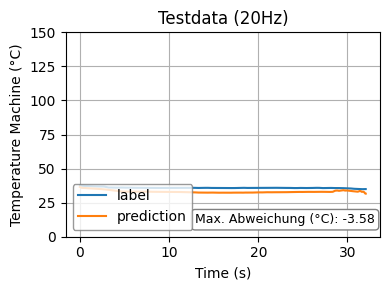

------------------------------------
------------------------------------
Number:  12
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_87.csv


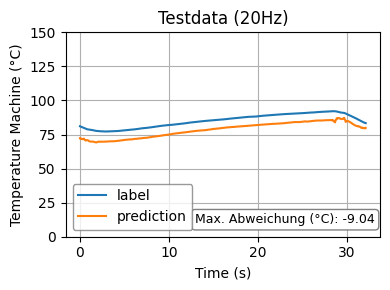

------------------------------------
------------------------------------
Number:  13
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_86.csv


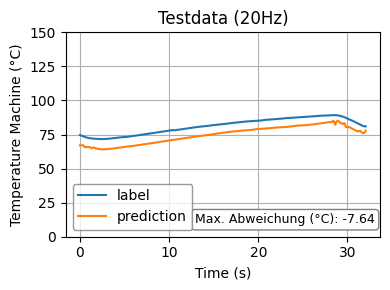

------------------------------------
------------------------------------
Number:  14
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_92.csv


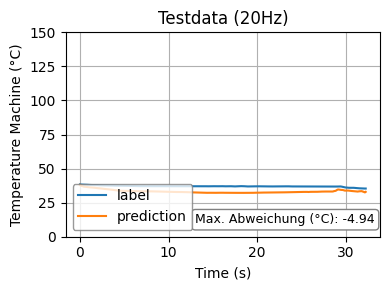

------------------------------------
------------------------------------
Number:  15
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_79.csv


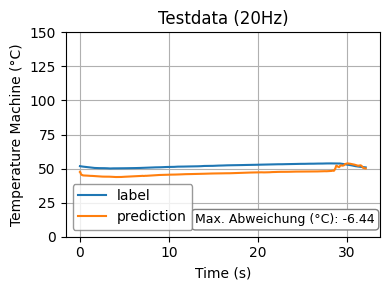

------------------------------------
------------------------------------
Number:  16
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_45.csv


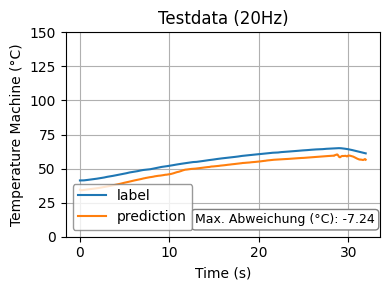

------------------------------------
------------------------------------
Number:  17
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_51.csv


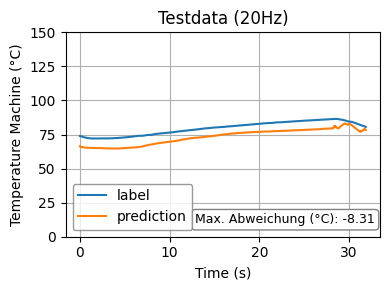

------------------------------------
------------------------------------
Number:  18
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_69.csv


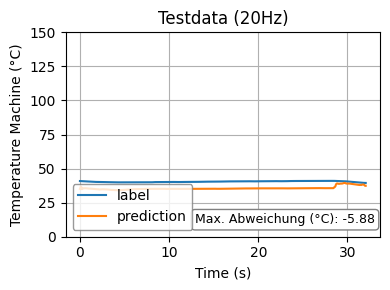

------------------------------------
------------------------------------
Number:  19
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_55.csv


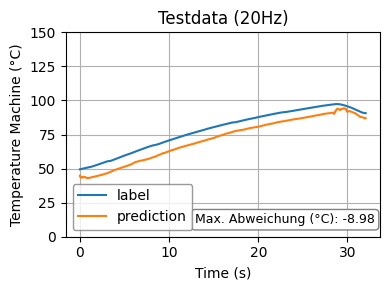

------------------------------------
------------------------------------
Number:  20
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_41.csv


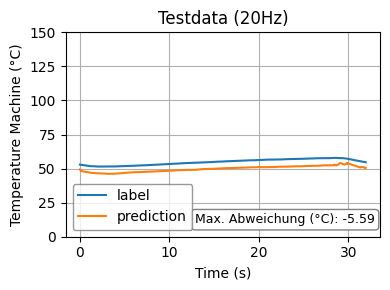

------------------------------------
------------------------------------
Number:  21
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_96.csv


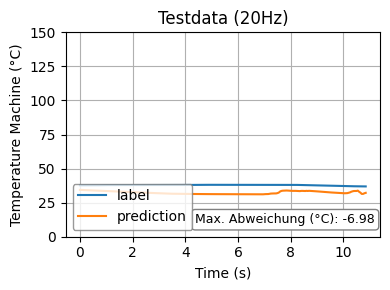

------------------------------------
------------------------------------
Number:  22
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_82.csv


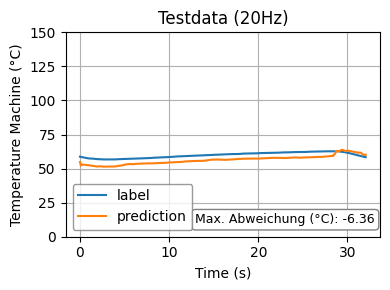

------------------------------------
------------------------------------
Number:  23
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_83.csv


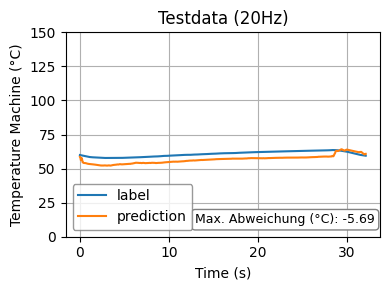

------------------------------------
------------------------------------
Number:  24
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_97.csv


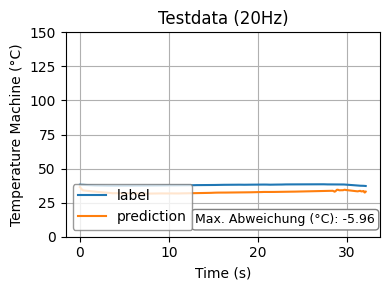

------------------------------------
------------------------------------
Number:  25
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_40.csv


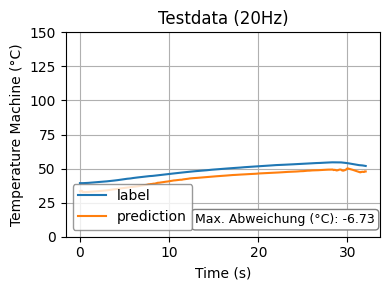

------------------------------------
------------------------------------
Number:  26
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_54.csv


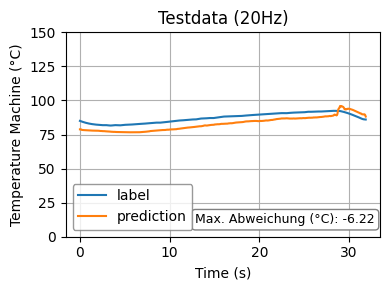

------------------------------------
------------------------------------
Number:  27
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_68.csv


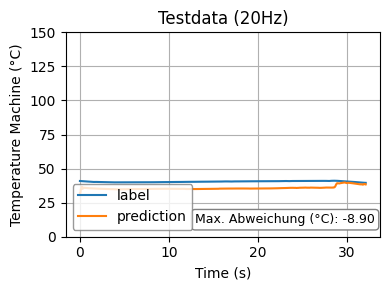

------------------------------------
------------------------------------
Number:  28
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_42.csv


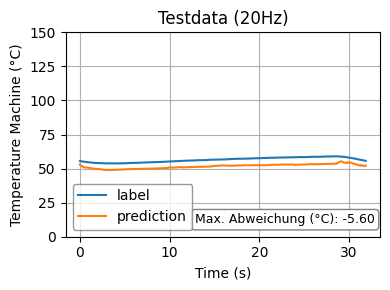

------------------------------------
------------------------------------
Number:  29
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_56.csv


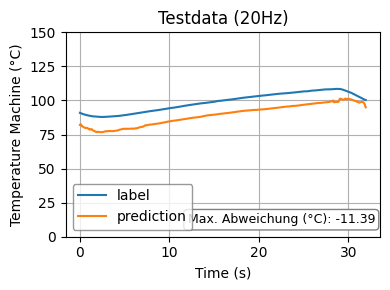

------------------------------------
------------------------------------
Number:  30
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_81.csv


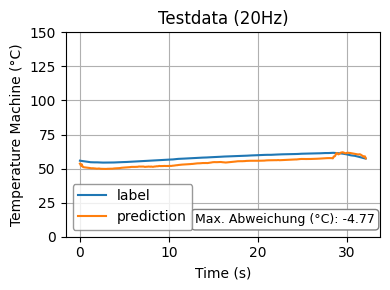

------------------------------------
------------------------------------
Number:  31
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_95.csv


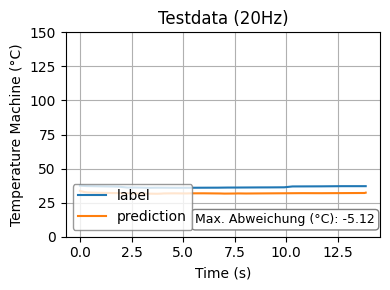

------------------------------------
------------------------------------
Number:  32
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_94.csv


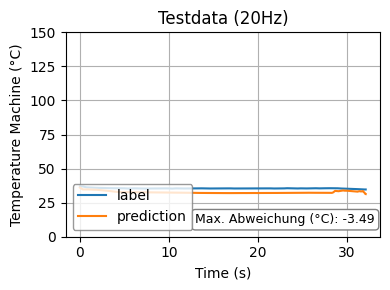

------------------------------------
------------------------------------
Number:  33
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_80.csv


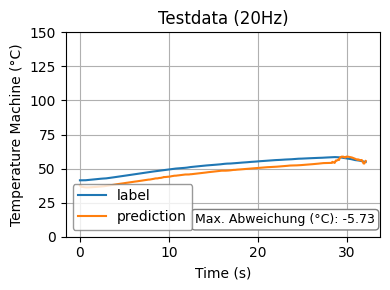

------------------------------------
------------------------------------
Number:  34
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_57.csv


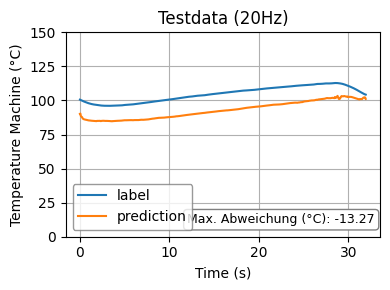

------------------------------------
------------------------------------
Number:  35
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_43.csv


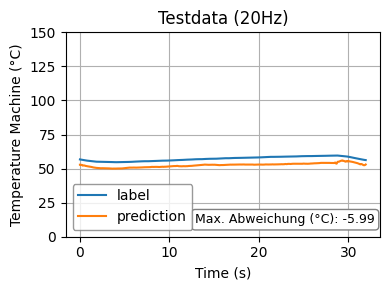

------------------------------------
------------------------------------
Number:  36
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_24.csv


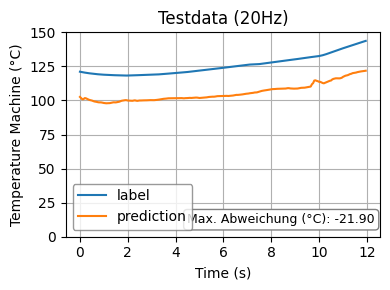

------------------------------------
------------------------------------
Number:  37
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_30.csv


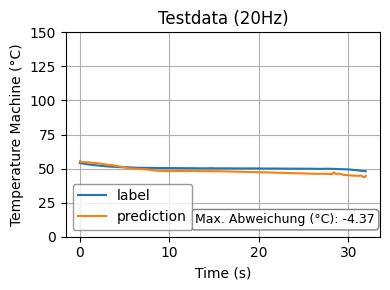

------------------------------------
------------------------------------
Number:  38
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_18.csv


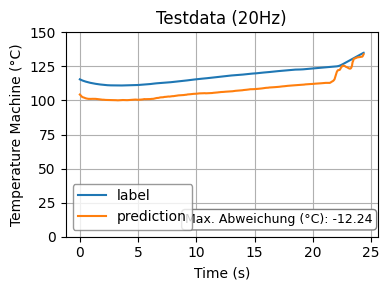

------------------------------------
------------------------------------
Number:  39
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_19.csv


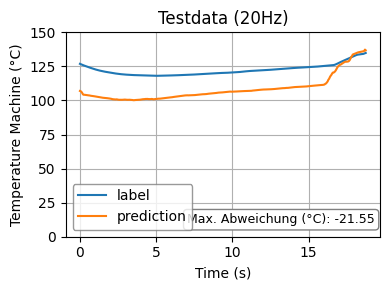

------------------------------------
------------------------------------
Number:  40
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_31.csv


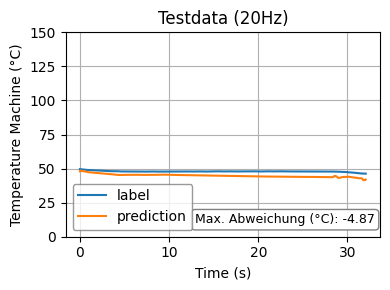

------------------------------------
------------------------------------
Number:  41
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_25.csv


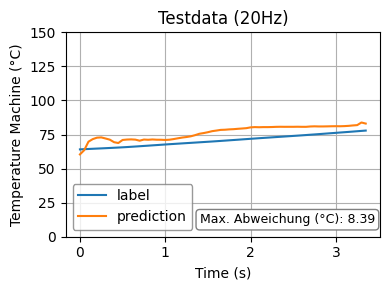

------------------------------------
------------------------------------
Number:  42
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_33.csv


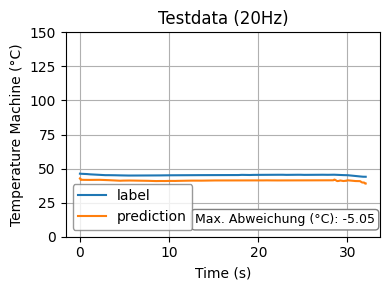

------------------------------------
------------------------------------
Number:  43
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_27.csv


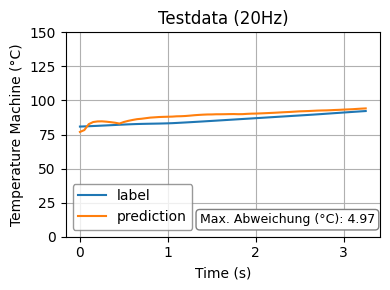

------------------------------------
------------------------------------
Number:  44
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_118.csv


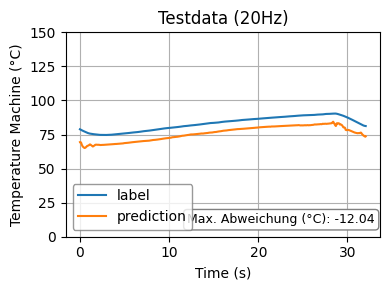

------------------------------------
------------------------------------
Number:  45
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_119.csv


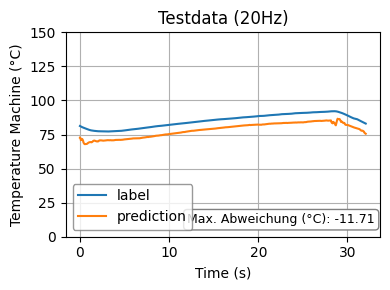

------------------------------------
------------------------------------
Number:  46
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_26.csv


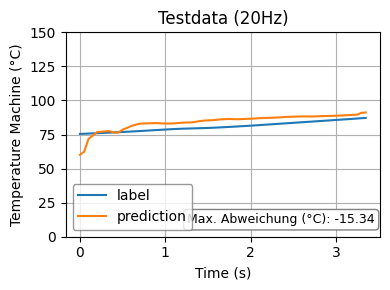

------------------------------------
------------------------------------
Number:  47
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_32.csv


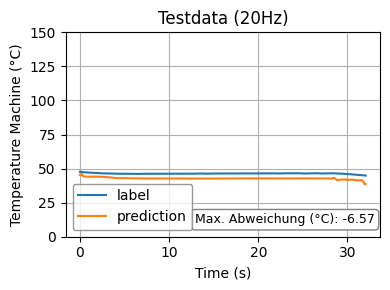

------------------------------------
------------------------------------
Number:  48
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_36.csv


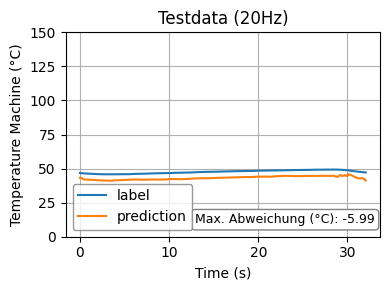

------------------------------------
------------------------------------
Number:  49
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_22.csv


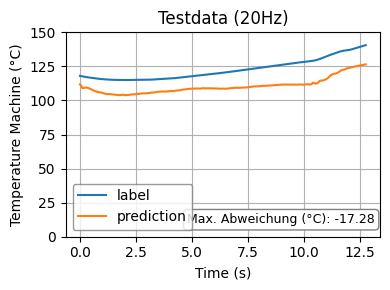

------------------------------------
------------------------------------
Number:  50
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_109.csv


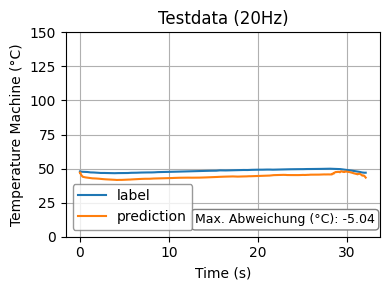

------------------------------------
------------------------------------
Number:  51
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_108.csv


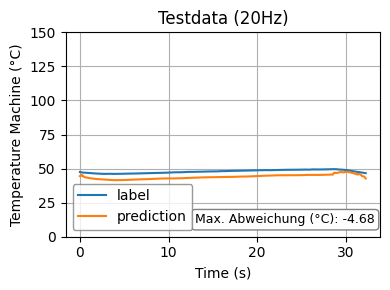

------------------------------------
------------------------------------
Number:  52
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_120.csv


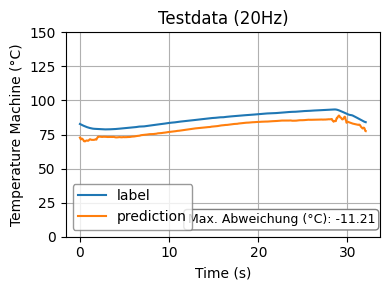

------------------------------------
------------------------------------
Number:  53
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_23.csv


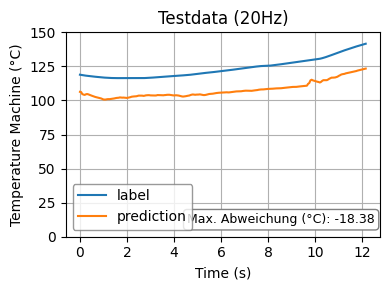

------------------------------------
------------------------------------
Number:  54
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_37.csv


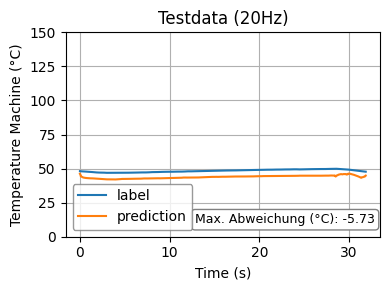

------------------------------------
------------------------------------
Number:  55
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_21.csv


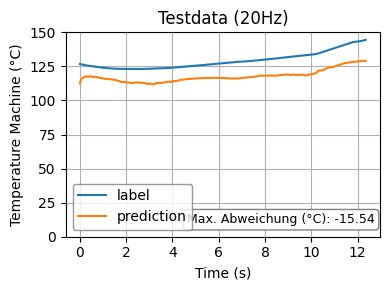

------------------------------------
------------------------------------
Number:  56
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_35.csv


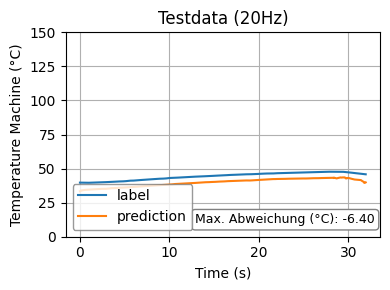

------------------------------------
------------------------------------
Number:  57
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_8.csv


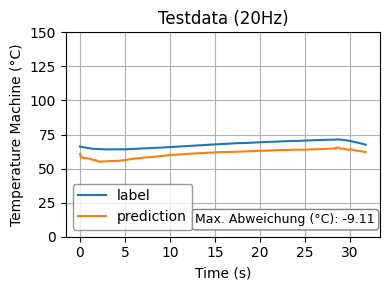

------------------------------------
------------------------------------
Number:  58
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_9.csv


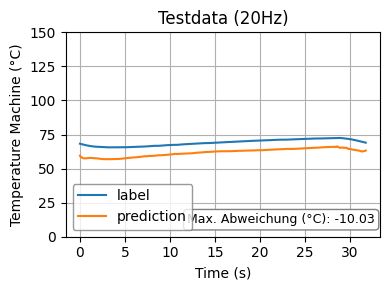

------------------------------------
------------------------------------
Number:  59
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_34.csv


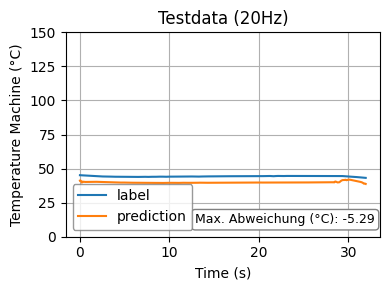

------------------------------------
------------------------------------
Number:  60
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_20.csv


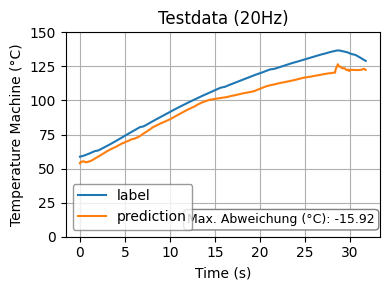

------------------------------------
------------------------------------
Number:  61
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_11.csv


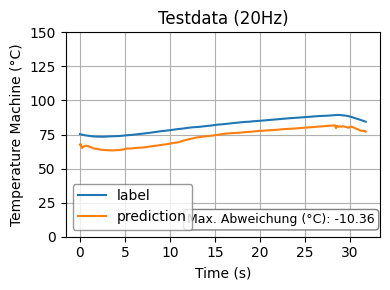

------------------------------------
------------------------------------
Number:  62
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_39.csv


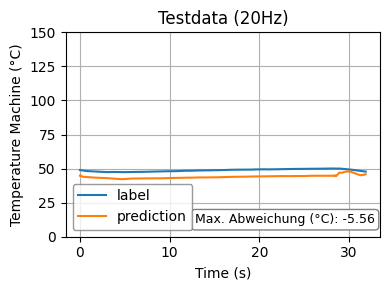

------------------------------------
------------------------------------
Number:  63
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_4.csv


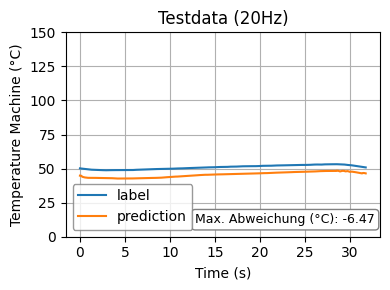

------------------------------------
------------------------------------
Number:  64
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_112.csv


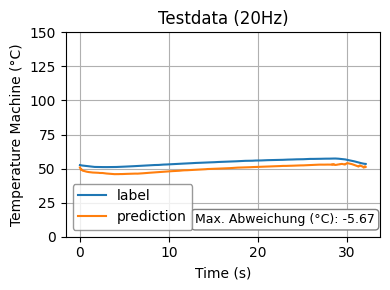

------------------------------------
------------------------------------
Number:  65
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_106.csv


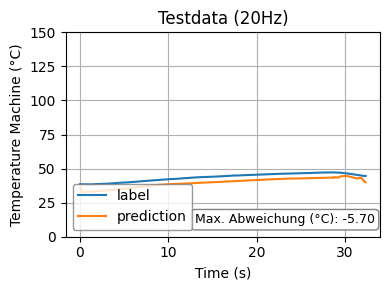

------------------------------------
------------------------------------
Number:  66
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_107.csv


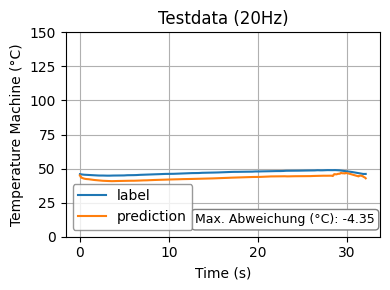

------------------------------------
------------------------------------
Number:  67
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_113.csv


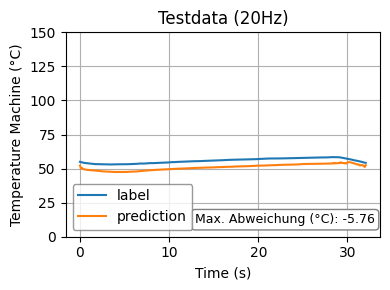

------------------------------------
------------------------------------
Number:  68
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_5.csv


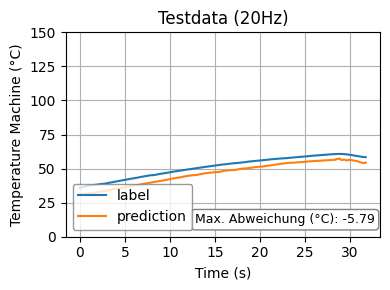

------------------------------------
------------------------------------
Number:  69
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_38.csv


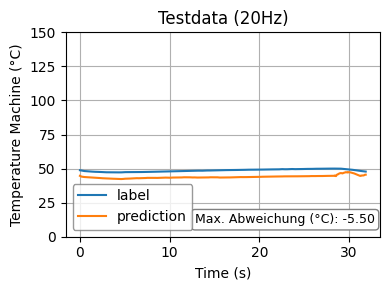

------------------------------------
------------------------------------
Number:  70
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_10.csv


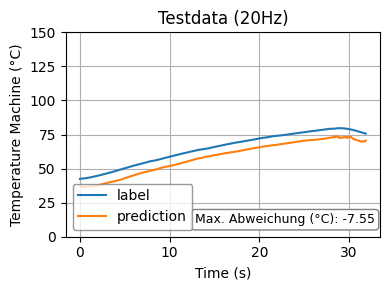

------------------------------------
------------------------------------
Number:  71
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_12.csv


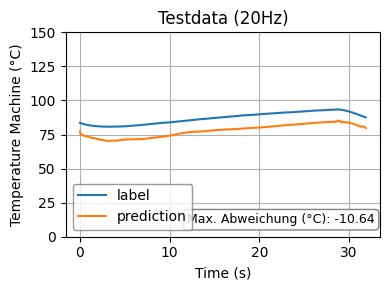

------------------------------------
------------------------------------
Number:  72
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_7.csv


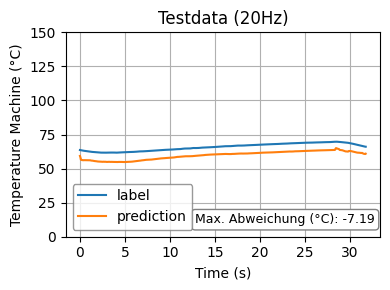

------------------------------------
------------------------------------
Number:  73
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_105.csv


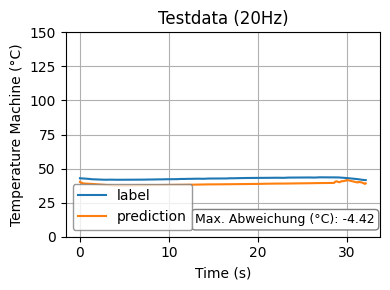

------------------------------------
------------------------------------
Number:  74
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_111.csv


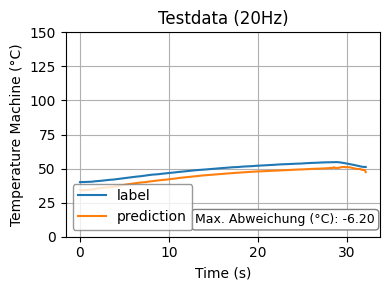

------------------------------------
------------------------------------
Number:  75
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_110.csv


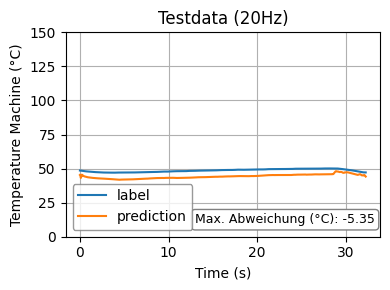

------------------------------------
------------------------------------
Number:  76
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_104.csv


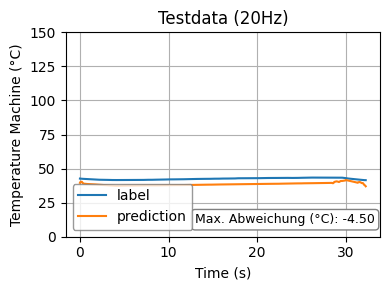

------------------------------------
------------------------------------
Number:  77
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_6.csv


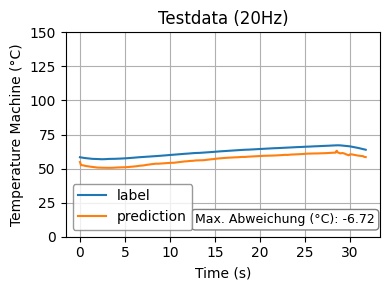

------------------------------------
------------------------------------
Number:  78
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_13.csv


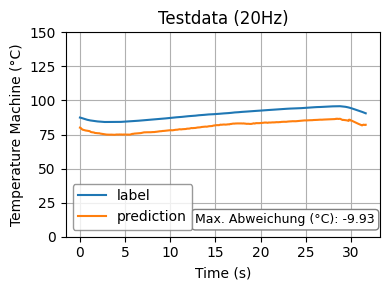

------------------------------------
------------------------------------
Number:  79
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_17.csv


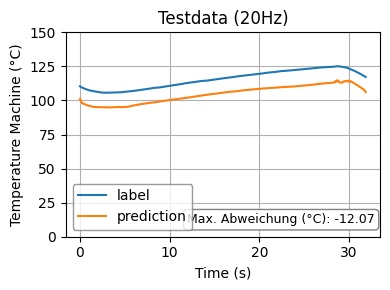

------------------------------------
------------------------------------
Number:  80
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_2.csv


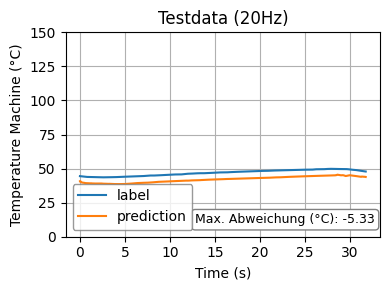

------------------------------------
------------------------------------
Number:  81
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_100.csv


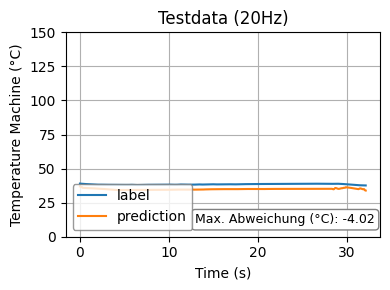

------------------------------------
------------------------------------
Number:  82
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_114.csv


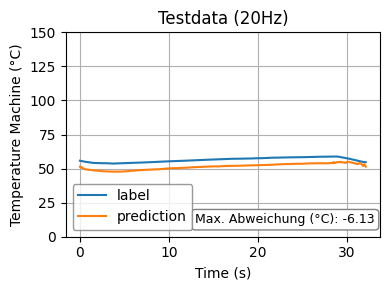

------------------------------------
------------------------------------
Number:  83
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_115.csv


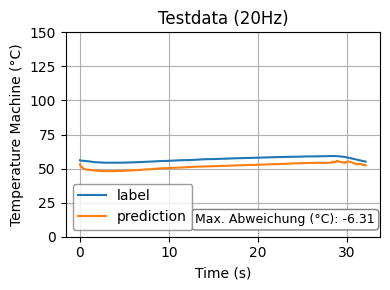

------------------------------------
------------------------------------
Number:  84
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_101.csv


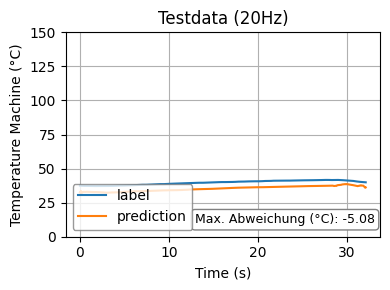

------------------------------------
------------------------------------
Number:  85
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_3.csv


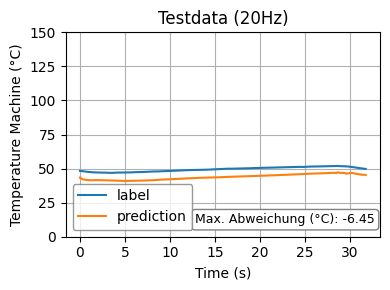

------------------------------------
------------------------------------
Number:  86
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_16.csv


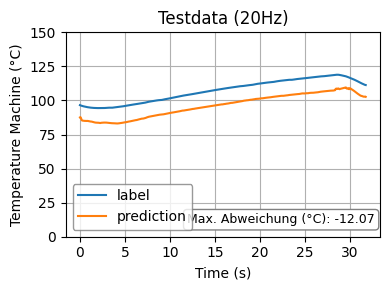

------------------------------------
------------------------------------
Number:  87
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_28.csv


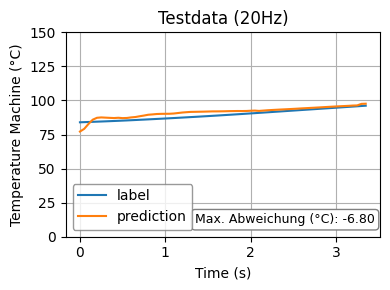

------------------------------------
------------------------------------
Number:  88
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_14.csv


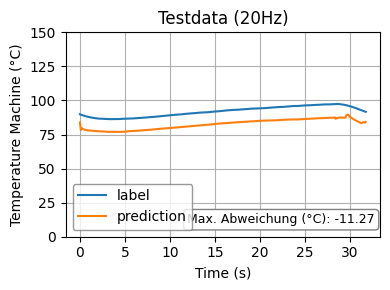

------------------------------------
------------------------------------
Number:  89
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_1.csv


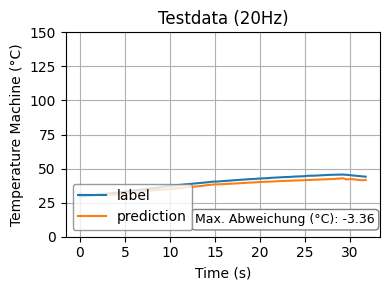

------------------------------------
------------------------------------
Number:  90
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_117.csv


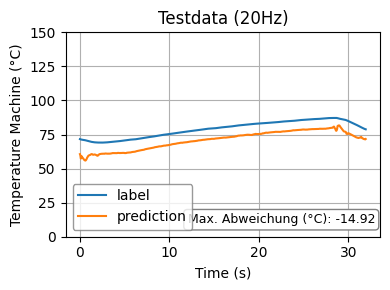

------------------------------------
------------------------------------
Number:  91
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_103.csv


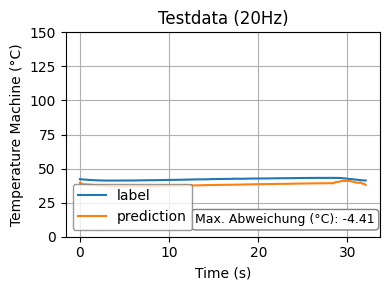

------------------------------------
------------------------------------
Number:  92
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_102.csv


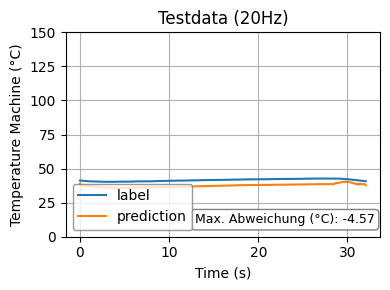

------------------------------------
------------------------------------
Number:  93
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_116.csv


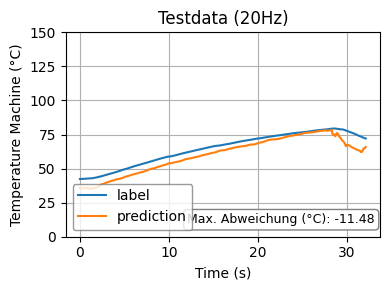

------------------------------------
------------------------------------
Number:  94
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_0.csv


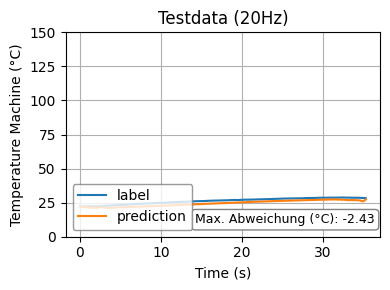

------------------------------------
------------------------------------
Number:  95
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_15.csv


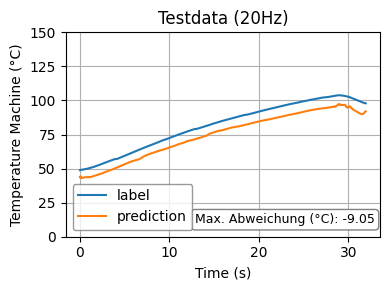

------------------------------------
------------------------------------
Number:  96
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_29.csv


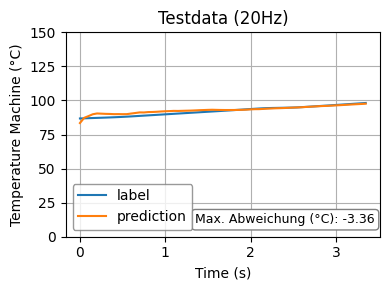

------------------------------------
------------------------------------
Number:  97
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_66.csv


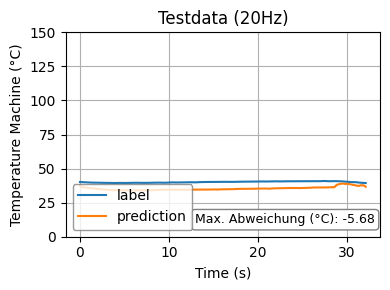

------------------------------------
------------------------------------
Number:  98
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_72.csv


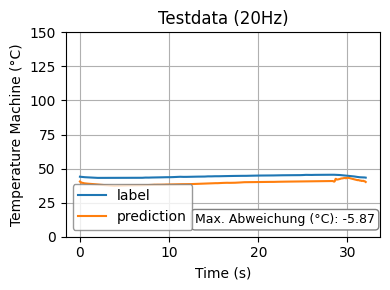

------------------------------------
------------------------------------
Number:  99
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_99.csv


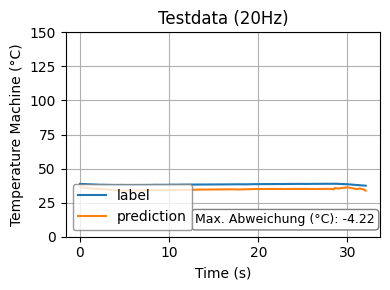

------------------------------------
------------------------------------
Number:  100
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_98.csv


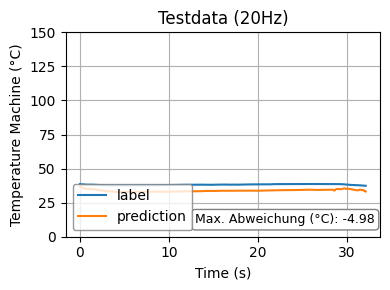

------------------------------------
------------------------------------
Number:  101
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_73.csv


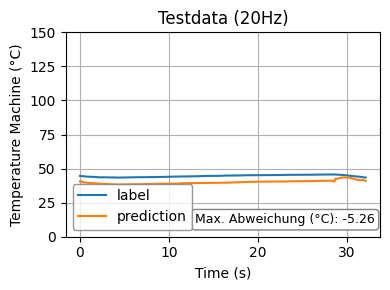

------------------------------------
------------------------------------
Number:  102
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_67.csv


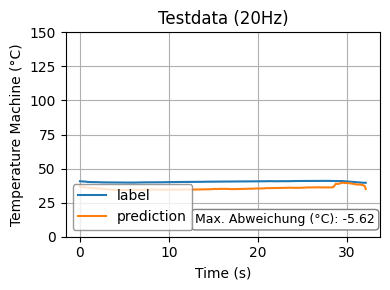

------------------------------------
------------------------------------
Number:  103
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_71.csv


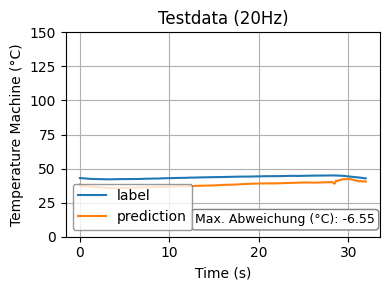

------------------------------------
------------------------------------
Number:  104
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_65.csv


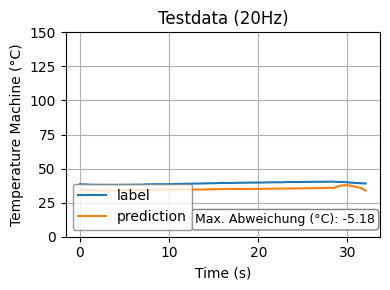

------------------------------------
------------------------------------
Number:  105
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_59.csv


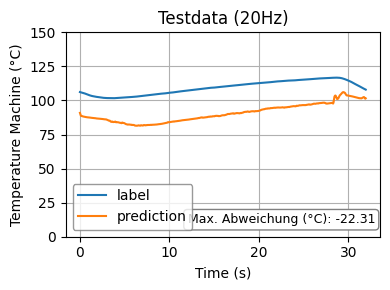

------------------------------------
------------------------------------
Number:  106
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_58.csv


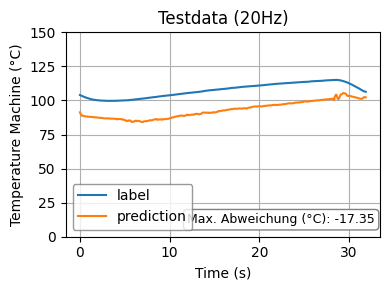

------------------------------------
------------------------------------
Number:  107
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_64.csv


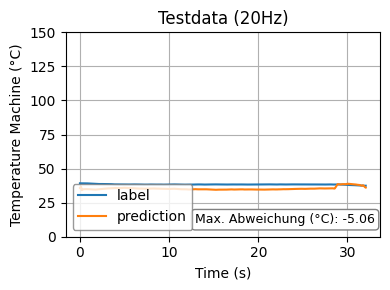

------------------------------------
------------------------------------
Number:  108
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_70.csv


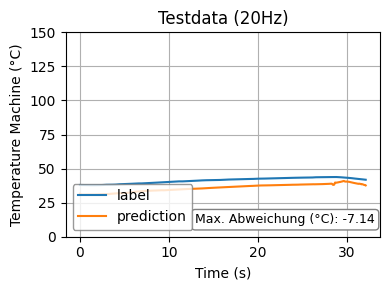

------------------------------------
------------------------------------
Number:  109
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_48.csv


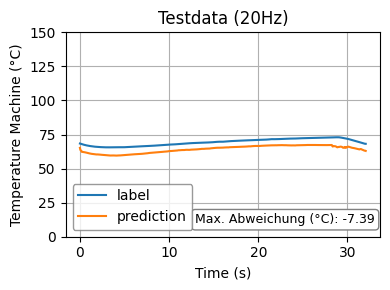

------------------------------------
------------------------------------
Number:  110
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_74.csv


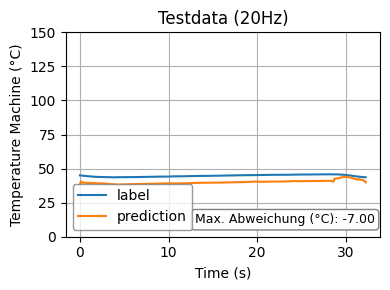

------------------------------------
------------------------------------
Number:  111
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_60.csv


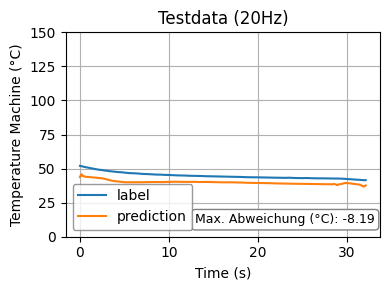

------------------------------------
------------------------------------
Number:  112
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_61.csv


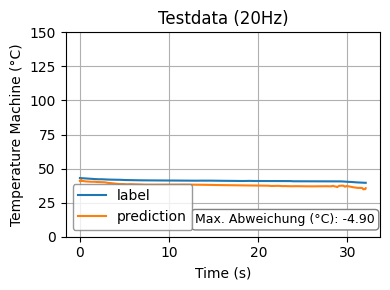

------------------------------------
------------------------------------
Number:  113
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_75.csv


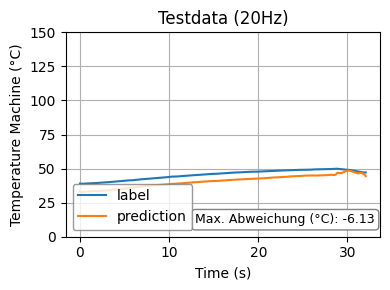

------------------------------------
------------------------------------
Number:  114
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_49.csv


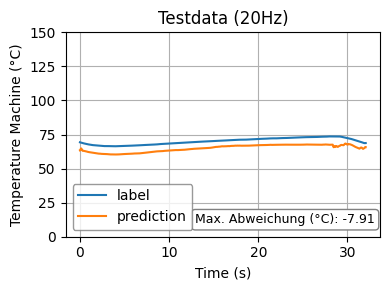

------------------------------------
------------------------------------
Number:  115
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_63.csv


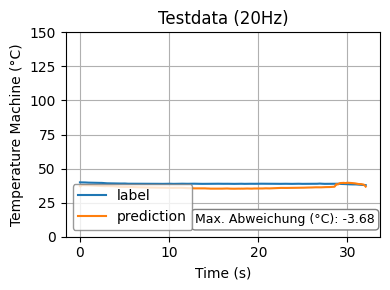

------------------------------------
------------------------------------
Number:  116
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_77.csv


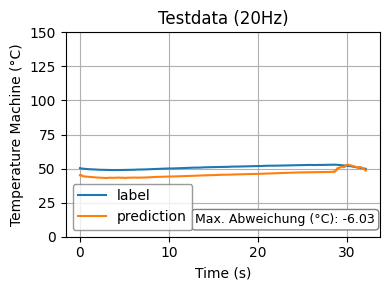

------------------------------------
------------------------------------
Number:  117
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_88.csv


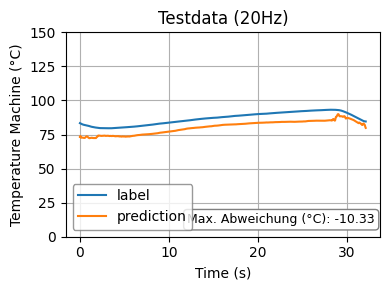

------------------------------------
------------------------------------
Number:  118
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_89.csv


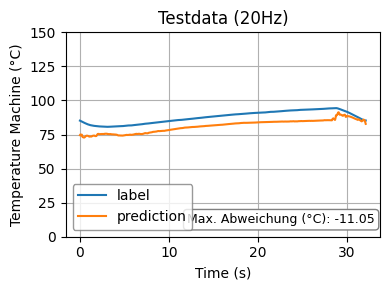

------------------------------------
------------------------------------
Number:  119
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_76.csv


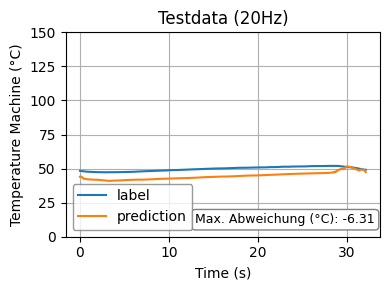

------------------------------------
------------------------------------
Number:  120
../data/test/LA01BT1052_14_Kennfeld_30sec_Last_20H_intensity/LA01BT1052_14_Kennfeld_30sec_Last_20Hz_62.csv


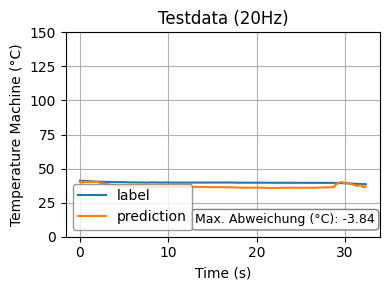

------------------------------------
------------------------------------
Number:  121
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_12.csv


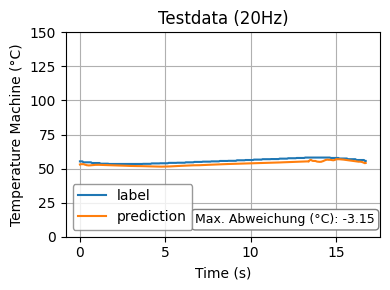

------------------------------------
------------------------------------
Number:  122
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_9.csv


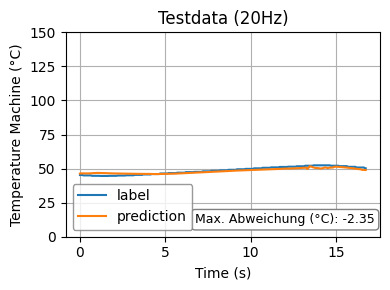

------------------------------------
------------------------------------
Number:  123
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_8.csv


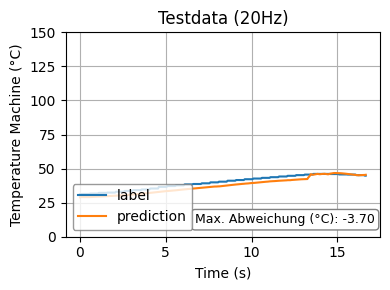

------------------------------------
------------------------------------
Number:  124
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_13.csv


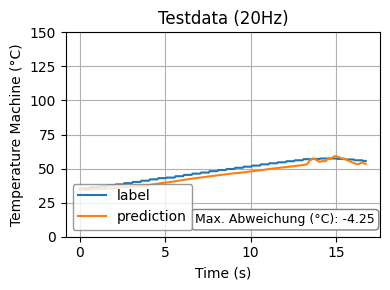

------------------------------------
------------------------------------
Number:  125
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_11.csv


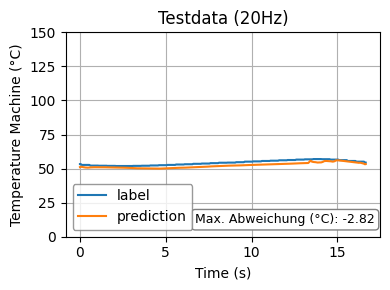

------------------------------------
------------------------------------
Number:  126
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_39.csv


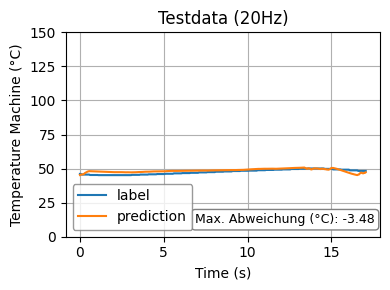

------------------------------------
------------------------------------
Number:  127
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_38.csv


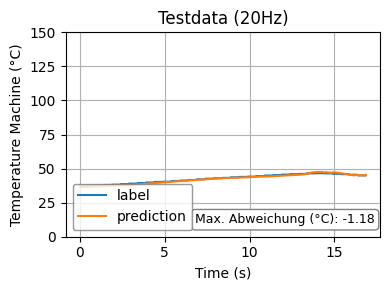

------------------------------------
------------------------------------
Number:  128
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_10.csv


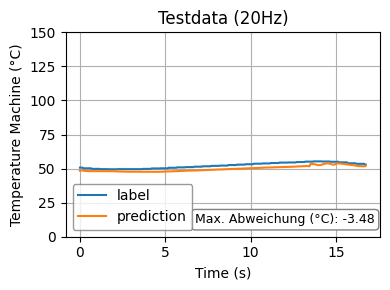

------------------------------------
------------------------------------
Number:  129
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_28.csv


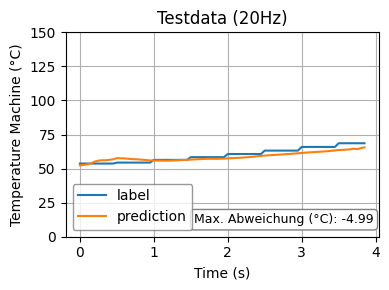

------------------------------------
------------------------------------
Number:  130
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_14.csv


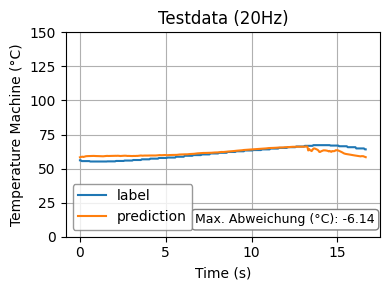

------------------------------------
------------------------------------
Number:  131
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_15.csv


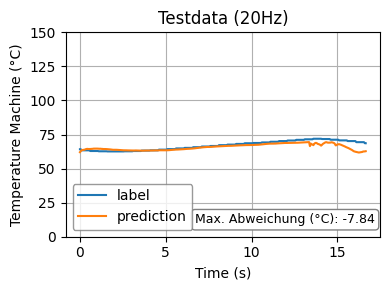

------------------------------------
------------------------------------
Number:  132
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_29.csv


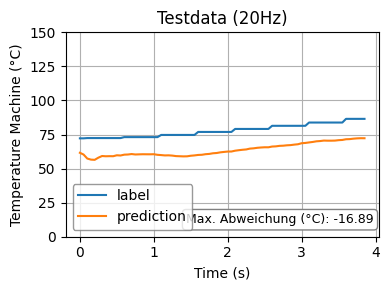

------------------------------------
------------------------------------
Number:  133
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_17.csv


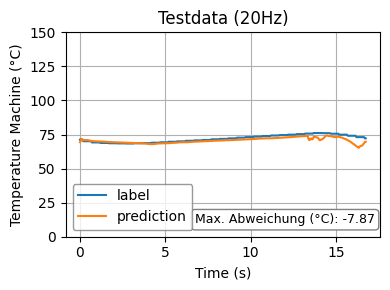

------------------------------------
------------------------------------
Number:  134
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_16.csv


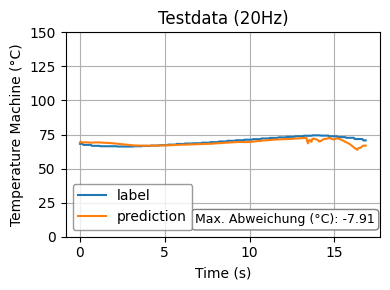

------------------------------------
------------------------------------
Number:  135
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_65.csv


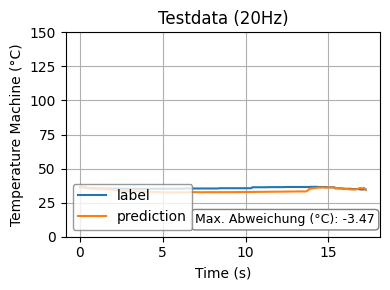

------------------------------------
------------------------------------
Number:  136
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_71.csv


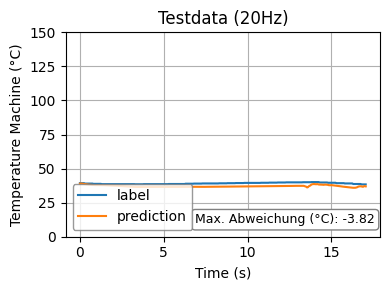

------------------------------------
------------------------------------
Number:  137
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_59.csv


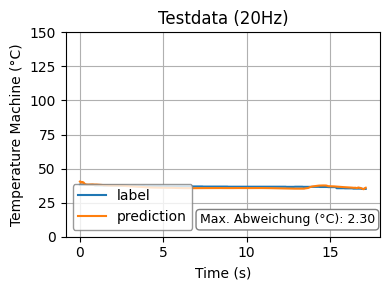

------------------------------------
------------------------------------
Number:  138
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_58.csv


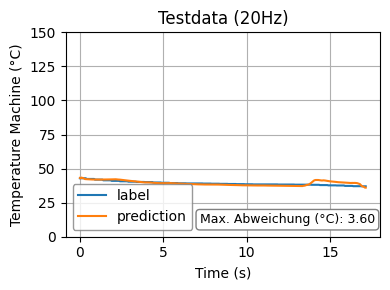

------------------------------------
------------------------------------
Number:  139
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_70.csv


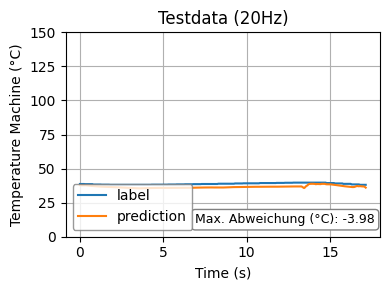

------------------------------------
------------------------------------
Number:  140
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_64.csv


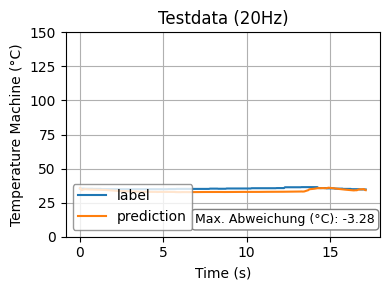

------------------------------------
------------------------------------
Number:  141
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_72.csv


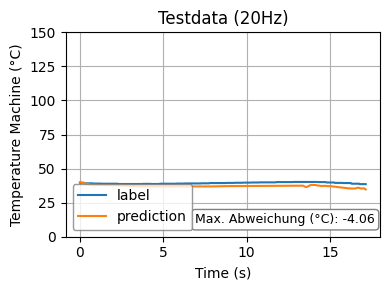

------------------------------------
------------------------------------
Number:  142
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_66.csv


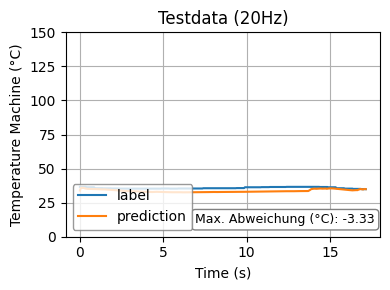

------------------------------------
------------------------------------
Number:  143
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_99.csv


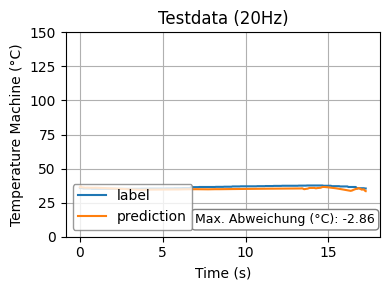

------------------------------------
------------------------------------
Number:  144
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_98.csv


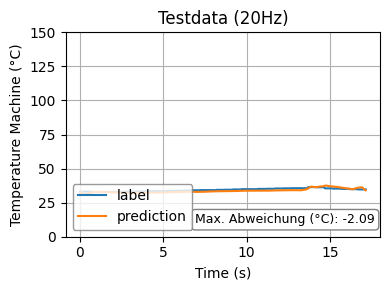

------------------------------------
------------------------------------
Number:  145
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_67.csv


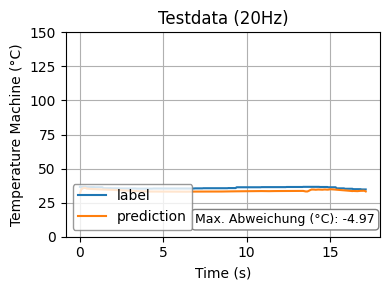

------------------------------------
------------------------------------
Number:  146
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_73.csv


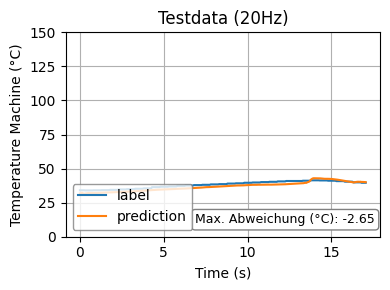

------------------------------------
------------------------------------
Number:  147
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_77.csv


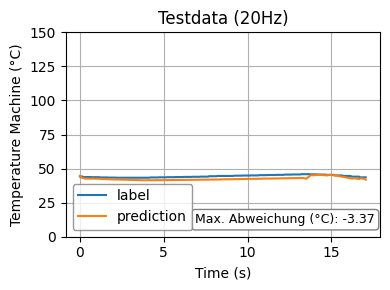

------------------------------------
------------------------------------
Number:  148
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_63.csv


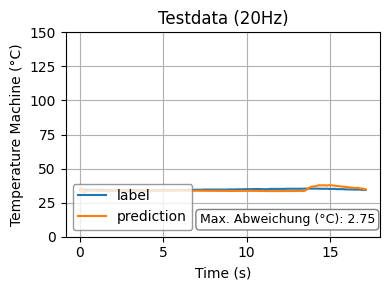

------------------------------------
------------------------------------
Number:  149
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_88.csv


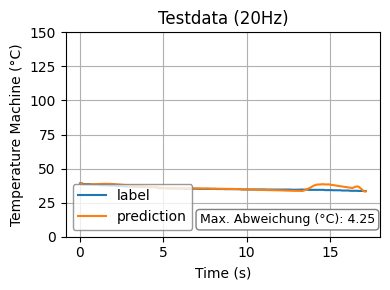

------------------------------------
------------------------------------
Number:  150
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_109.csv


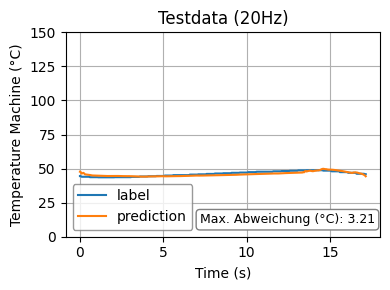

------------------------------------
------------------------------------
Number:  151
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_108.csv


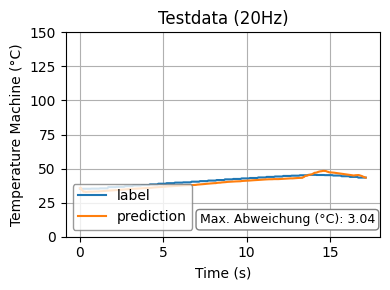

------------------------------------
------------------------------------
Number:  152
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_89.csv


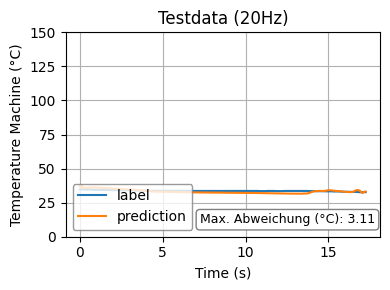

------------------------------------
------------------------------------
Number:  153
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_62.csv


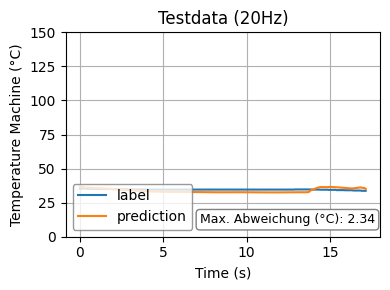

------------------------------------
------------------------------------
Number:  154
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_76.csv


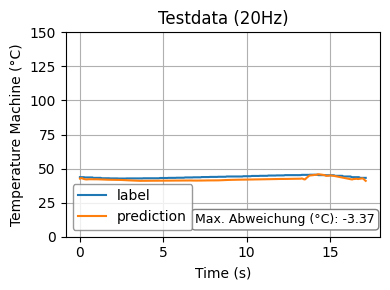

------------------------------------
------------------------------------
Number:  155
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_48.csv


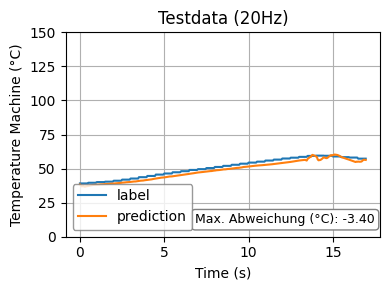

------------------------------------
------------------------------------
Number:  156
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_60.csv


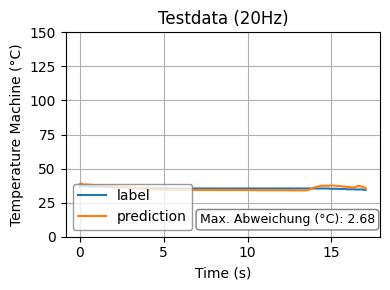

------------------------------------
------------------------------------
Number:  157
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_74.csv


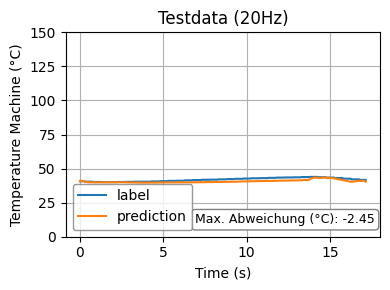

------------------------------------
------------------------------------
Number:  158
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_75.csv


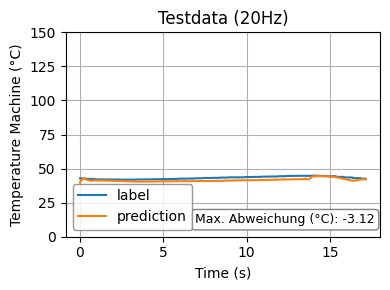

------------------------------------
------------------------------------
Number:  159
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_61.csv


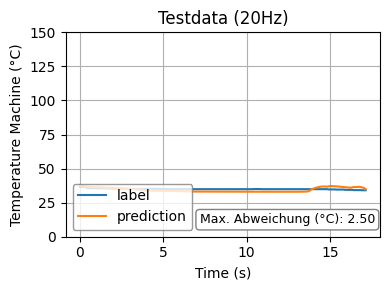

------------------------------------
------------------------------------
Number:  160
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_49.csv


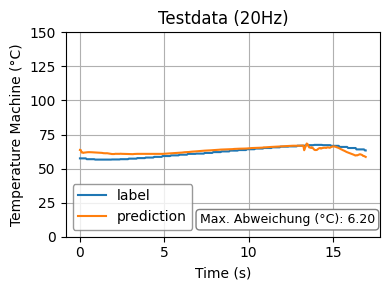

------------------------------------
------------------------------------
Number:  161
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_44.csv


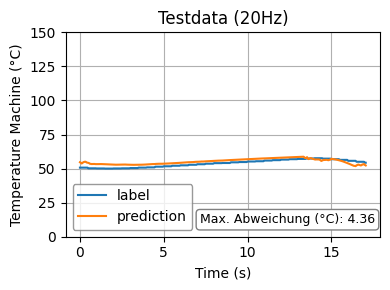

------------------------------------
------------------------------------
Number:  162
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_50.csv


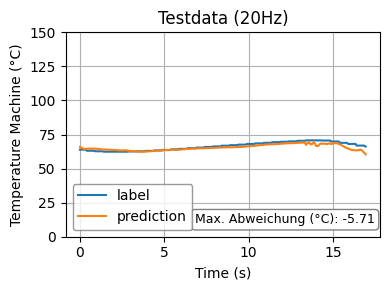

------------------------------------
------------------------------------
Number:  163
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_78.csv


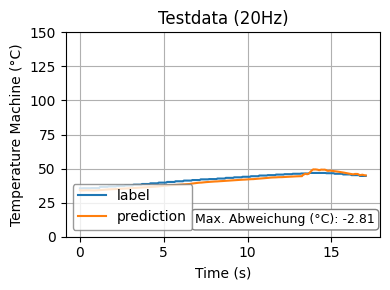

------------------------------------
------------------------------------
Number:  164
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_87.csv


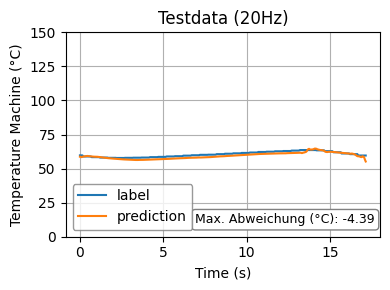

------------------------------------
------------------------------------
Number:  165
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_93.csv


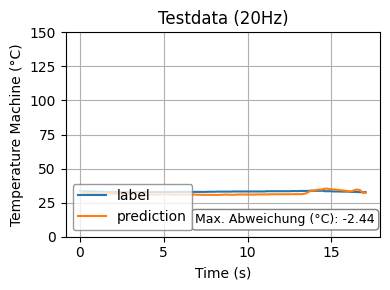

------------------------------------
------------------------------------
Number:  166
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_112.csv


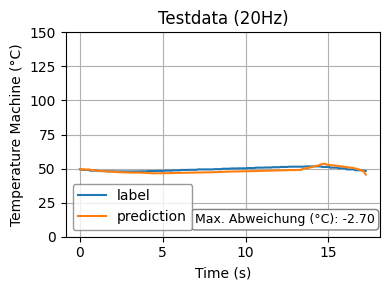

------------------------------------
------------------------------------
Number:  167
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_106.csv


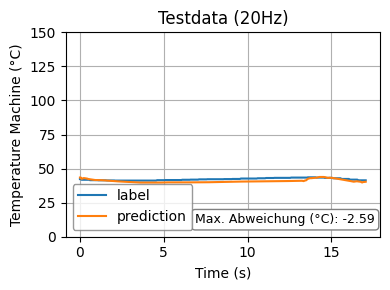

------------------------------------
------------------------------------
Number:  168
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_107.csv


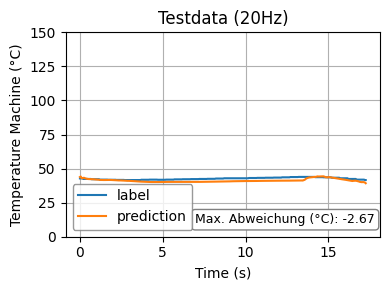

------------------------------------
------------------------------------
Number:  169
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_113.csv


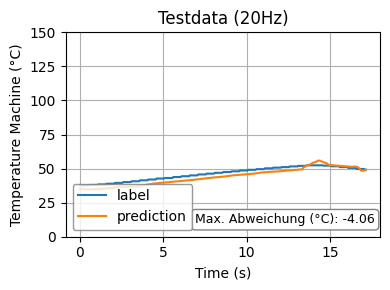

------------------------------------
------------------------------------
Number:  170
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_92.csv


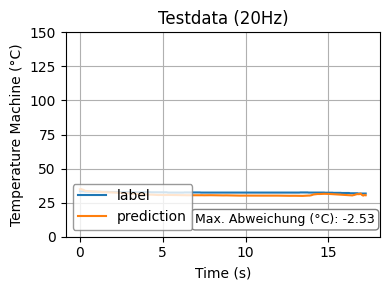

------------------------------------
------------------------------------
Number:  171
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_86.csv


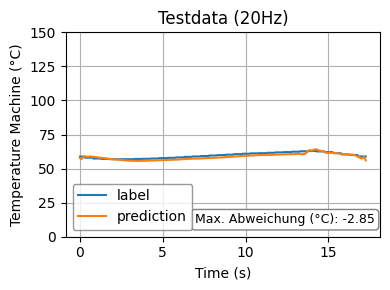

------------------------------------
------------------------------------
Number:  172
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_79.csv


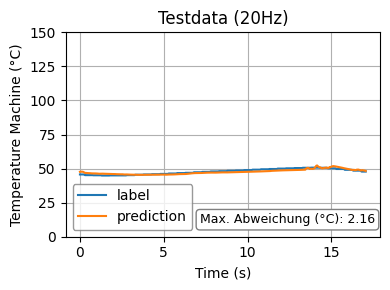

------------------------------------
------------------------------------
Number:  173
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_51.csv


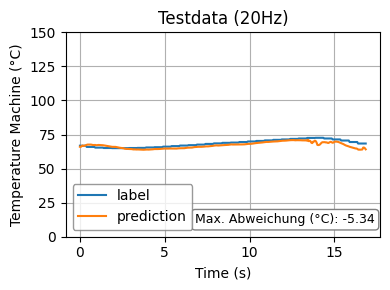

------------------------------------
------------------------------------
Number:  174
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_45.csv


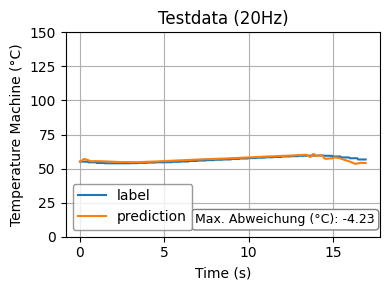

------------------------------------
------------------------------------
Number:  175
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_53.csv


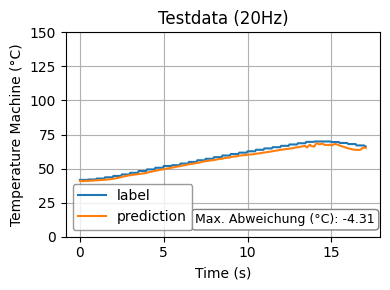

------------------------------------
------------------------------------
Number:  176
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_47.csv


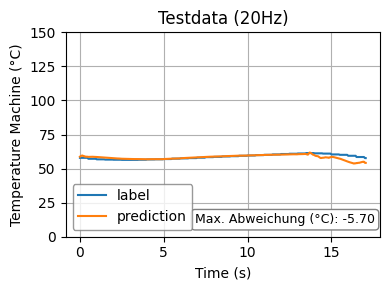

------------------------------------
------------------------------------
Number:  177
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_90.csv


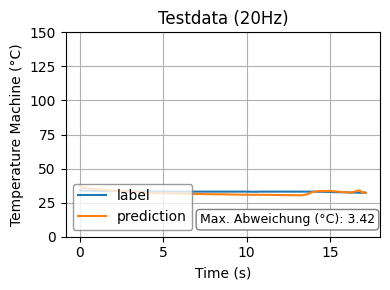

------------------------------------
------------------------------------
Number:  178
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_84.csv


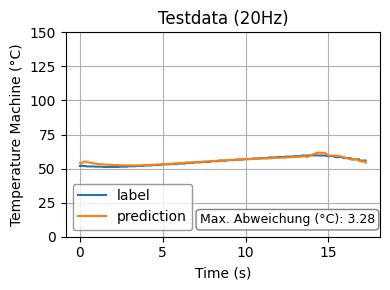

------------------------------------
------------------------------------
Number:  179
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_105.csv


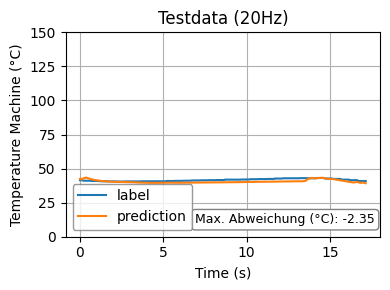

------------------------------------
------------------------------------
Number:  180
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_111.csv


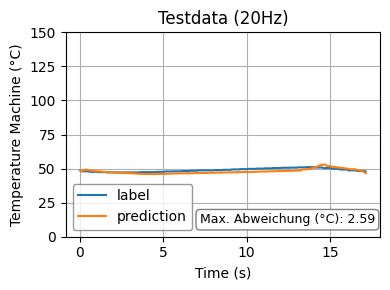

------------------------------------
------------------------------------
Number:  181
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_110.csv


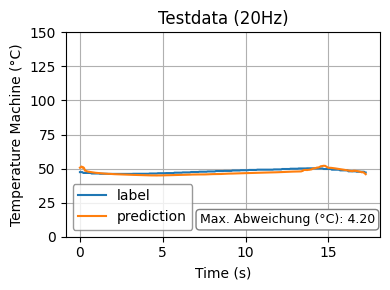

------------------------------------
------------------------------------
Number:  182
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_104.csv


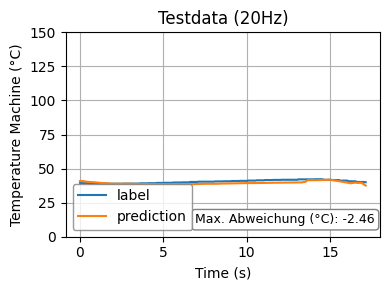

------------------------------------
------------------------------------
Number:  183
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_85.csv


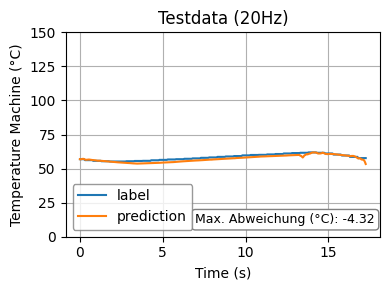

------------------------------------
------------------------------------
Number:  184
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_91.csv


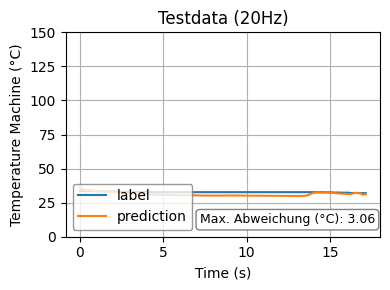

------------------------------------
------------------------------------
Number:  185
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_46.csv


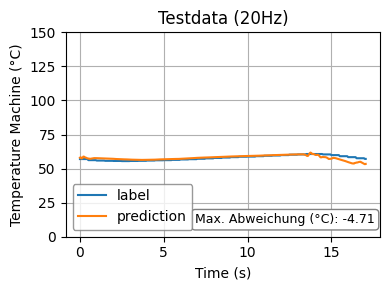

------------------------------------
------------------------------------
Number:  186
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_52.csv


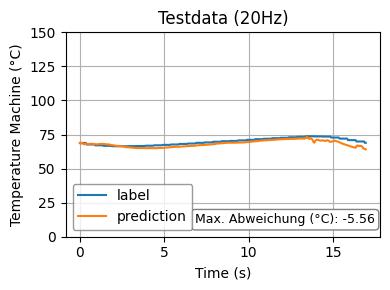

------------------------------------
------------------------------------
Number:  187
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_56.csv


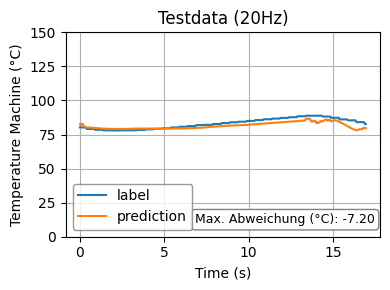

------------------------------------
------------------------------------
Number:  188
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_42.csv


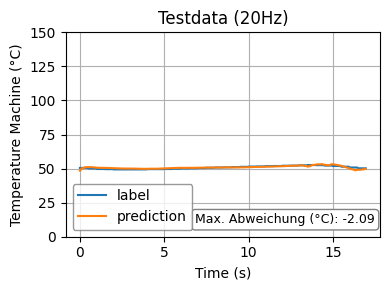

------------------------------------
------------------------------------
Number:  189
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_95.csv


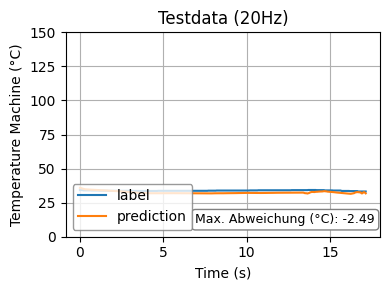

------------------------------------
------------------------------------
Number:  190
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_81.csv


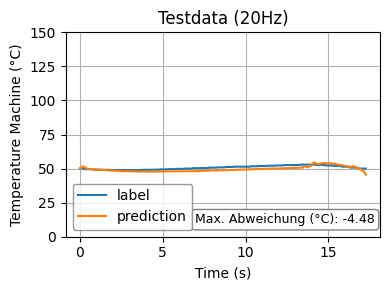

------------------------------------
------------------------------------
Number:  191
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_100.csv


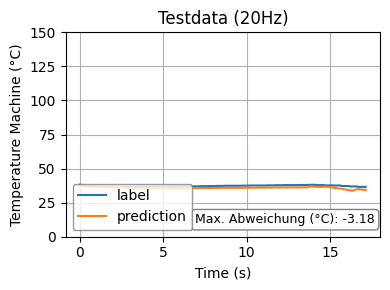

------------------------------------
------------------------------------
Number:  192
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_114.csv


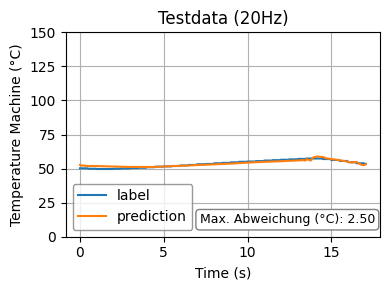

------------------------------------
------------------------------------
Number:  193
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_115.csv


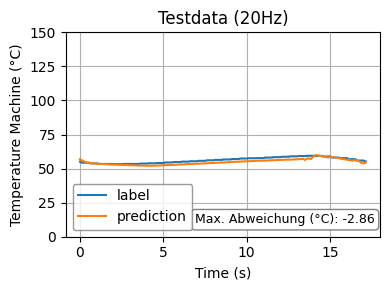

------------------------------------
------------------------------------
Number:  194
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_101.csv


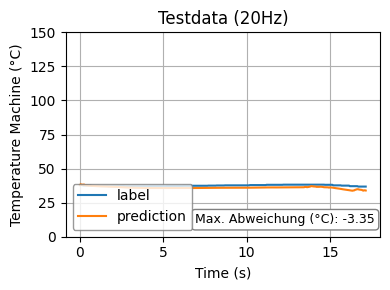

------------------------------------
------------------------------------
Number:  195
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_80.csv


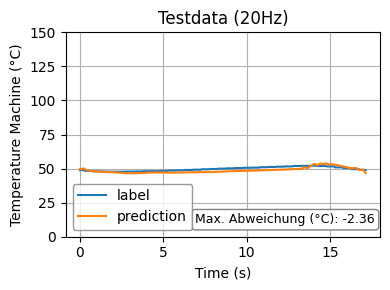

------------------------------------
------------------------------------
Number:  196
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_94.csv


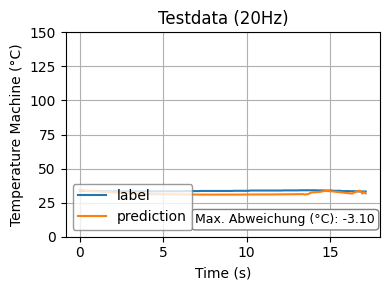

------------------------------------
------------------------------------
Number:  197
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_43.csv


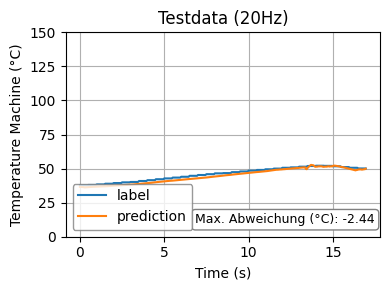

------------------------------------
------------------------------------
Number:  198
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_57.csv


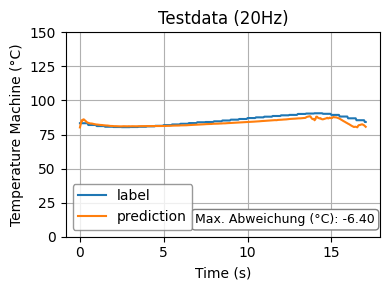

------------------------------------
------------------------------------
Number:  199
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_69.csv


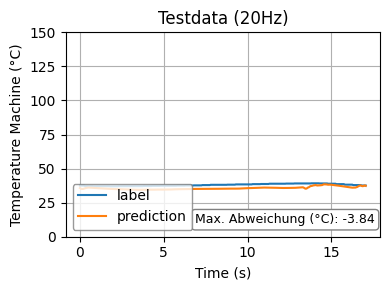

------------------------------------
------------------------------------
Number:  200
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_41.csv


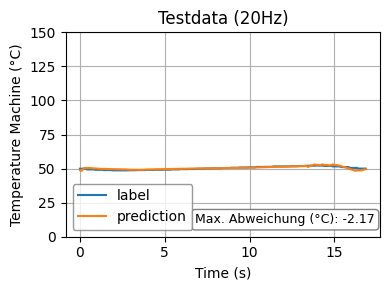

------------------------------------
------------------------------------
Number:  201
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_55.csv


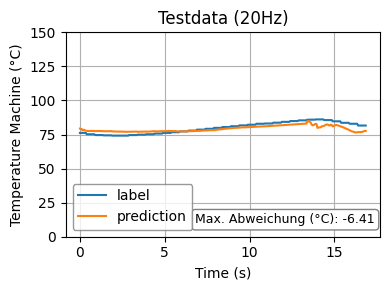

------------------------------------
------------------------------------
Number:  202
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_82.csv


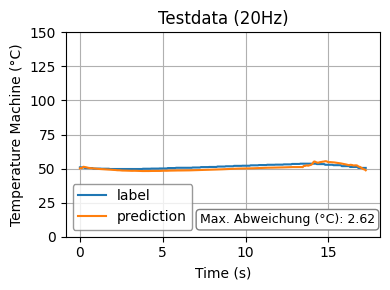

------------------------------------
------------------------------------
Number:  203
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_96.csv


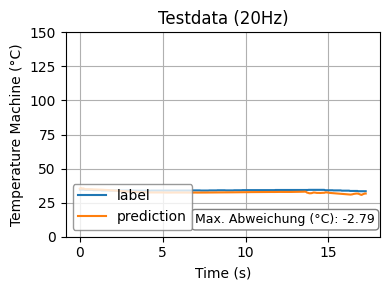

------------------------------------
------------------------------------
Number:  204
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_117.csv


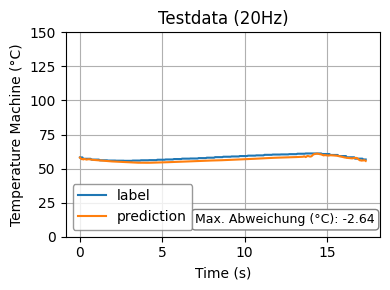

------------------------------------
------------------------------------
Number:  205
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_103.csv


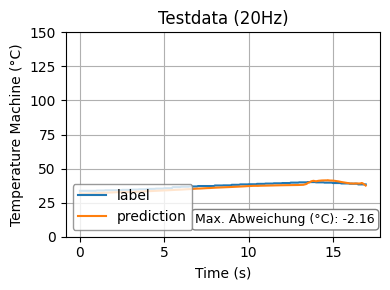

------------------------------------
------------------------------------
Number:  206
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_102.csv


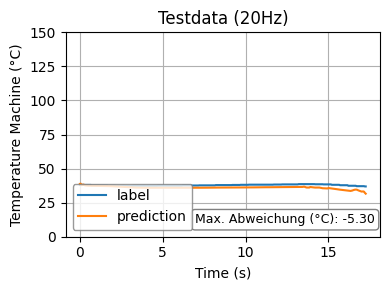

------------------------------------
------------------------------------
Number:  207
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_116.csv


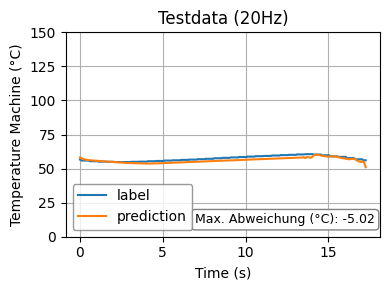

------------------------------------
------------------------------------
Number:  208
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_97.csv


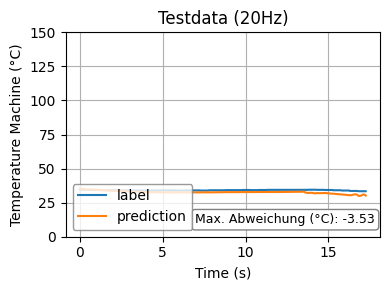

------------------------------------
------------------------------------
Number:  209
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_83.csv


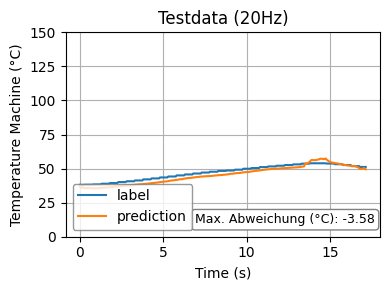

------------------------------------
------------------------------------
Number:  210
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_54.csv


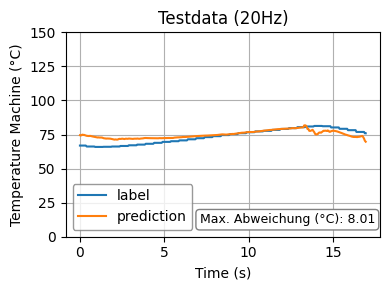

------------------------------------
------------------------------------
Number:  211
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_40.csv


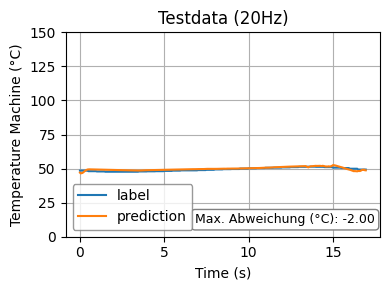

------------------------------------
------------------------------------
Number:  212
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_68.csv


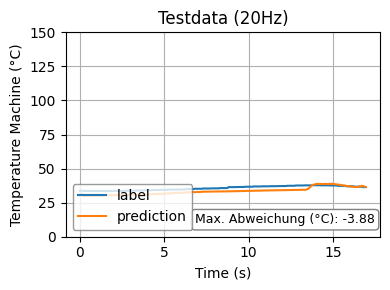

------------------------------------
------------------------------------
Number:  213
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_27.csv


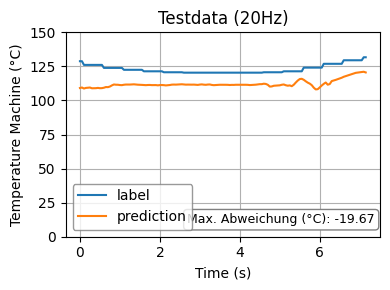

------------------------------------
------------------------------------
Number:  214
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_0.csv


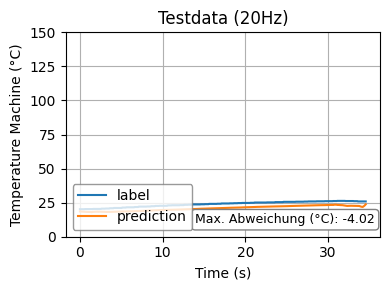

------------------------------------
------------------------------------
Number:  215
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_33.csv


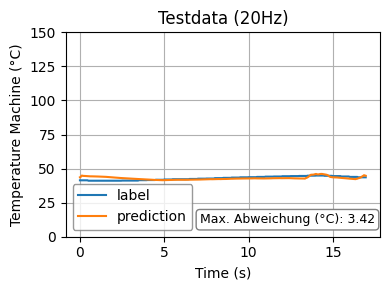

------------------------------------
------------------------------------
Number:  216
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_1.csv


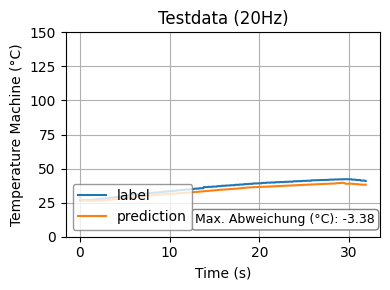

------------------------------------
------------------------------------
Number:  217
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_32.csv


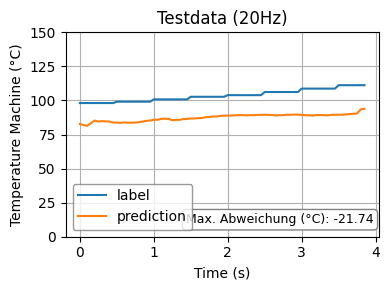

------------------------------------
------------------------------------
Number:  218
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_26.csv


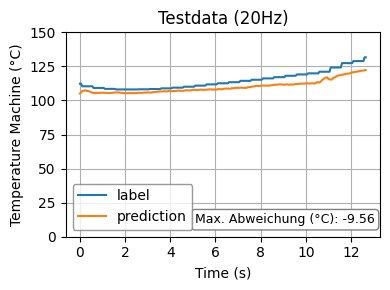

------------------------------------
------------------------------------
Number:  219
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_30.csv


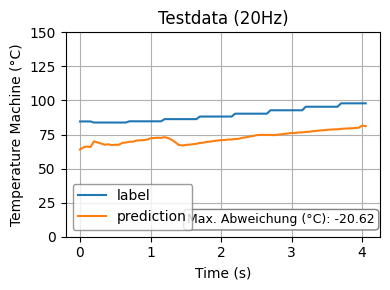

------------------------------------
------------------------------------
Number:  220
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_3.csv


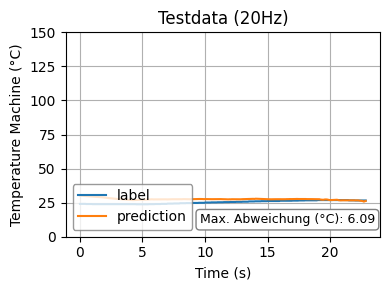

------------------------------------
------------------------------------
Number:  221
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_24.csv


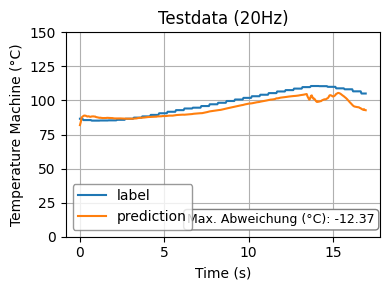

------------------------------------
------------------------------------
Number:  222
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_18.csv


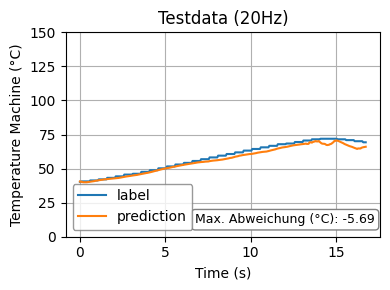

------------------------------------
------------------------------------
Number:  223
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_19.csv


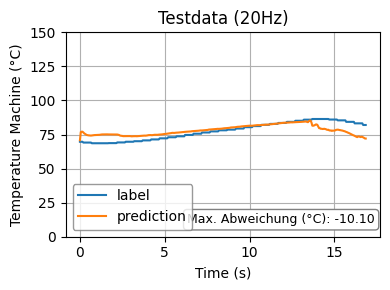

------------------------------------
------------------------------------
Number:  224
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_25.csv


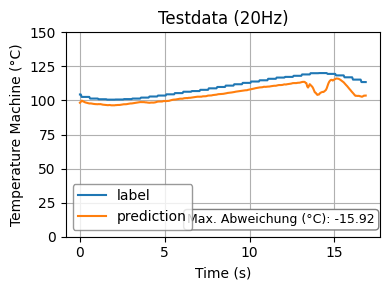

------------------------------------
------------------------------------
Number:  225
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_31.csv


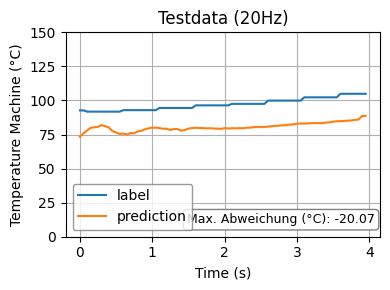

------------------------------------
------------------------------------
Number:  226
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_2.csv


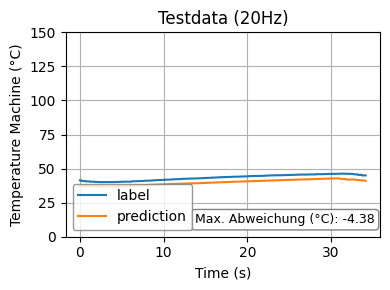

------------------------------------
------------------------------------
Number:  227
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_6.csv


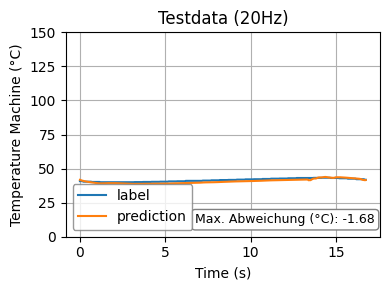

------------------------------------
------------------------------------
Number:  228
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_35.csv


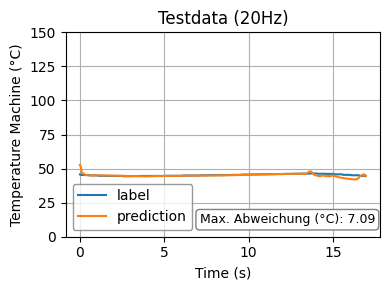

------------------------------------
------------------------------------
Number:  229
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_21.csv


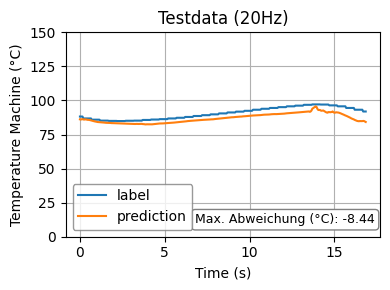

------------------------------------
------------------------------------
Number:  230
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_20.csv


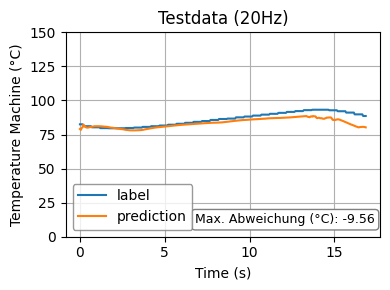

------------------------------------
------------------------------------
Number:  231
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_7.csv


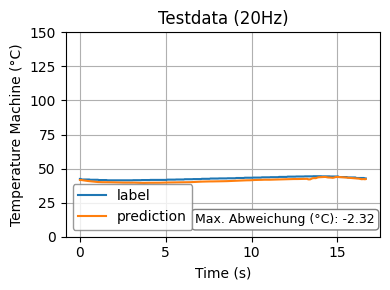

------------------------------------
------------------------------------
Number:  232
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_34.csv


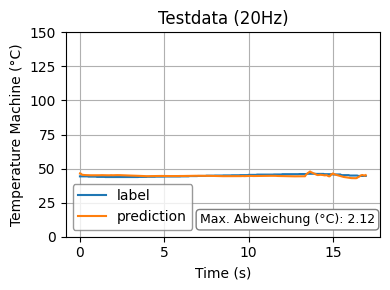

------------------------------------
------------------------------------
Number:  233
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_22.csv


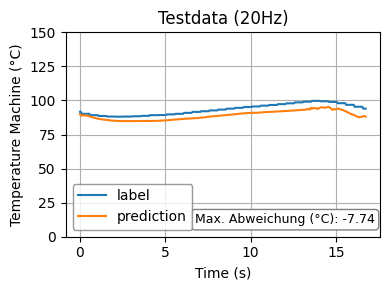

------------------------------------
------------------------------------
Number:  234
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_36.csv


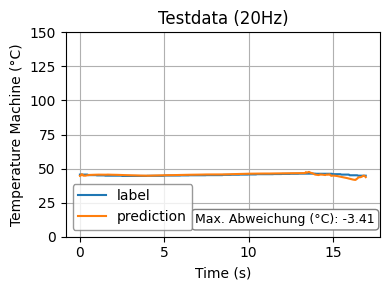

------------------------------------
------------------------------------
Number:  235
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_5.csv


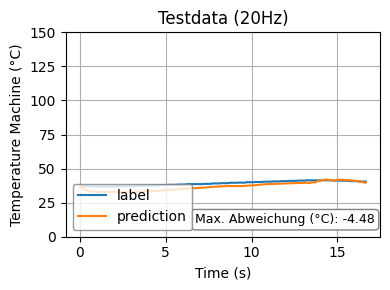

------------------------------------
------------------------------------
Number:  236
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_37.csv


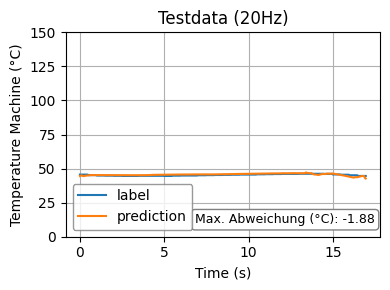

------------------------------------
------------------------------------
Number:  237
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_4.csv


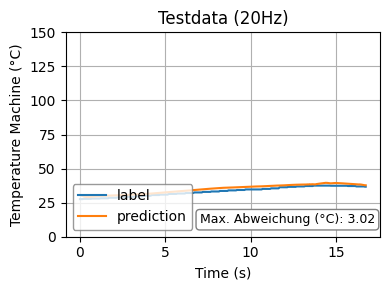

------------------------------------
------------------------------------
Number:  238
../data/test/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_30_Kennfeld_15sec_Last_20Hz_23.csv


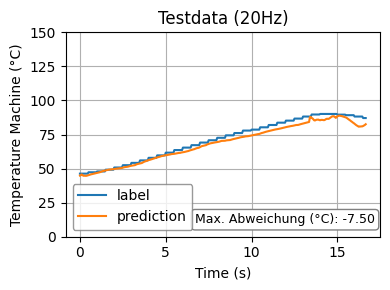

------------------------------------
------------------------------------
Number:  239
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_27.csv


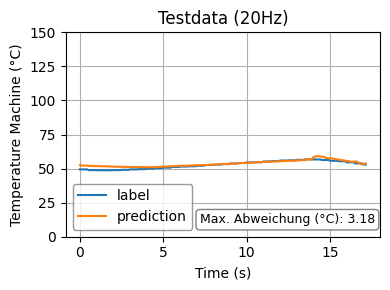

------------------------------------
------------------------------------
Number:  240
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_33.csv


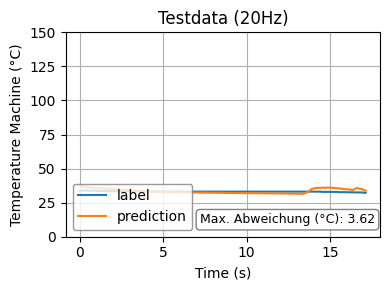

------------------------------------
------------------------------------
Number:  241
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_3.csv


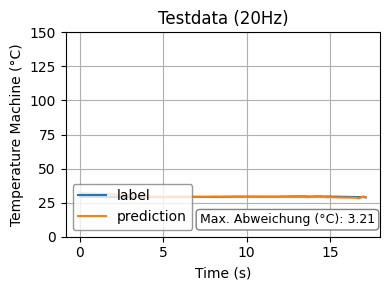

------------------------------------
------------------------------------
Number:  242
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_113.csv


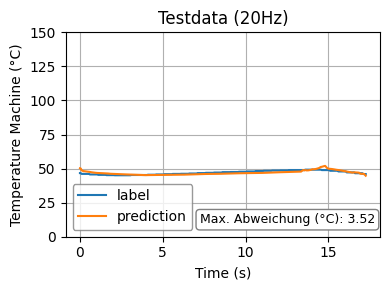

------------------------------------
------------------------------------
Number:  243
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_107.csv


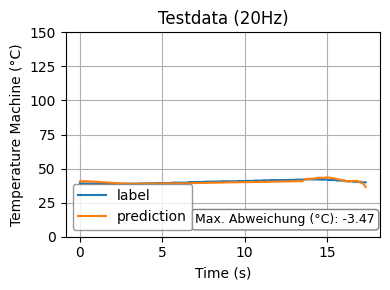

------------------------------------
------------------------------------
Number:  244
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_106.csv


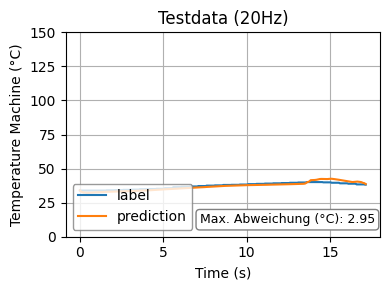

------------------------------------
------------------------------------
Number:  245
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_112.csv


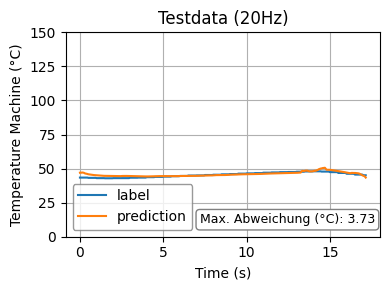

------------------------------------
------------------------------------
Number:  246
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_2.csv


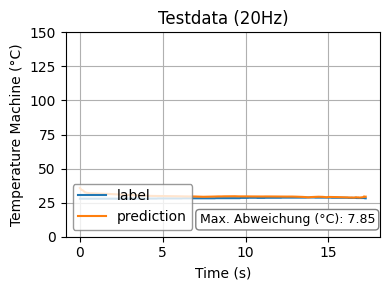

------------------------------------
------------------------------------
Number:  247
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_32.csv


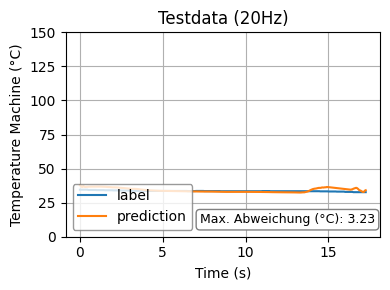

------------------------------------
------------------------------------
Number:  248
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_26.csv


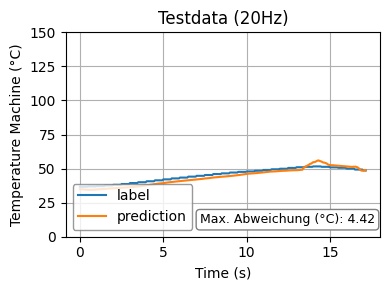

------------------------------------
------------------------------------
Number:  249
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_18.csv


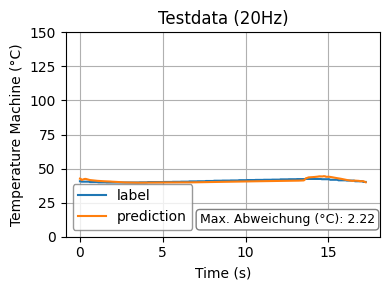

------------------------------------
------------------------------------
Number:  250
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_30.csv


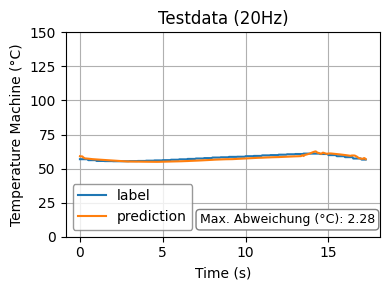

------------------------------------
------------------------------------
Number:  251
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_24.csv


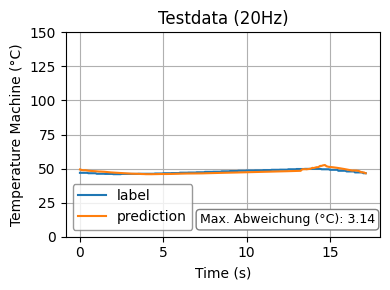

------------------------------------
------------------------------------
Number:  252
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_0.csv


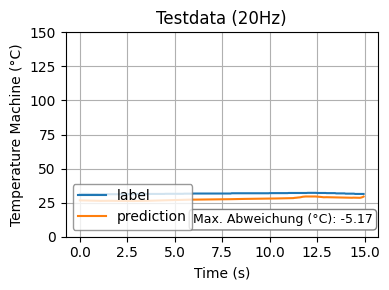

------------------------------------
------------------------------------
Number:  253
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_104.csv


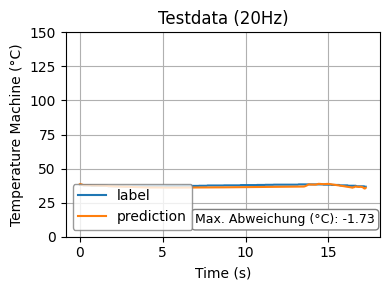

------------------------------------
------------------------------------
Number:  254
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_110.csv


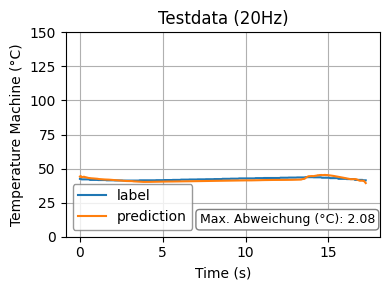

------------------------------------
------------------------------------
Number:  255
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_111.csv


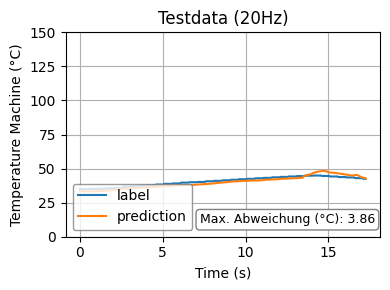

------------------------------------
------------------------------------
Number:  256
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_105.csv


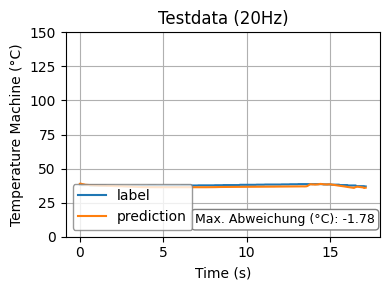

------------------------------------
------------------------------------
Number:  257
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_1.csv


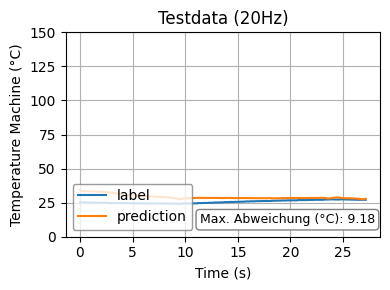

------------------------------------
------------------------------------
Number:  258
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_25.csv


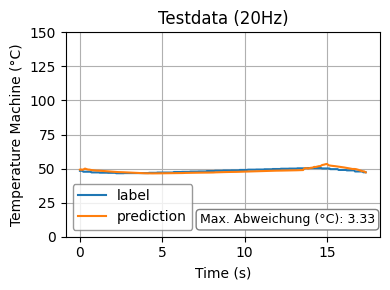

------------------------------------
------------------------------------
Number:  259
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_31.csv


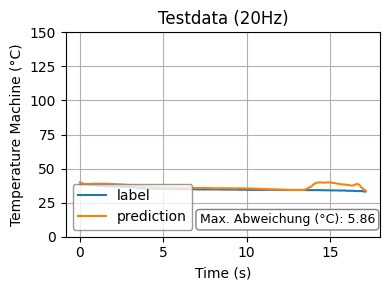

------------------------------------
------------------------------------
Number:  260
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_19.csv


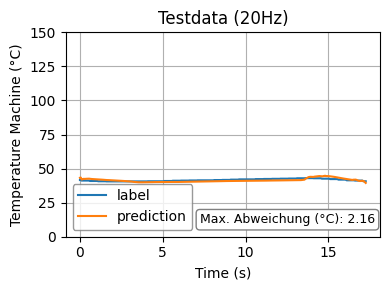

------------------------------------
------------------------------------
Number:  261
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_35.csv


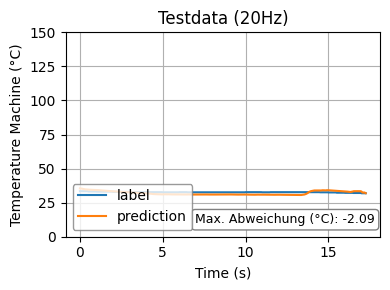

------------------------------------
------------------------------------
Number:  262
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_21.csv


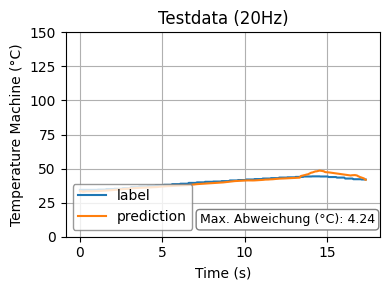

------------------------------------
------------------------------------
Number:  263
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_5.csv


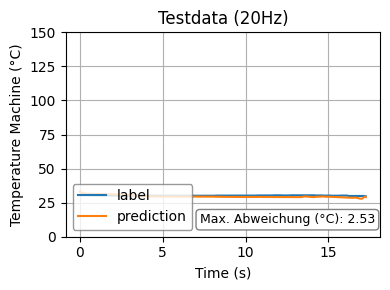

------------------------------------
------------------------------------
Number:  264
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_101.csv


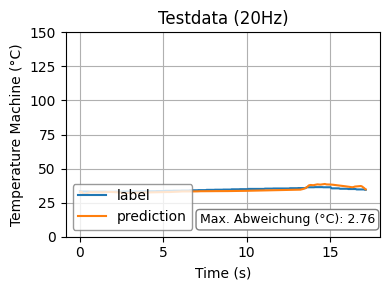

------------------------------------
------------------------------------
Number:  265
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_115.csv


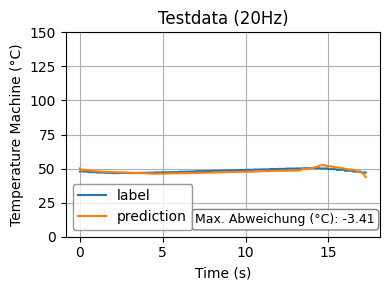

------------------------------------
------------------------------------
Number:  266
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_114.csv


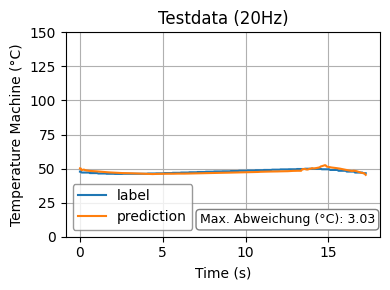

------------------------------------
------------------------------------
Number:  267
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_100.csv


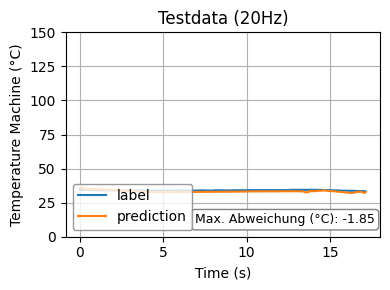

------------------------------------
------------------------------------
Number:  268
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_4.csv


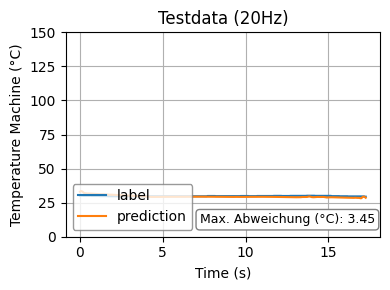

------------------------------------
------------------------------------
Number:  269
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_20.csv


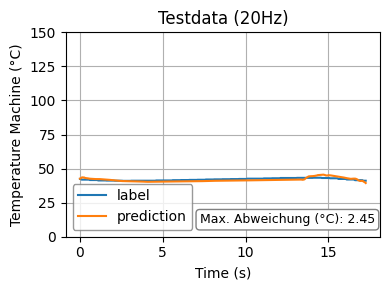

------------------------------------
------------------------------------
Number:  270
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_34.csv


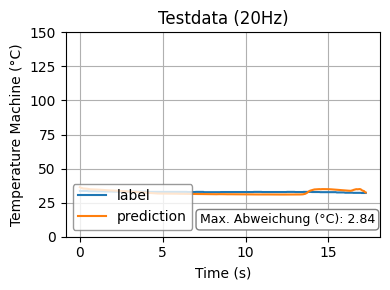

------------------------------------
------------------------------------
Number:  271
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_22.csv


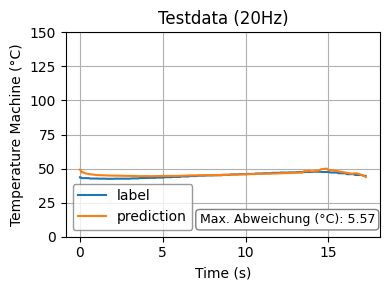

------------------------------------
------------------------------------
Number:  272
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_36.csv


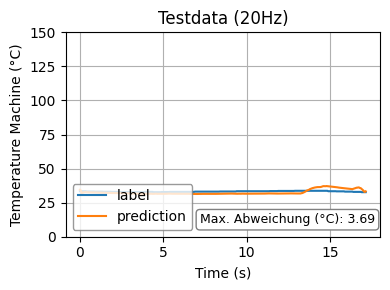

------------------------------------
------------------------------------
Number:  273
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_6.csv


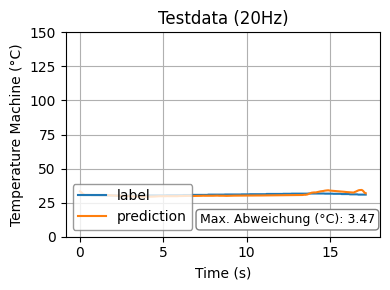

------------------------------------
------------------------------------
Number:  274
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_116.csv


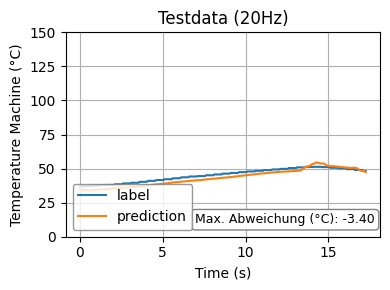

------------------------------------
------------------------------------
Number:  275
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_102.csv


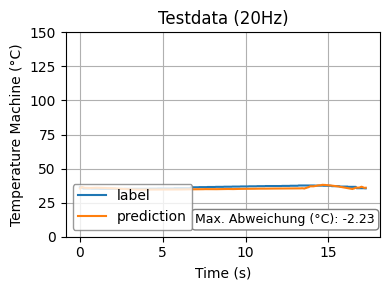

------------------------------------
------------------------------------
Number:  276
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_103.csv


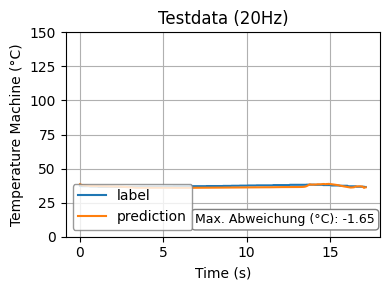

------------------------------------
------------------------------------
Number:  277
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_117.csv


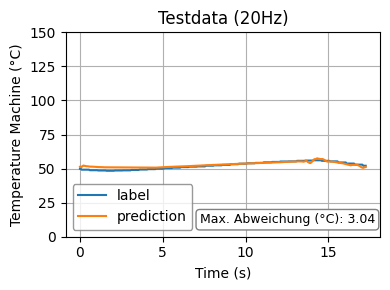

------------------------------------
------------------------------------
Number:  278
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_7.csv


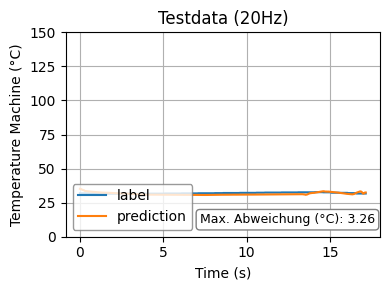

------------------------------------
------------------------------------
Number:  279
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_37.csv


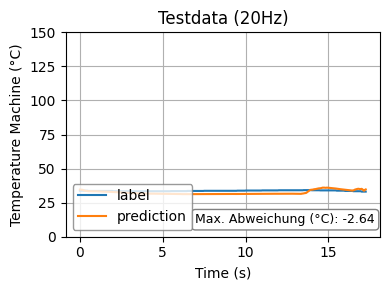

------------------------------------
------------------------------------
Number:  280
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_23.csv


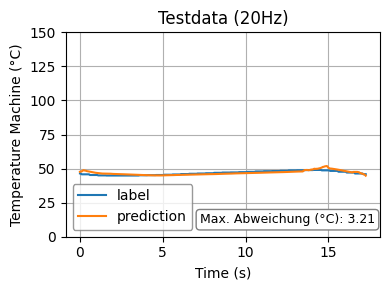

------------------------------------
------------------------------------
Number:  281
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_78.csv


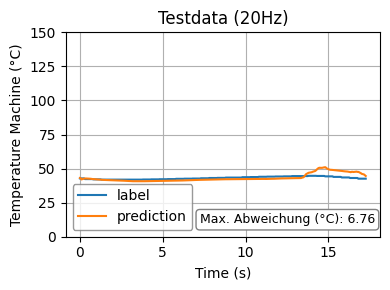

------------------------------------
------------------------------------
Number:  282
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_44.csv


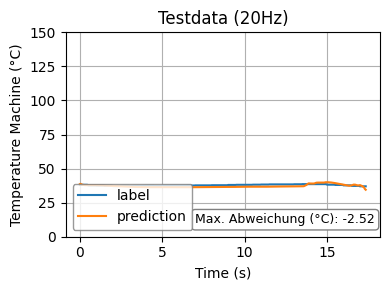

------------------------------------
------------------------------------
Number:  283
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_50.csv


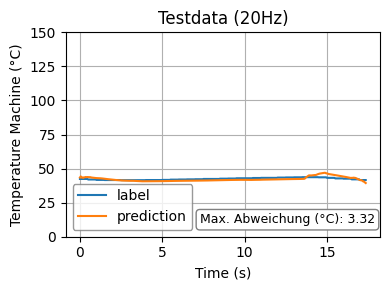

------------------------------------
------------------------------------
Number:  284
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_87.csv


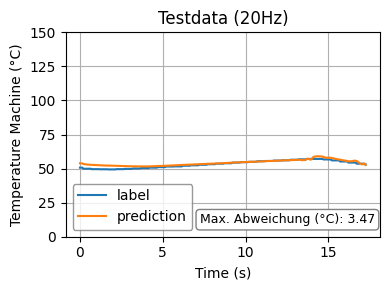

------------------------------------
------------------------------------
Number:  285
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_93.csv


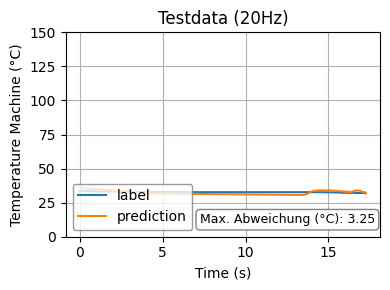

------------------------------------
------------------------------------
Number:  286
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_92.csv


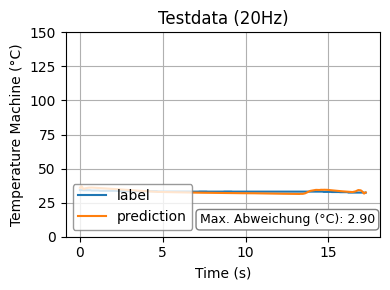

------------------------------------
------------------------------------
Number:  287
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_86.csv


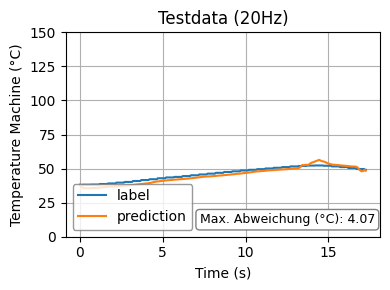

------------------------------------
------------------------------------
Number:  288
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_51.csv


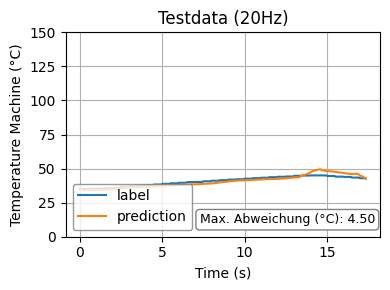

------------------------------------
------------------------------------
Number:  289
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_45.csv


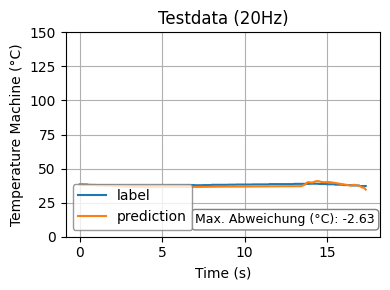

------------------------------------
------------------------------------
Number:  290
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_79.csv


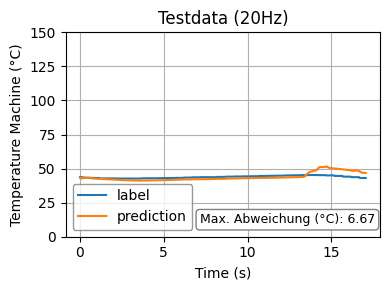

------------------------------------
------------------------------------
Number:  291
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_53.csv


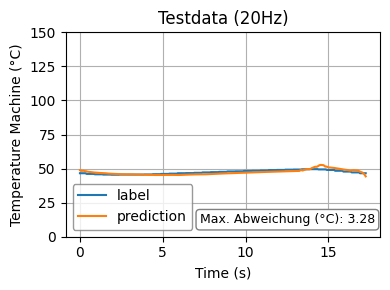

------------------------------------
------------------------------------
Number:  292
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_47.csv


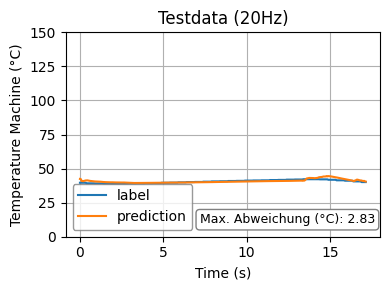

------------------------------------
------------------------------------
Number:  293
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_90.csv


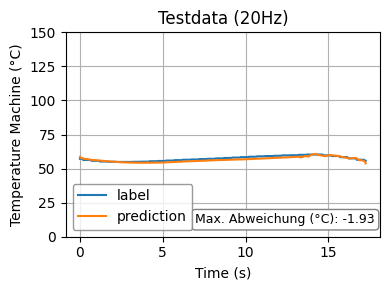

------------------------------------
------------------------------------
Number:  294
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_84.csv


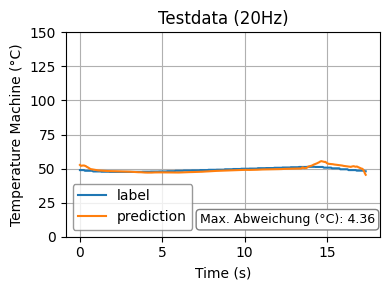

------------------------------------
------------------------------------
Number:  295
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_85.csv


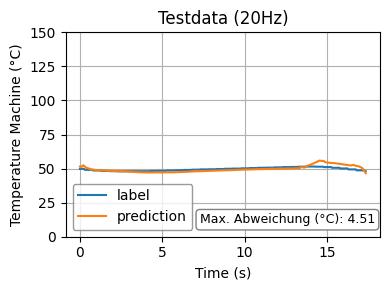

------------------------------------
------------------------------------
Number:  296
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_91.csv


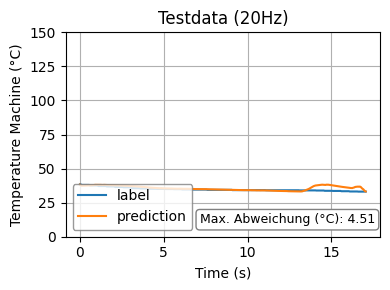

------------------------------------
------------------------------------
Number:  297
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_46.csv


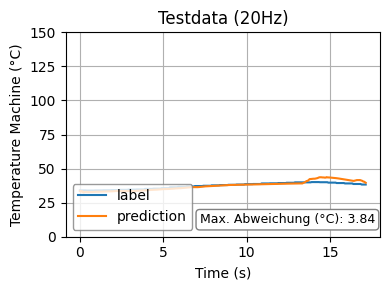

------------------------------------
------------------------------------
Number:  298
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_52.csv


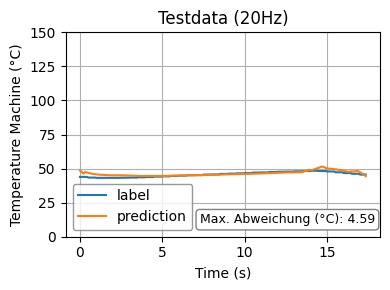

------------------------------------
------------------------------------
Number:  299
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_56.csv


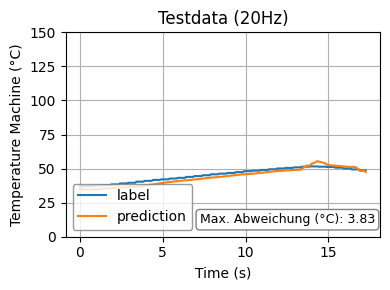

------------------------------------
------------------------------------
Number:  300
../data/test/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_intensity/LA01BT1052_26_Kennfeld_15sec_Last_20Hz_42.csv


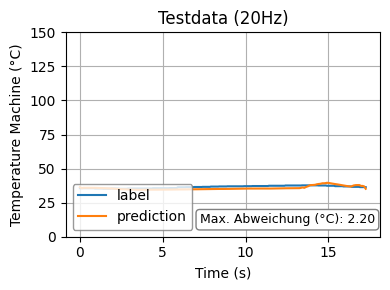

------------------------------------


In [34]:
check_label = True
check_label_done = False

def rebuild_func(delta, startvalue):
    rebuild = np.zeros(delta.shape[0])
    rebuild[0] = startvalue
    for zz in range(1, delta.shape[0]):
        rebuild[zz] = rebuild[zz-1] + delta[zz]
    return rebuild

def rescale_y(scaled_data_y, max_y, min_y):
    data_y = scaled_data_y*(max_y - min_y) + min_y
    return data_y


print(len(list_data_y_test))
if SCALE_Y == True:
    # Initialization 
    segment_low = 0 
    segment_high = 300
    if(check_label == True):
        check_dif = []
    error_list = []
    max_error_list = []
    max_error_list_temp = []    
    list_data_y_rescaled_test = list()
    prediction_list_rescaled_test = list()
    # Rescale label values
    for kk in range(len(list_data_y_test)):
        list_data_y_rescaled_test.append(rescale_y(list_data_y_test[kk], max_y, min_y))
    
    for i, model in enumerate(models):
        # Initialization
        error_list.append([])
        max_error_list.append([])
        max_error_list_temp.append([])
        prediction_list_rescaled_test.append(list())
        # Rescale prediction
        for kk in range(len(list_data_y_test)):
            prediction_list_rescaled_test[-1].append(rescale_y(prediction_list_test[i][kk], max_y, min_y))
        # Comparision: label and prediction
        for kk in range(len(list_data_y_test)):
            if(kk < segment_low or kk > segment_high):
                continue
            if(i == 0):
                print('------------------------------------')
                print('Number: ', kk)
                print(list_path_test[kk])
            # Flatten prediction
            prediction = prediction_list_rescaled_test[-1][kk].flatten() 
            # Define label
            # Use deepcopy to keep original list_data_y_rescaled_test unchanged
            label = copy.deepcopy(list_data_y_rescaled_test[kk])
            if(DELTA_START == True):
                # Calculate relevant_section, if necessary
                if(check_label == True and check_label_done == False):
                    relvant_section = len(list_data_y_test_no_delta[kk]) - len(prediction)
                # Define start value of frame
                start_value_frame = list_data_y_test_no_delta[kk][0]
                # Check alternative 
                if(check_label == True and check_label_done == False):
                    check_label_done = True
                    check_dif.append(np.max(abs(list_data_y_test_no_delta[kk][relvant_section:] - (label + start_value_frame))))        
            # Calculate error between prediction and label
            error = prediction - label
            error_list[-1].extend(list(error))
            max_error_index = np.argmax(abs(error))
            max_error_list[-1].append(error[max_error_index])
            if(DELTA_START == True):
                max_error_list_temp[-1].append(label[max_error_index] + start_value_frame)
            else: 
                max_error_list_temp[-1].append(label[max_error_index])
            # Add start value to label and prediction
            if(DELTA_START == True):
                label += start_value_frame
                prediction += start_value_frame
            if(i == 0):
                # Plot label and prediction (absolute temperature)
                if(OFFSET != 0):
                    time = np.arange(0, len(prediction)*NR_SAMPLES*OFFSET, NR_SAMPLES*OFFSET)/int(FREQUENCY[:2])
                else:
                    time = np.arange(len(prediction))/int(FREQUENCY[:2])
                plt.figure(figsize=(4, 3))
                plt.plot(time, label, label = "label")
                plt.plot(time, prediction, label = "prediction")
                plt.text(0.9842, 0.115, f"Max. Abweichung (°C): {error[max_error_index]:.2f}", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
                plt.xlabel("Time (s)")
                plt.ylabel("Temperature Machine (°C)")
                plt.ylim(0, 150) 
                plt.legend(loc='lower left', edgecolor='gray')
                plt.grid()
                plt.title(f"Testdata ({FREQUENCY})")
                plt.tight_layout()
                plt.show()
                print('------------------------------------')
else:
        print('Create Output Logic!')       

In [35]:
if(ANALYZE and CONVERT_MODEL and QUANTIZE_MODEL):
    for frame in range(len(list_data_x_test)):
        plt.figure(figsize=(4, 3))
        plt.plot(prediction_list_rescaled_test[0][frame], color='red', linewidth=4)
        plt.plot(prediction_list_rescaled_test[1][frame], color='blue')
        plt.plot(prediction_list_rescaled_test[2][frame], color='green')
        plt.show
else:
    print("Inactive!")

Inactive!


error = prediction - label
Avg. Abweichung (Betrag aller Fehler):  3.8108759294142427 °C
Max. Abweichung --> Index:  105  Value:  -22.310935058593742 °C


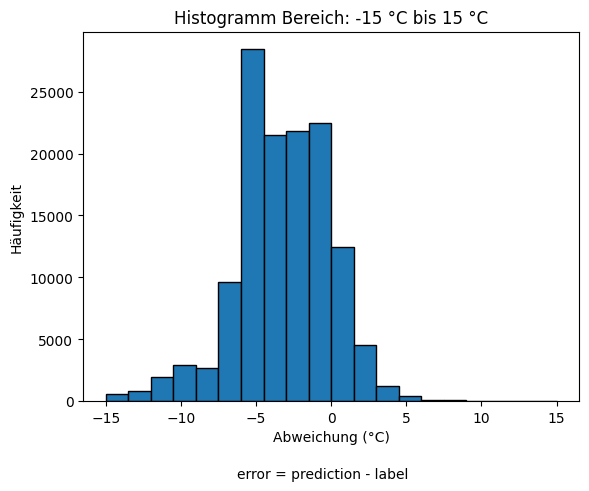

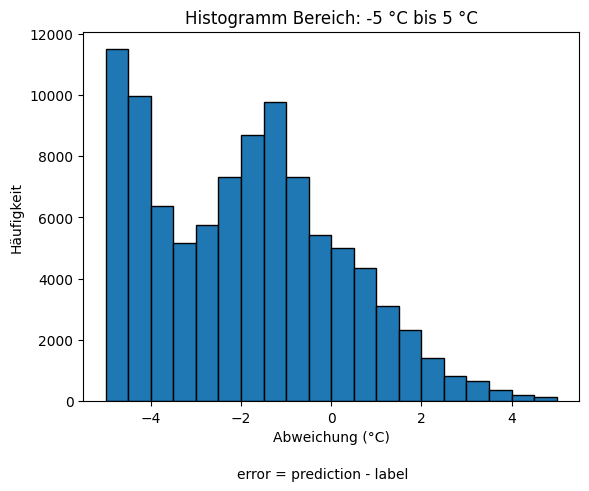

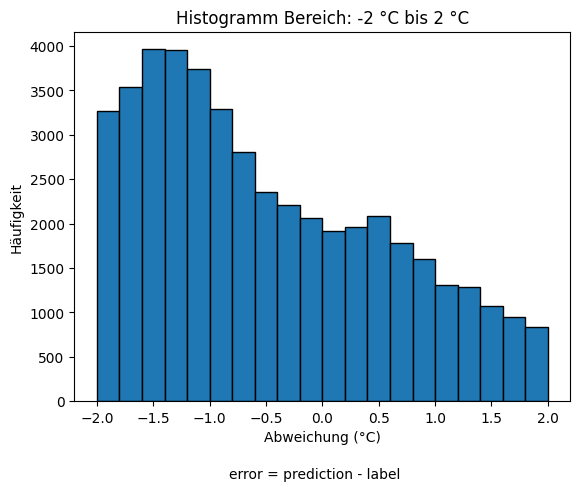

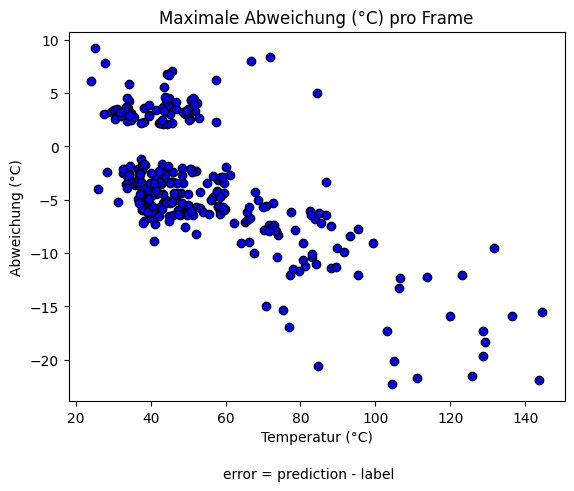

error = prediction - label
Avg. Abweichung (Betrag aller Fehler):  3.8108753624450187 °C
Max. Abweichung --> Index:  105  Value:  -22.311003723144523 °C


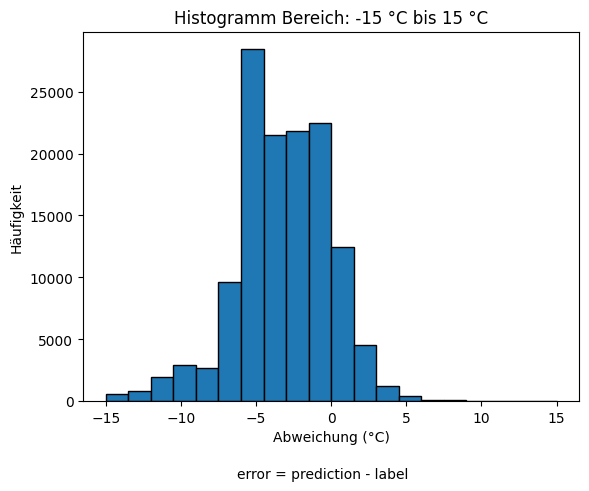

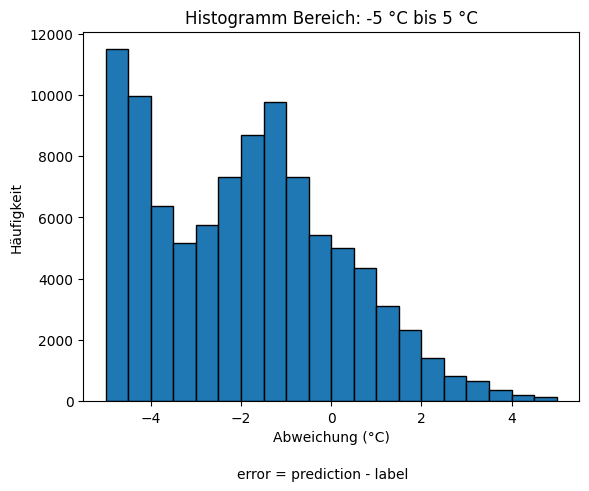

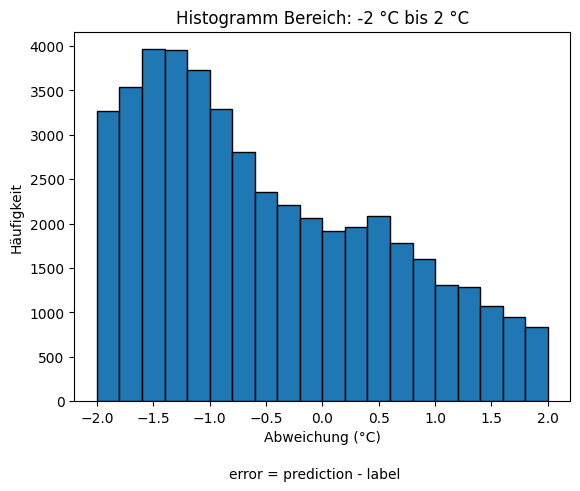

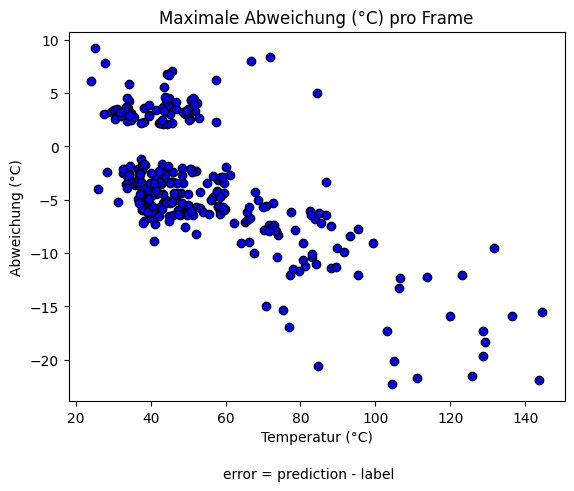

error = prediction - label
Avg. Abweichung (Betrag aller Fehler):  3.7956778618967255 °C
Max. Abweichung --> Index:  36  Value:  -25.0828549194336 °C


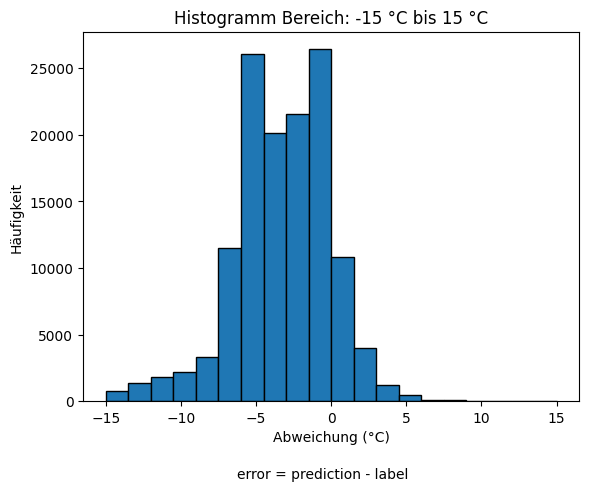

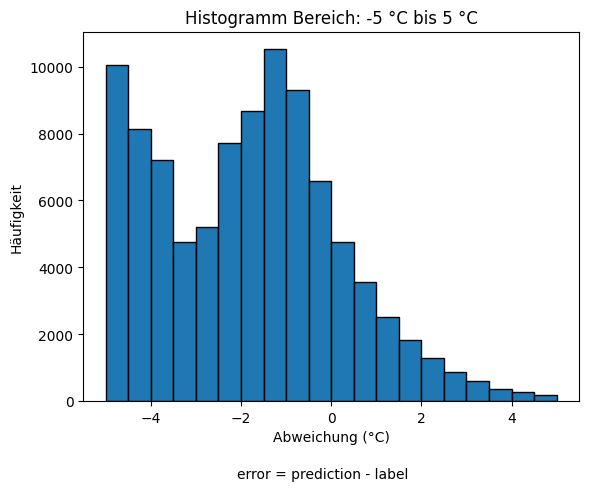

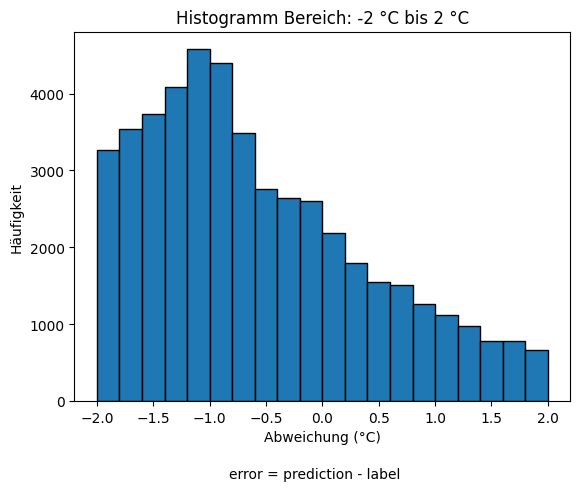

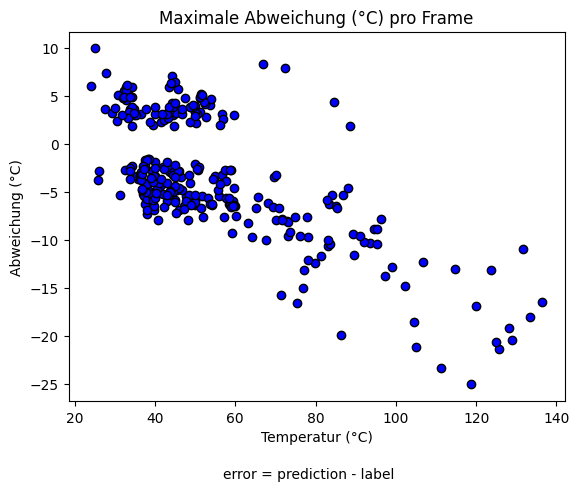

In [36]:
if SCALE_Y == True:
    for i, model in enumerate(models):
        print('error = prediction - label')
        abs_error_list = [abs(e) for e in error_list[i]]
        print("Avg. Abweichung (Betrag aller Fehler): ", np.average(abs_error_list), "°C")
        abs_max_error_list = [abs(e) for e in max_error_list[i]]
        index = np.argmax(abs_max_error_list)
        print("Max. Abweichung --> Index: ", index, " Value: ", max_error_list[i][index], "°C")
        plt.figure()
        plt.hist(error_list[i], bins=20, range=(-15, 15), edgecolor='black')
        plt.xlabel('Abweichung (°C)')
        plt.ylabel('Häufigkeit')
        plt.title('Histogramm Bereich: -15 °C bis 15 °C')
        plt.figtext(0.5, -0.05, 'error = prediction - label', ha='center', fontsize=10)
        plt.show()
        plt.figure()
        plt.hist(error_list[i], bins=20, range=(-5, 5), edgecolor='black')
        plt.xlabel('Abweichung (°C)')
        plt.ylabel('Häufigkeit')
        plt.title('Histogramm Bereich: -5 °C bis 5 °C')
        plt.figtext(0.5, -0.05, 'error = prediction - label', ha='center', fontsize=10)
        plt.show()
        plt.figure()
        plt.hist(error_list[i], bins=20, range=(-2, 2), edgecolor='black')
        plt.xlabel('Abweichung (°C)')
        plt.ylabel('Häufigkeit')
        plt.title('Histogramm Bereich: -2 °C bis 2 °C')
        plt.figtext(0.5, -0.05, 'error = prediction - label', ha='center', fontsize=10)
        plt.show()
        plt.figure()
        plt.scatter(max_error_list_temp[i], max_error_list[i], color='blue', edgecolors='black')
        # plt.ylim(-7.5, 7.5)
        plt.xlabel('Temperatur (°C)')
        plt.ylabel('Abweichung (°C)')
        plt.title('Maximale Abweichung (°C) pro Frame')
        plt.figtext(0.5, -0.05, 'error = prediction - label', ha='center', fontsize=10)
        plt.show()
    if(check_label == True and DELTA == True):
            print("Check Label --> Index: ", np.argmax(check_dif), " Value: ", np.max(check_dif))

In [37]:
if((CONVERT_MODEL and QUANTIZE_MODEL) or USE_QUANTIZED_MODELS):
    if(GENERATE_C_ARRAY):
        MODEL_C = MODEL_TF + MODEL_NAME + ".c"
        print(MODEL_TF_LITE_QUANTIZATION)
        !xxd -i "{MODEL_TF_LITE_QUANTIZATION}" > "{MODEL_C}"